## Hong Benchmark F1plusF2 (no training) just PDF shaping

* Benchmark Hong 
* I had to inititalize the weights to 1 to intentionally create a crazy neural net in the beginning that was a big challenge for PDF shaping

## Inputs

(0, 'i_u1')

(1, 'i_u2')



## Outputs


(0, 'o_y')




In [1]:


import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import functorch

from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import vstack
from numpy import exp
from sklearn.neighbors import KernelDensity

##from typing import Optional

from torch import Tensor


from torch.utils.data import TensorDataset, DataLoader

from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)


In [2]:

import PDFshapingUtils as PDF_tk


In [3]:

PDFshapingOBJ = PDF_tk.PDFshapingUtils()


## Impulse Function Target

In [4]:

PDFshapingOBJ.initializeImpulseGaussian()
## PDFshapingOBJ.initializeImpulseToOtherShapes()                ## debug only, remove rc

print(PDFshapingOBJ.x_range_impulse_func )
print(PDFshapingOBJ.impulse_func_vector_vals )
print(PDFshapingOBJ.x_range_impulse_func.shape )
print(PDFshapingOBJ.impulse_func_vector_vals.shape )
 
print( sum(PDFshapingOBJ.impulse_func_vector_vals) )      ## should add up to 100 (i.e. 1.0 prob density)


tensor([-20.0000, -19.9900, -19.9800,  ...,  19.9700,  19.9800,  19.9900])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([4000])
torch.Size([4000])
tensor(100.0000)


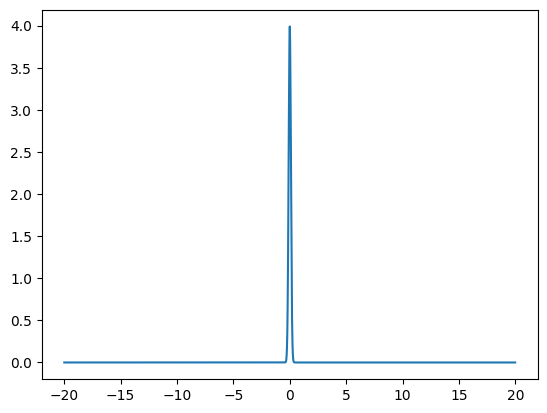

In [5]:

plt.plot(PDFshapingOBJ.x_range_impulse_func, PDFshapingOBJ.impulse_func_vector_vals)
plt.show()


## This is just to test with fake data the KDE

torch.Size([400, 5])


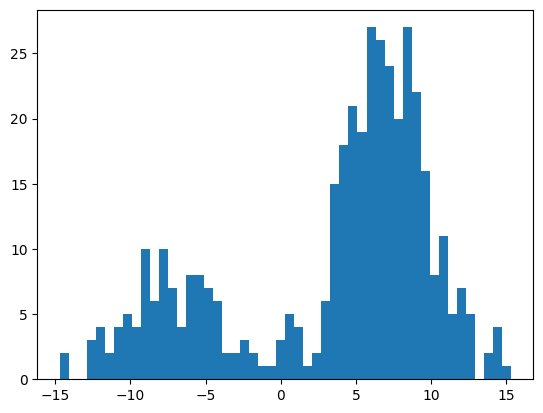

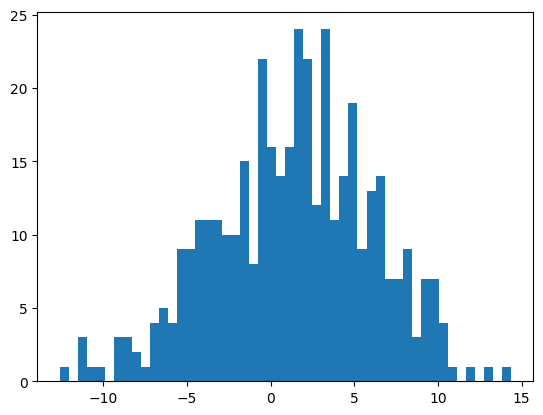

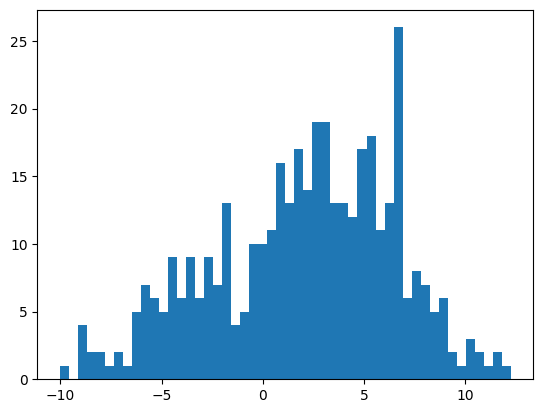

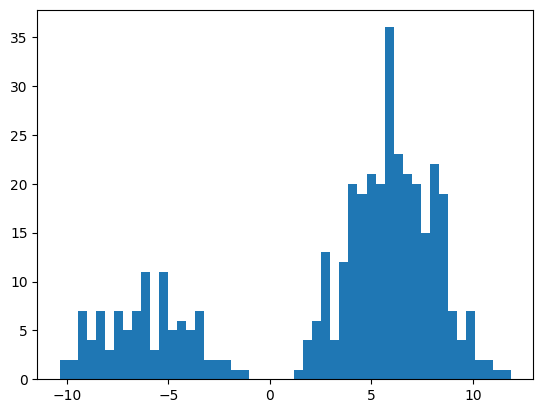

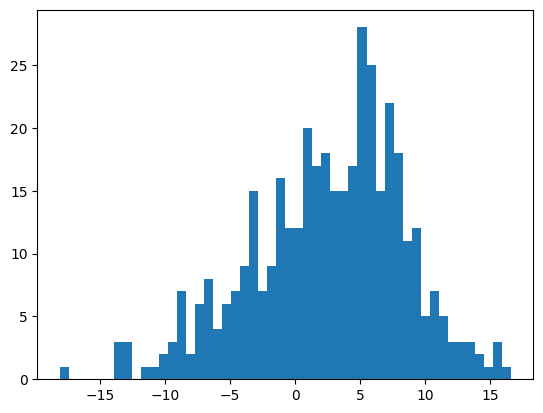

torch.Size([400, 5])
tensor([[  4.8353,   4.0209,   2.0759,  10.6177,  10.6251],
        [  9.4442,  -2.0404,  10.2941,   4.7439,   3.6030],
        [  5.0008,  -1.3230,   6.6152,   8.0006,   4.8831],
        ...,
        [-10.2866,  -0.6630,  -0.2277, -10.3447,  -1.7993],
        [-11.8746,   1.3322,  -4.2647,  -2.4869, -13.2632],
        [ -9.1626,  -3.9538,  -0.1774,  -4.6512,  -1.2152]],
       dtype=torch.float64)
5
0
torch.Size([400])
1
torch.Size([400])
2
torch.Size([400])
3
torch.Size([400])
4
torch.Size([400])
torch.Size([4000, 5])


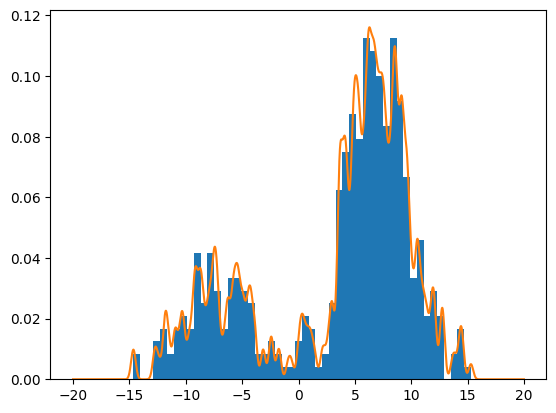

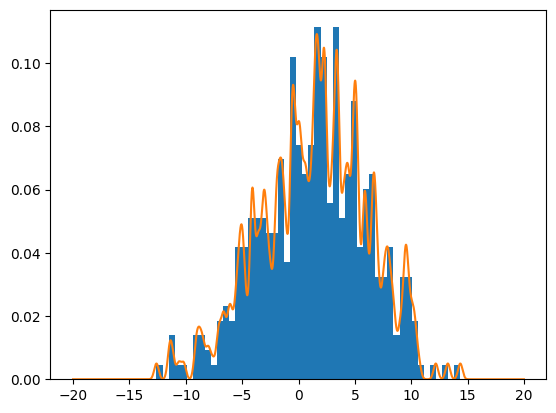

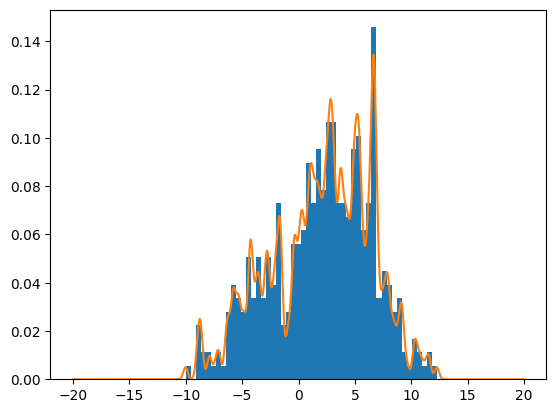

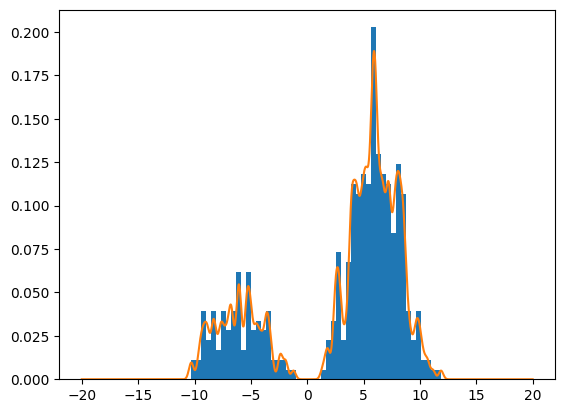

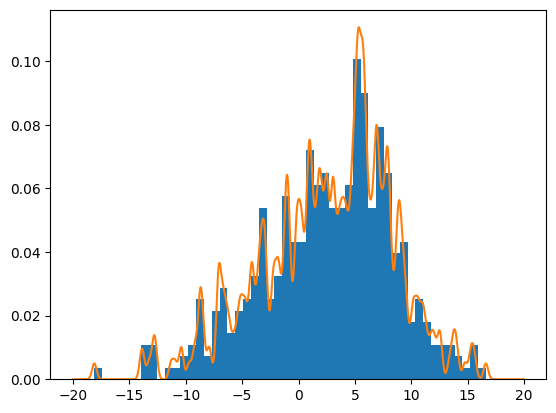

tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)


In [6]:

PDFshapingOBJ.test_torchKDE_with_fake_data()


In [7]:

PDFshapingOBJ.read_csv_file_with_pandas('benchmarks/BenchmarkDataHong.csv')


In [8]:
PDFshapingOBJ.CFD_raw_data

i_u1     i_u2      o_y
0     0.000077   1.2406  10.0000
1     0.000238   1.0155  10.0000
2     0.000740   1.3879  10.0010
3     0.001617   1.0262  10.0020
4     0.003202   1.9126  10.0020
..         ...      ...      ...
995  51.626000  34.4560  11.4980
996  20.462000  28.9600  10.7070
997  37.754000  26.4760  11.4260
998 -10.288000  35.7610   9.7123
999 -63.098000  30.9140   7.9589

[1000 rows x 3 columns]

In [9]:

PDFshapingOBJ.print_headers_list()


['i_u1', 'i_u2', 'o_y']
3
(0, 'i_u1')
(1, 'i_u2')
(2, 'o_y')


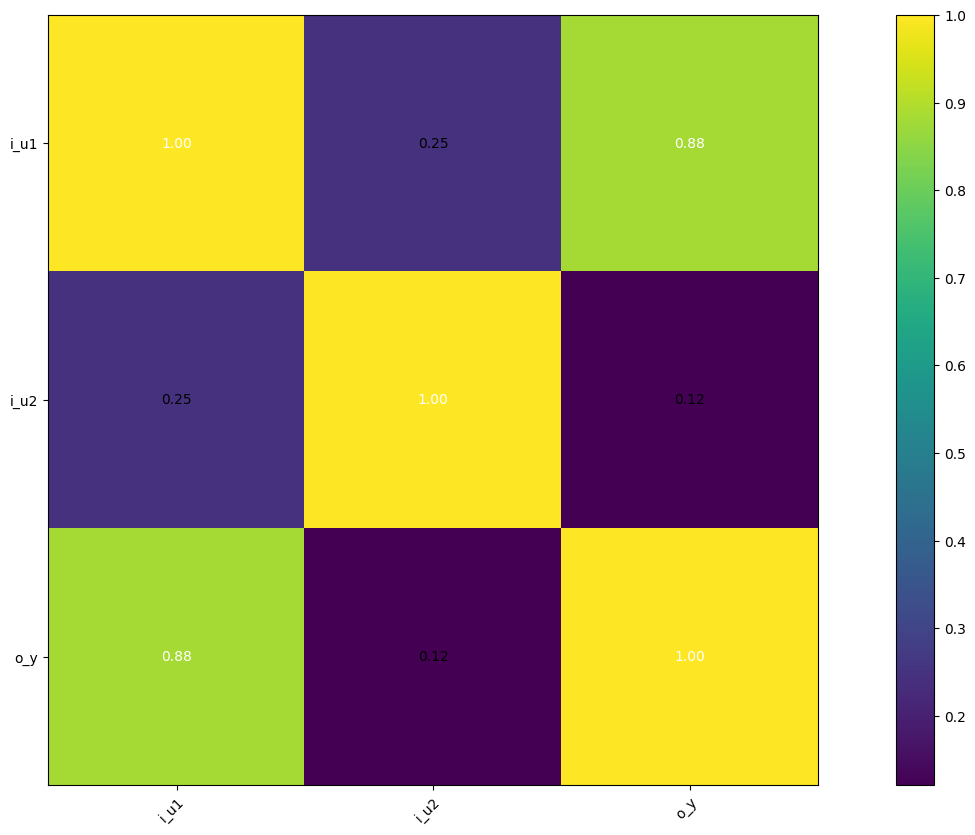

In [10]:

PDFshapingOBJ.list_of_selected_column_names = ['i_u1', 'i_u2', 'o_y']

PDFshapingOBJ.print_correlation_coefficients()


In [11]:

PDFshapingOBJ.convert_pd_data_to_numpy()


[[  0.0000774    1.2406      10.        ]
 [  0.00023827   1.0155      10.        ]
 [  0.00073993   1.3879      10.001     ]
 ...
 [ 37.754       26.476       11.426     ]
 [-10.288       35.761        9.7123    ]
 [-63.098       30.914        7.9589    ]]
(1000, 3)


In [12]:

PDFshapingOBJ.gen_X_y_for_selected_indeces(  
                   inputs=[0, 1] , 
                   outputs=[2]   
)


2
1


In [13]:

print(PDFshapingOBJ.X.shape)
print(PDFshapingOBJ.y.shape)



(1000, 2)
(1000, 1)


In [14]:

PDFshapingOBJ.random_seed = int( random.random() * 100  )         ## defautl is 42


In [15]:

PDFshapingOBJ.split_np_data_train_test(selected_test_size=0.2)


(800, 2)
(200, 2)
(800, 1)
(200, 1)


In [16]:

PDFshapingOBJ.convert_dataset_from_np_to_torch()


In [17]:

PDFshapingOBJ.standardize_X_scales()
PDFshapingOBJ.standardize_y_scales()


In [18]:

PDFshapingOBJ.gen_Dataloader_train()

PDFshapingOBJ.train_dl


## NN architectures

In [19]:

#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(2, 1) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
#############################################################
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(2, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.zeros_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.zeros_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(2, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Sigmoid() 
        self.linear3 = nn.Linear(6, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        ## x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

      
#############################################################


In [20]:


#############################################################
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(2, 1)       
        
        ## F2
        self.f2_linear1 = nn.Linear(2, 10)
        self.f2_act1    = nn.Sigmoid()                    ## Tanh()                       
        self.f2_linear2 = nn.Linear(10, 1)       
        self.f2_dropout = nn.Dropout(0.25)
        
        nn.init.ones_(self.f1_linear1.weight)   ## intitializing to all ones to see PDF shaping effect, remove
        nn.init.ones_(self.f1_linear1.bias) 
        
        nn.init.ones_(self.f2_linear1.weight) 
        nn.init.ones_(self.f2_linear1.bias) 
        
        nn.init.ones_(self.f2_linear2.weight) 
        nn.init.ones_(self.f2_linear2.bias) 
        
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        f2 = self.f2_linear2(f2)
        
        
        y_scaled   = f1 + f2
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    



In [21]:

class SigmaNN(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        
     
        self.linear1 = nn.Linear(4000, 1000)
        self.act1    = nn.Sigmoid()          ## nn.Tanh()          ## Sigmoid()       nn.GELU()  
        self.linear2 = nn.Linear(1000, 500)
        self.act2    = nn.Sigmoid()         ## nn.Tanh()          ## Sigmoid()       nn.GELU()   
        self.linear3 = nn.Linear(500, 24000)   
        self.act3    = nn.Sigmoid() 
        self.dropout = nn.Dropout(0.25)
        
        
    ## perform inference
    def forward(self, x):
     
        f = self.linear1(x)
        f = self.act1(f)
        f = self.dropout(f)
        f = self.linear2(f)
        f = self.act2(f)
        f = self.dropout(f)
        f = self.linear3(f)
        f = self.act3(f)
 
        return f
    

In [22]:

def my_loss_UNKNOWN_error_PDF(epoch, output, target):
    error = output.float() - target.float()                            ## 400 X 5
    impulseFunc = ImpulseGaussian(x, mean_impulse, std_impulse**2)        ## 4000 X 1
    basisFunc = train_multiple_kernels_per_output(x, error, bandwidth)    ## 4000 x 5
    
    if epoch % 50 == 0:
        print_errors_kdes(error, x, basisFunc)
        print(impulseFunc.shape)
        print(basisFunc.shape)
    
    basisFunc = basisFunc.T
    diff = ( basisFunc.float() -  impulseFunc.float()  )                 ## 4000 x 5
    loss = torch.mean(   (   diff  )**2    )   
    ## reg_sigma_func = (loss ** 2) * use_regularization
    ## loss = loss * ( 1.0 + reg_sigma_func )
    return loss


In [23]:

def my_loss_known_is_gauss(output, target):
       
    error = output.float() - target.float() 
    basisFunc   =  kernel_density(x, error, h)
    diff = ( basisFunc.float() -  impulseFunc.float()  )        
    loss = torch.mean(   (   diff  )**2    )    ## / h
    return loss


## Results for g(x) = F1(x) + F2(x) with No PDF shaping

F1 = Linear

F2 = Nonlinear

In [24]:

def fit_y_scaled(num_epochs, model, loss_fn, opt):
    
    PDFshapingOBJ.list_metric = []
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
            
            
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(
            torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()   )
            )
        )
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,           PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy()  ))
    



In [25]:
PDFshapingOBJ.the_string           = "No_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "shaft"

0  loss=  tensor(69.7788, grad_fn=<MseLossBackward0>)


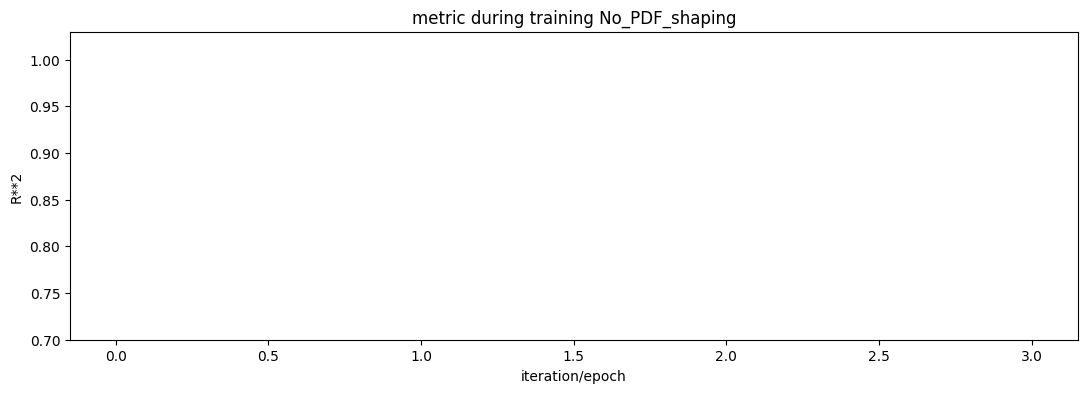

Training loss: tensor(50.5044, grad_fn=<MseLossBackward0>)
Training R**2: -3.46582910340483
Test loss - scaled: tensor(54.1366, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(201.8479, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: -3.4926053504508676
Testing R**2 - descaled: -3.4926053757063737
*****
*****
Testing R**2 - Output: 0 o_y -3.4926053757063737


In [26]:

PDFshapingOBJ.N_EPOCHS = 4

model = F1plusF2_SIO(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations
)

opt = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate   )
loss_fn = F.mse_loss


fit_y_scaled(PDFshapingOBJ.N_EPOCHS, model, loss_fn, opt)


pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,         PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,       PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()    ))

PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)


In [28]:
list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])

**************************************************
preds, real
(15.965386, 9.4063)
**************************************************
preds, real
(24.771599, 13.524)
**************************************************
preds, real
(16.659065, 10.02)
**************************************************
preds, real
(19.122204, 8.1668)
**************************************************
preds, real
(19.495672, 9.0011)
**************************************************
preds, real
(18.713276, 10.596)
**************************************************
preds, real
(25.138662, 13.303)
**************************************************
preds, real
(18.227177, 11.435)
**************************************************
preds, real
(33.384224, 13.588)
**************************************************
preds, real
(19.970228, 10.625)
**************************************************
preds, real
(17.264454, 11.757)
**************************************************
preds, real
(17.800798, 12.006)
*****

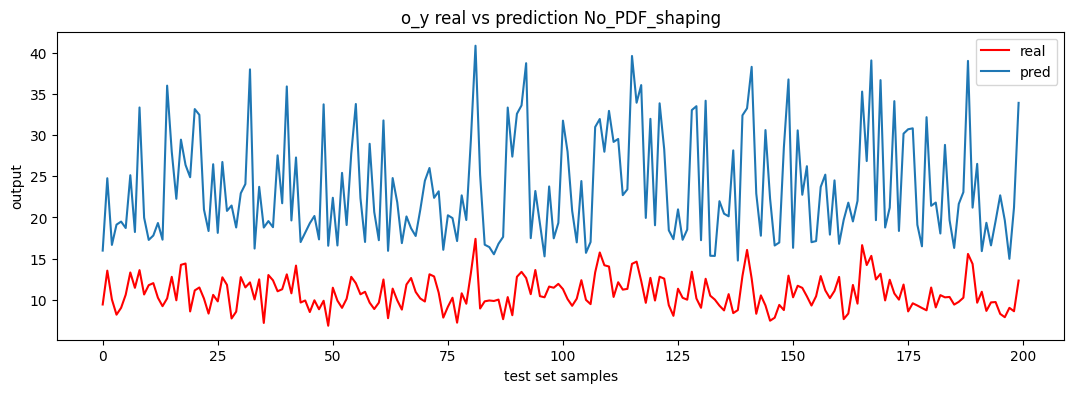

/Users/user/Desktop/DOE_CIVS/experiments/2023april/PDFshapingUtils.py:339: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


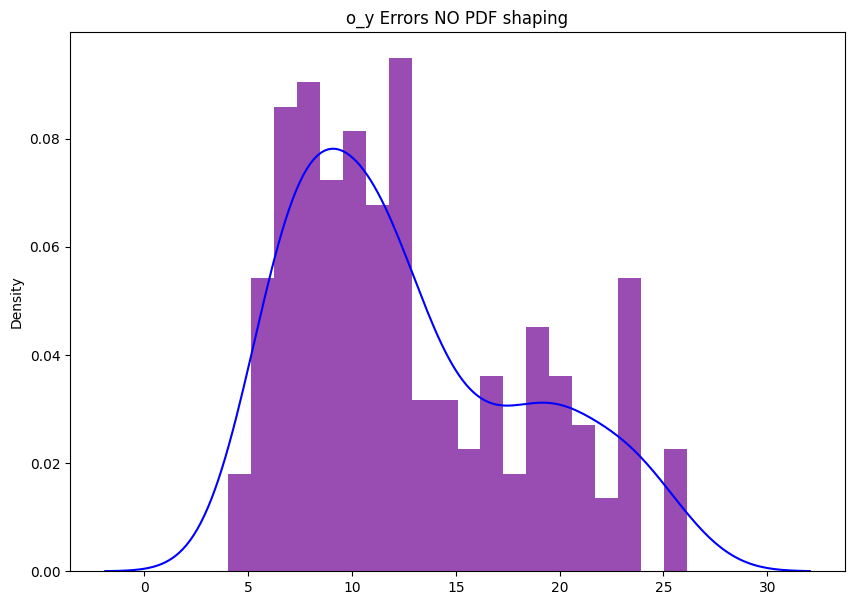

In [29]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )


## Results for g(x) = F1(x) + F2(x) with PDF shaping

F1 = Linear

F2 = Nonlinear

In [30]:

def fit_y_scaled_PDF(num_epochs, num_epochs_pdf, model, loss_fn, opt, modelSigma, opt_sigma):
    
    PDFshapingOBJ.list_metric = []
    
    PDFshapingOBJ.initializeSigmaVector()
   
    
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
        
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()  )
        ))
        PDFshapingOBJ.list_metric.append(r2_avg.detach().numpy())
        
        
    ## opt = torch.optim.Adam(   model.parameters(), lr=learning_rate_pdfcontrol   )    
        
    for epoch in range(num_epochs_pdf):
        
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        pred_sigma_vector = modelSigma(  PDFshapingOBJ.x_range_impulse_func  )
        PDFshapingOBJ.sigma_func_vector_vals = pred_sigma_vector
        
        error     = pred_scaled.float() - PDFshapingOBJ.y_train_tr_scaled.float()        ## 524  X 6
        basisFunc = PDFshapingOBJ.train_multiple_kernels_per_output( error )         ## 4000 x 6
        
        diff = ( basisFunc.float() - PDFshapingOBJ.impulse_func_vector_vals.unsqueeze(1).float() )  ## 4000 x 6

        ## diff = diff * PDFshapingOBJ.sigma_func_vector_vals.unsqueeze(1)   ## sigma weightinng const
        ## diff = diff * pred_sigma_vector.unsqueeze(1)                         ## 4000 x 1 NN sigma weightinng
        ## diff = diff * pred_sigma_vector.reshape((4000,6))                 ## 4000 x 6 NN sigma weightinng
        
        
        loss = torch.mean(   (   diff  )**2    )  
        loss.backward()
        
        opt.step()
        opt.zero_grad()
        
        opt_sigma.step()
        opt_sigma.zero_grad()
        
  
        print(epoch, " loss= ", loss)
        if epoch % 200 == 0:
            print(error.shape)
            print(basisFunc.shape)
            PDFshapingOBJ.print_errors_kdes(  error, basisFunc )
            print(PDFshapingOBJ.impulse_func_vector_vals.shape)
      

        r2_avg = torch.mean(torch.tensor(
                 r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()  )
        ))
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
        
        
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,       PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy() ))
    

In [31]:
PDFshapingOBJ.the_string           = "With_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "shaft"

0  loss=  tensor(84.9074, grad_fn=<MseLossBackward0>)
0  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([4000, 1])


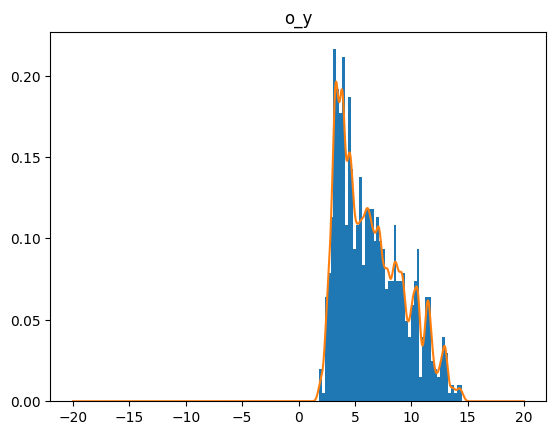

torch.Size([4000])
1  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
8  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
10  loss=  tensor(0.0735, grad_fn=<MeanBackward0>)
11  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
12  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
13  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
14  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
15  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
16  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
17  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
18  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
19  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
20  loss=  tensor(0.0

169  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
170  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
171  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
172  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
173  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
174  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
175  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
176  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
177  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
178  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
179  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
180  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
181  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
182  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
183  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
184  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
185  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
186  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
187  loss=  tensor(0.0735, grad_fn=<MeanBackward0>)
188  loss=  

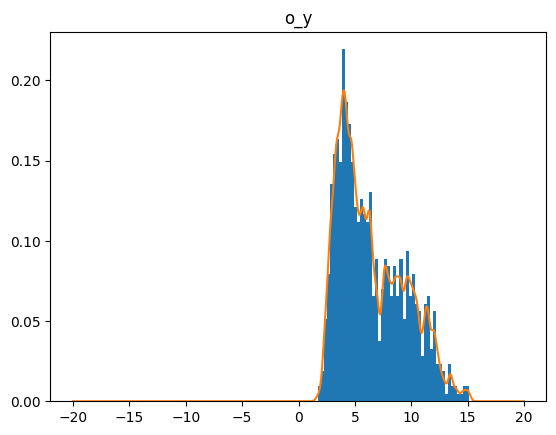

torch.Size([4000])
201  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
202  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
203  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
204  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
205  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
206  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
207  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
208  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
209  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
210  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
211  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
212  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
213  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
214  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
215  loss=  tensor(0.0735, grad_fn=<MeanBackward0>)
216  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
217  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
218  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
219  loss=  tensor(0.0733, grad_fn=<MeanBackw

368  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
369  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
370  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
371  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
372  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
373  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
374  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
375  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
376  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
377  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
378  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
379  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
380  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
381  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
382  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
383  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
384  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
385  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
386  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
387  loss=  

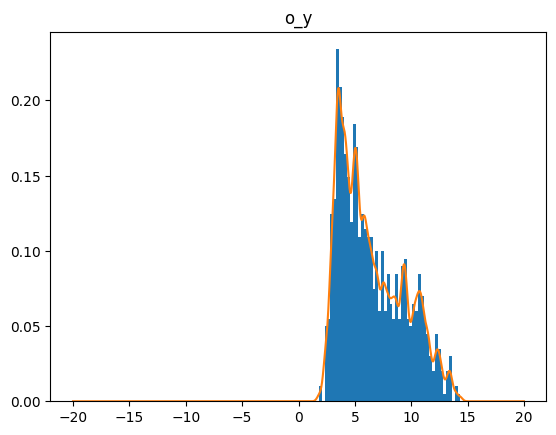

torch.Size([4000])
401  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
402  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
403  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
404  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
405  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
406  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
407  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
408  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
409  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
410  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
411  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
412  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
413  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
414  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
415  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
416  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
417  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
418  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
419  loss=  tensor(0.0733, grad_fn=<MeanBackw

560  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
561  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
562  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
563  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
564  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
565  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
566  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
567  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
568  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
569  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
570  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
571  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
572  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
573  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
574  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
575  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
576  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
577  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
578  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
579  loss=  

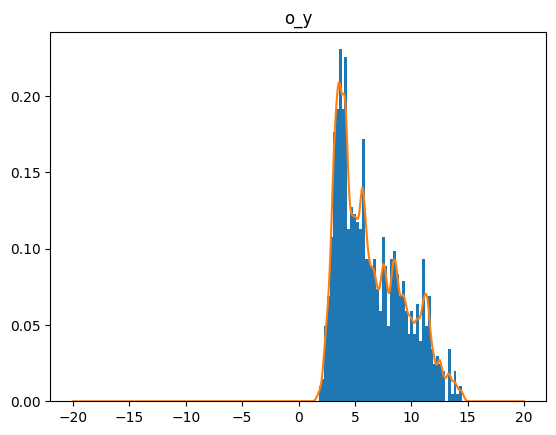

torch.Size([4000])
601  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
602  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
603  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
604  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
605  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
606  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
607  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
608  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
609  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
610  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
611  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
612  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
613  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
614  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
615  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
616  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
617  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
618  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
619  loss=  tensor(0.0733, grad_fn=<MeanBackw

766  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
767  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
768  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
769  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
770  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
771  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
772  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
773  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
774  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
775  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
776  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
777  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
778  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
779  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
780  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
781  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
782  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
783  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
784  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
785  loss=  

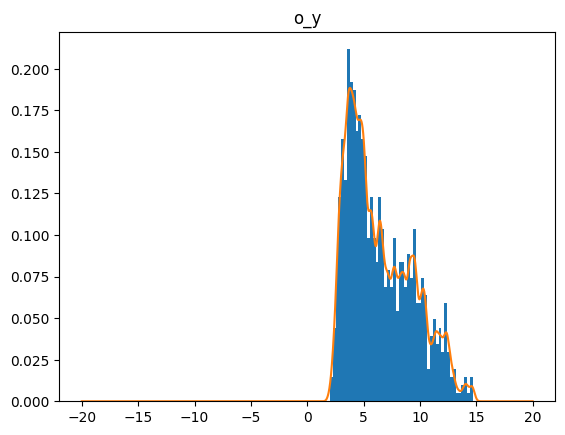

torch.Size([4000])
801  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
802  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
803  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
804  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
805  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
806  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
807  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
808  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
809  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
810  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
811  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
812  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
813  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
814  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
815  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
816  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
817  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
818  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
819  loss=  tensor(0.0734, grad_fn=<MeanBackw

960  loss=  tensor(0.0735, grad_fn=<MeanBackward0>)
961  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
962  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
963  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
964  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
965  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
966  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
967  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
968  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
969  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
970  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
971  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
972  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
973  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
974  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
975  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
976  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
977  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
978  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
979  loss=  

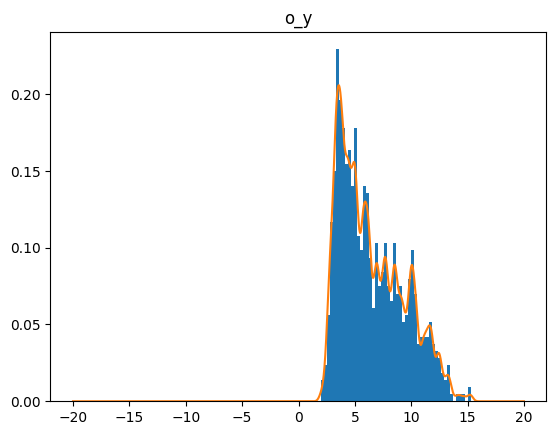

torch.Size([4000])
1001  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1002  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1003  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1004  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1005  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1006  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1007  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1008  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1009  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1010  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1011  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1012  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1013  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1014  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1015  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1016  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1017  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1018  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1019  loss=  tensor(0.0733,

1160  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1161  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1162  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1163  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1164  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1165  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1166  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1167  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1168  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1169  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1170  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1171  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1172  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1173  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
1174  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1175  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1176  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1177  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1178  loss=  tensor(0.0734, grad_fn=<MeanBackw

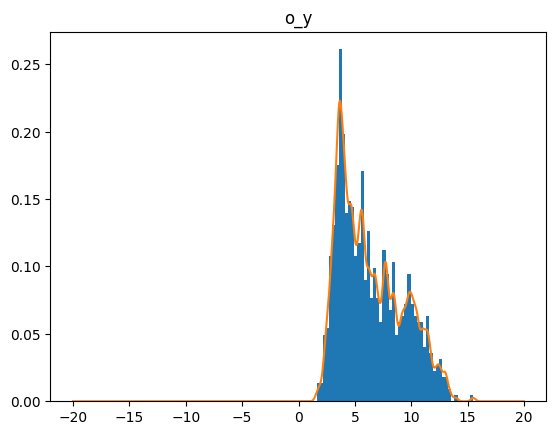

torch.Size([4000])
1201  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1202  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1203  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1204  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1205  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1206  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1207  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1208  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1209  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1210  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1211  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1212  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1213  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1214  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1215  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1216  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1217  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1218  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1219  loss=  tensor(0.0734,

1360  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1361  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1362  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1363  loss=  tensor(0.0735, grad_fn=<MeanBackward0>)
1364  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1365  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1366  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1367  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1368  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1369  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
1370  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1371  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1372  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1373  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1374  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1375  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1376  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1377  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
1378  loss=  tensor(0.0732, grad_fn=<MeanBackw

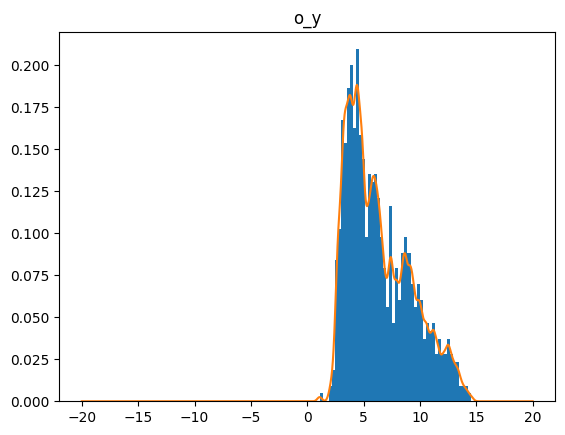

torch.Size([4000])
1401  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1402  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1403  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1404  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1405  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1406  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1407  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1408  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1409  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1410  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1411  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1412  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1413  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1414  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1415  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1416  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1417  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1418  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1419  loss=  tensor(0.0734,

1558  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1559  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1560  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1561  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1562  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1563  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1564  loss=  tensor(0.0735, grad_fn=<MeanBackward0>)
1565  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1566  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1567  loss=  tensor(0.0735, grad_fn=<MeanBackward0>)
1568  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1569  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1570  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1571  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1572  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1573  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1574  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1575  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1576  loss=  tensor(0.0734, grad_fn=<MeanBackw

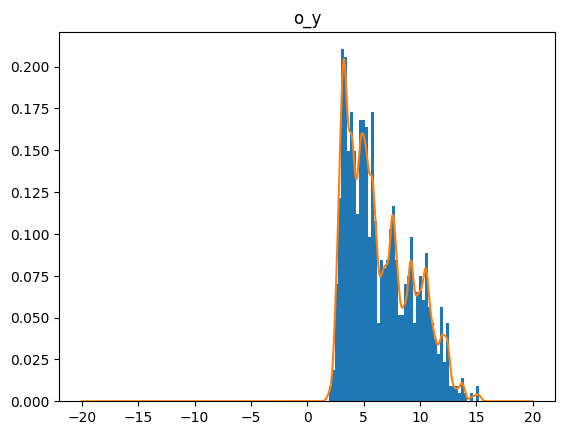

torch.Size([4000])
1601  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1602  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1603  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1604  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1605  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1606  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1607  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1608  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1609  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1610  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1611  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1612  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1613  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1614  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1615  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1616  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1617  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1618  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1619  loss=  tensor(0.0733,

1762  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1763  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1764  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1765  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1766  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1767  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1768  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1769  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1770  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1771  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1772  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1773  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1774  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1775  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1776  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1777  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1778  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1779  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1780  loss=  tensor(0.0733, grad_fn=<MeanBackw

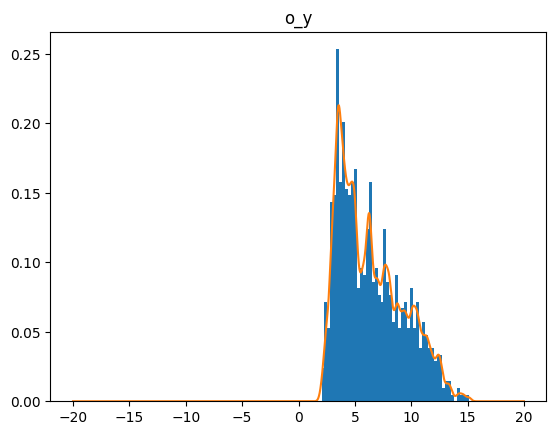

torch.Size([4000])
1801  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1802  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1803  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1804  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1805  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1806  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1807  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1808  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1809  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1810  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1811  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1812  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1813  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1814  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1815  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1816  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1817  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1818  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1819  loss=  tensor(0.0733,

1956  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1957  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1958  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1959  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1960  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1961  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1962  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1963  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1964  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1965  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1966  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1967  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1968  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1969  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1970  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1971  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1972  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
1973  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
1974  loss=  tensor(0.0733, grad_fn=<MeanBackw

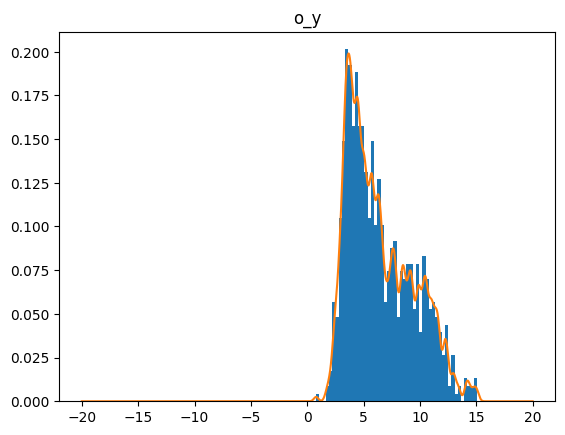

torch.Size([4000])
2001  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2002  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2003  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2004  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2005  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2006  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2007  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2008  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2009  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2010  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2011  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2012  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2013  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2014  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2015  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2016  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2017  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2018  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2019  loss=  tensor(0.0733,

2157  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2158  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2159  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2160  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2161  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2162  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2163  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2164  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2165  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2166  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2167  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2168  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2169  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2170  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2171  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2172  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2173  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2174  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2175  loss=  tensor(0.0733, grad_fn=<MeanBackw

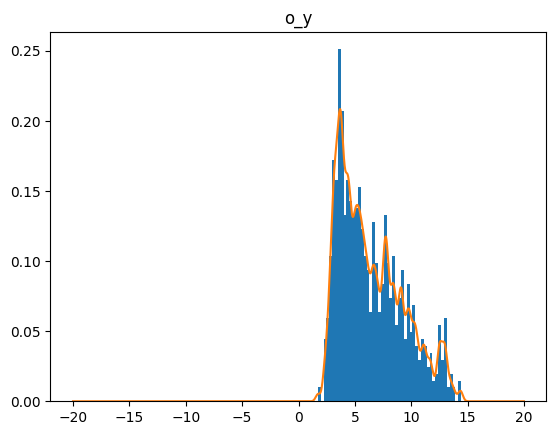

torch.Size([4000])
2201  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2202  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2203  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2204  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2205  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2206  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2207  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2208  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2209  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2210  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2211  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2212  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2213  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2214  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2215  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2216  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2217  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2218  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2219  loss=  tensor(0.0732,

2363  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2364  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2365  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2366  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2367  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2368  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2369  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2370  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2371  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2372  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2373  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2374  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2375  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2376  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2377  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2378  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2379  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2380  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2381  loss=  tensor(0.0733, grad_fn=<MeanBackw

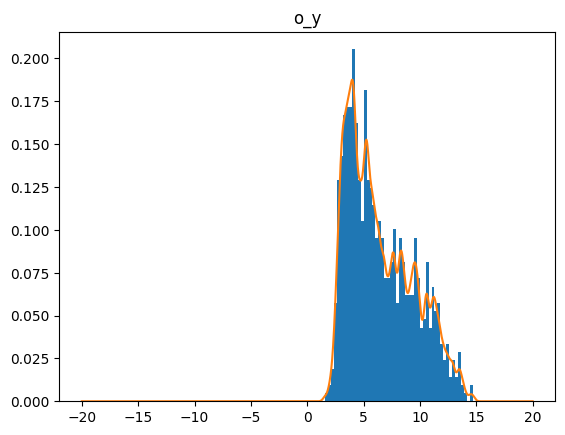

torch.Size([4000])
2401  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2402  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2403  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2404  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2405  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2406  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2407  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2408  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2409  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2410  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2411  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2412  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2413  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2414  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2415  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2416  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2417  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2418  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2419  loss=  tensor(0.0734,

2562  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2563  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2564  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2565  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2566  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2567  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
2568  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2569  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2570  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2571  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2572  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2573  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2574  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2575  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2576  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2577  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2578  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2579  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2580  loss=  tensor(0.0733, grad_fn=<MeanBackw

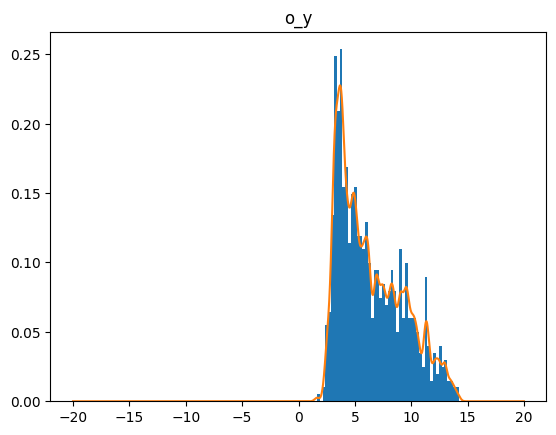

torch.Size([4000])
2601  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2602  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2603  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2604  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2605  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2606  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2607  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2608  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2609  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2610  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2611  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2612  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2613  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2614  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2615  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2616  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2617  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2618  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2619  loss=  tensor(0.0734,

2758  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2759  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2760  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2761  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2762  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2763  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2764  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2765  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2766  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2767  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2768  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2769  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2770  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2771  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2772  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2773  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2774  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2775  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2776  loss=  tensor(0.0734, grad_fn=<MeanBackw

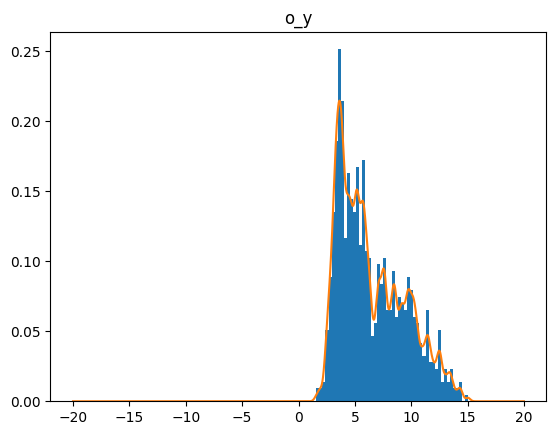

torch.Size([4000])
2801  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2802  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2803  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2804  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2805  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2806  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2807  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2808  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2809  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2810  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2811  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2812  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2813  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2814  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2815  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2816  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2817  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2818  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2819  loss=  tensor(0.0733,

2963  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2964  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2965  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2966  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2967  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2968  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2969  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2970  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2971  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2972  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2973  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2974  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
2975  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2976  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2977  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2978  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2979  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2980  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
2981  loss=  tensor(0.0733, grad_fn=<MeanBackw

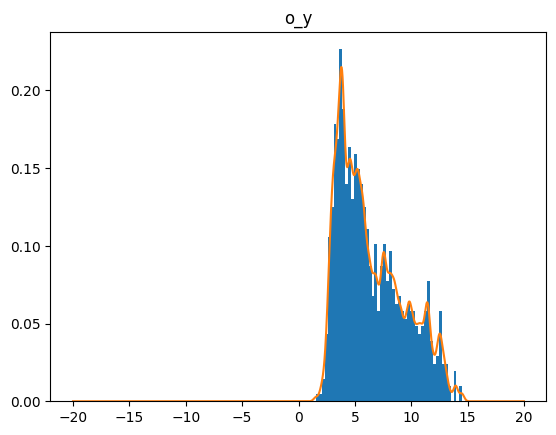

torch.Size([4000])
3001  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3002  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3003  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3004  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3005  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3006  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3007  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3008  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3009  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3010  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3011  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3012  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3013  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3014  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3015  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3016  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3017  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3018  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3019  loss=  tensor(0.0734,

3160  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3161  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3162  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3163  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3164  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3165  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3166  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3167  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3168  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3169  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3170  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3171  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3172  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3173  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3174  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3175  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3176  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3177  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3178  loss=  tensor(0.0734, grad_fn=<MeanBackw

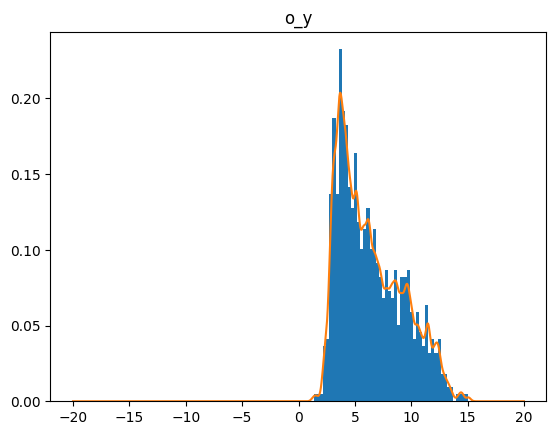

torch.Size([4000])
3201  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3202  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3203  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3204  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3205  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3206  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3207  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3208  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3209  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3210  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3211  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
3212  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3213  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3214  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3215  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3216  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3217  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3218  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3219  loss=  tensor(0.0733,

3360  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3361  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3362  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3363  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3364  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3365  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3366  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3367  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3368  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3369  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3370  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3371  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3372  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3373  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3374  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3375  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3376  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3377  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3378  loss=  tensor(0.0734, grad_fn=<MeanBackw

torch.Size([4000])
3401  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3402  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3403  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3404  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3405  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3406  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3407  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3408  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3409  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3410  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3411  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3412  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3413  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3414  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3415  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3416  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3417  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3418  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3419  loss=  tensor(0.0733,

3556  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3557  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3558  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3559  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3560  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3561  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3562  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3563  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3564  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3565  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3566  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3567  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3568  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3569  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3570  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3571  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3572  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3573  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3574  loss=  tensor(0.0734, grad_fn=<MeanBackw

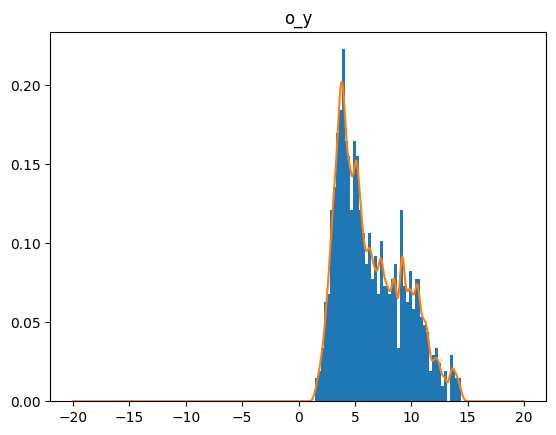

torch.Size([4000])
3601  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
3602  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3603  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3604  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3605  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3606  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3607  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3608  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3609  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3610  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3611  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3612  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3613  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3614  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3615  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3616  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3617  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3618  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
3619  loss=  tensor(0.0733,

3760  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3761  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3762  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3763  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3764  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3765  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3766  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3767  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3768  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3769  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3770  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3771  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3772  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3773  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3774  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3775  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3776  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3777  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3778  loss=  tensor(0.0733, grad_fn=<MeanBackw

torch.Size([4000])
3801  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3802  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3803  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3804  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3805  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3806  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3807  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3808  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3809  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3810  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3811  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3812  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3813  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3814  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3815  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3816  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3817  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3818  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3819  loss=  tensor(0.0733,

3960  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3961  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3962  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3963  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3964  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3965  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3966  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3967  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3968  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3969  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3970  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3971  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3972  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3973  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
3974  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3975  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3976  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3977  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
3978  loss=  tensor(0.0733, grad_fn=<MeanBackw

torch.Size([4000])
4001  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4002  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4003  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4004  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4005  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4006  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4007  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4008  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4009  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4010  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4011  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4012  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4013  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4014  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4015  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4016  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4017  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4018  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4019  loss=  tensor(0.0733,

4156  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4157  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4158  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4159  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4160  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4161  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4162  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4163  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4164  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4165  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4166  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4167  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4168  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4169  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
4170  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4171  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4172  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4173  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4174  loss=  tensor(0.0733, grad_fn=<MeanBackw

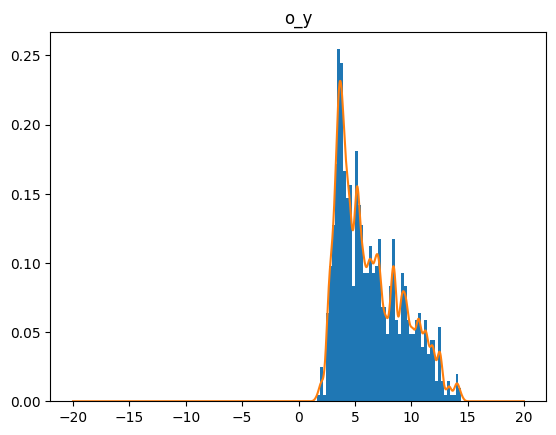

torch.Size([4000])
4201  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4202  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4203  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4204  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4205  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4206  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
4207  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4208  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4209  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4210  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4211  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4212  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4213  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4214  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4215  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4216  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
4217  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4218  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4219  loss=  tensor(0.0733,

4359  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4360  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4361  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4362  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4363  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4364  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4365  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4366  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4367  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4368  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4369  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4370  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4371  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4372  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4373  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4374  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4375  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4376  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4377  loss=  tensor(0.0734, grad_fn=<MeanBackw

torch.Size([4000])
4401  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4402  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4403  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4404  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4405  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4406  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4407  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4408  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4409  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4410  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4411  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4412  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4413  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4414  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
4415  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4416  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4417  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4418  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4419  loss=  tensor(0.0733,

4565  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4566  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4567  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4568  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4569  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4570  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4571  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4572  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4573  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4574  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4575  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4576  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4577  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4578  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4579  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4580  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4581  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4582  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4583  loss=  tensor(0.0733, grad_fn=<MeanBackw

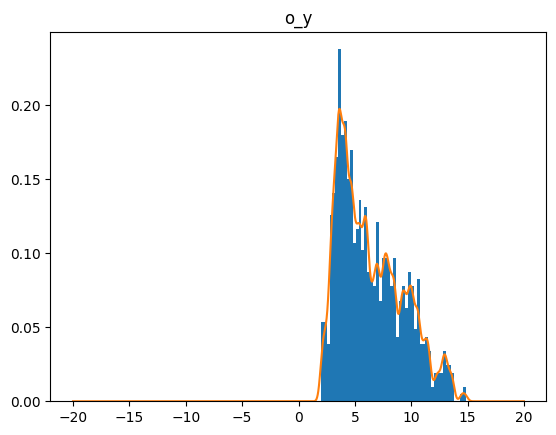

torch.Size([4000])
4601  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4602  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4603  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
4604  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4605  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4606  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4607  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4608  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4609  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4610  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4611  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4612  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4613  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4614  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4615  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4616  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4617  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4618  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4619  loss=  tensor(0.0733,

4764  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4765  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4766  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4767  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4768  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4769  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4770  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4771  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4772  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4773  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4774  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4775  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4776  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
4777  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4778  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4779  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4780  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4781  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4782  loss=  tensor(0.0733, grad_fn=<MeanBackw

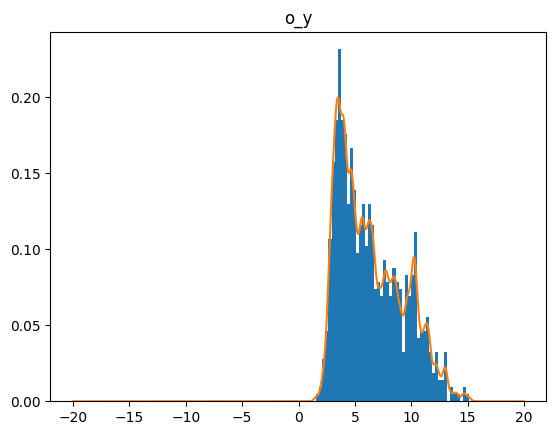

torch.Size([4000])
4801  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4802  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4803  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4804  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4805  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4806  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4807  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4808  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4809  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4810  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4811  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4812  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4813  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4814  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4815  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4816  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4817  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4818  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4819  loss=  tensor(0.0733,

4960  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4961  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4962  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4963  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4964  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4965  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4966  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4967  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4968  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4969  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4970  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4971  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4972  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4973  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4974  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
4975  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4976  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4977  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
4978  loss=  tensor(0.0734, grad_fn=<MeanBackw

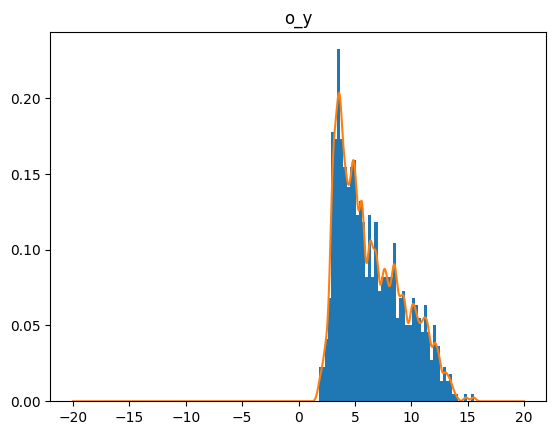

torch.Size([4000])
5001  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5002  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5003  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5004  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5005  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5006  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5007  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5008  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5009  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5010  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5011  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5012  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5013  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5014  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5015  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5016  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5017  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5018  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5019  loss=  tensor(0.0733,

5159  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5160  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5161  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5162  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5163  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5164  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5165  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5166  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5167  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5168  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5169  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5170  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5171  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5172  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5173  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5174  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5175  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5176  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5177  loss=  tensor(0.0734, grad_fn=<MeanBackw

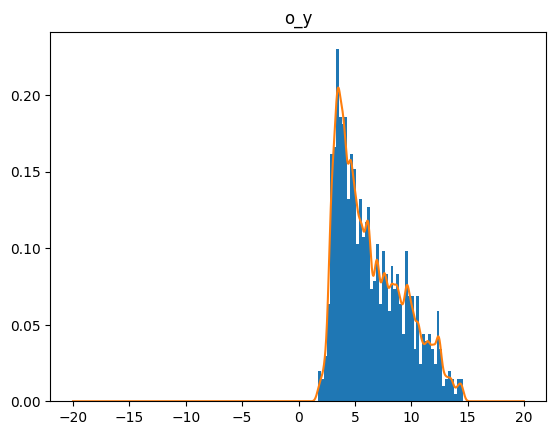

torch.Size([4000])
5201  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5202  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5203  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5204  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5205  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5206  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5207  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5208  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5209  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5210  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5211  loss=  tensor(0.0735, grad_fn=<MeanBackward0>)
5212  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5213  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5214  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5215  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5216  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5217  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
5218  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5219  loss=  tensor(0.0733,

5357  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5358  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5359  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5360  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5361  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5362  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5363  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5364  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5365  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5366  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
5367  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5368  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5369  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5370  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5371  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5372  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5373  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5374  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5375  loss=  tensor(0.0733, grad_fn=<MeanBackw

torch.Size([4000])
5401  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5402  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5403  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
5404  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5405  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5406  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5407  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
5408  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5409  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5410  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5411  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5412  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5413  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5414  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5415  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
5416  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5417  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5418  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5419  loss=  tensor(0.0733,

5559  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5560  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5561  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
5562  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5563  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5564  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5565  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5566  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5567  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5568  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5569  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5570  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5571  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5572  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5573  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5574  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5575  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5576  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5577  loss=  tensor(0.0733, grad_fn=<MeanBackw

torch.Size([4000])
5601  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5602  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5603  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5604  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5605  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5606  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5607  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5608  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5609  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5610  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5611  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5612  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5613  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
5614  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5615  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
5616  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5617  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5618  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5619  loss=  tensor(0.0733,

5756  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5757  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5758  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5759  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5760  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5761  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5762  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5763  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5764  loss=  tensor(0.0735, grad_fn=<MeanBackward0>)
5765  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5766  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5767  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5768  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5769  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5770  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5771  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5772  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5773  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5774  loss=  tensor(0.0734, grad_fn=<MeanBackw

torch.Size([4000])
5801  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5802  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5803  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5804  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5805  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5806  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5807  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5808  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
5809  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5810  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5811  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5812  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5813  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5814  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5815  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5816  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5817  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5818  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5819  loss=  tensor(0.0733,

5957  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5958  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
5959  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5960  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5961  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5962  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5963  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5964  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5965  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5966  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
5967  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5968  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
5969  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5970  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
5971  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5972  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5973  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5974  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
5975  loss=  tensor(0.0733, grad_fn=<MeanBackw

torch.Size([4000])
6001  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6002  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6003  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6004  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6005  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6006  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6007  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6008  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6009  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6010  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6011  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6012  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6013  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6014  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6015  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6016  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6017  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6018  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6019  loss=  tensor(0.0733,

6158  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6159  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6160  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6161  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6162  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6163  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6164  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6165  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6166  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6167  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6168  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6169  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6170  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6171  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6172  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6173  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6174  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6175  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6176  loss=  tensor(0.0734, grad_fn=<MeanBackw

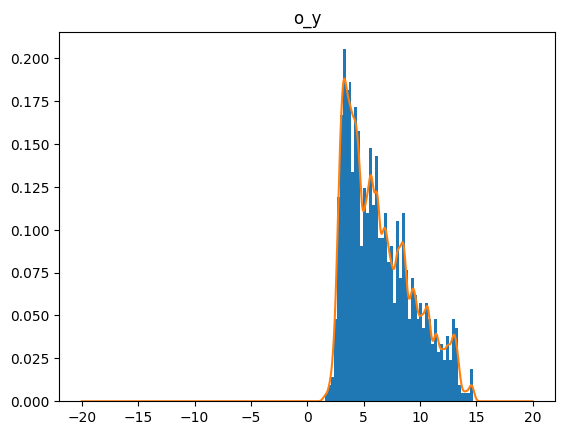

torch.Size([4000])
6201  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6202  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6203  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6204  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6205  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6206  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6207  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6208  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6209  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6210  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6211  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6212  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6213  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6214  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6215  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6216  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6217  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6218  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6219  loss=  tensor(0.0733,

6362  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6363  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6364  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6365  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6366  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6367  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6368  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6369  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6370  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6371  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6372  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6373  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6374  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6375  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6376  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6377  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6378  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6379  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6380  loss=  tensor(0.0733, grad_fn=<MeanBackw

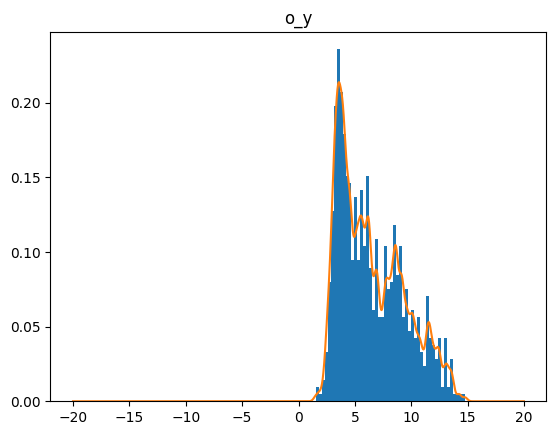

torch.Size([4000])
6401  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6402  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6403  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6404  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6405  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6406  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6407  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6408  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6409  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6410  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6411  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6412  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6413  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6414  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6415  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6416  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6417  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6418  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6419  loss=  tensor(0.0733,

6561  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6562  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6563  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6564  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6565  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6566  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6567  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6568  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6569  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6570  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6571  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6572  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6573  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6574  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6575  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6576  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6577  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6578  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6579  loss=  tensor(0.0733, grad_fn=<MeanBackw

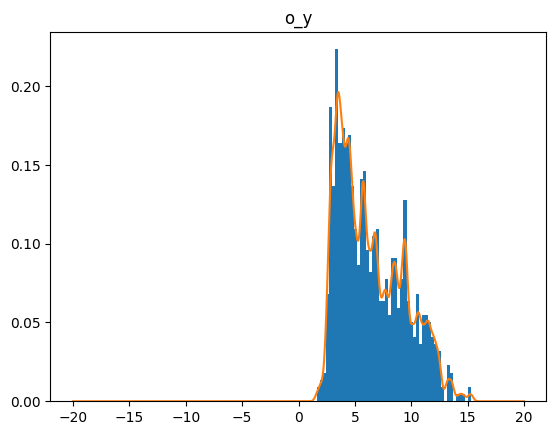

torch.Size([4000])
6601  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6602  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6603  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6604  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6605  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6606  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6607  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6608  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6609  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6610  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6611  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6612  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6613  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6614  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6615  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6616  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6617  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6618  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6619  loss=  tensor(0.0733,

6757  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6758  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6759  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6760  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6761  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6762  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6763  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6764  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6765  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6766  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6767  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6768  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6769  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6770  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6771  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6772  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6773  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6774  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6775  loss=  tensor(0.0733, grad_fn=<MeanBackw

torch.Size([4000])
6801  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6802  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6803  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6804  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6805  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6806  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6807  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6808  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6809  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6810  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6811  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6812  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6813  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6814  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6815  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6816  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6817  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6818  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6819  loss=  tensor(0.0733,

6960  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6961  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
6962  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6963  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6964  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6965  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6966  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6967  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6968  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6969  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6970  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6971  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6972  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6973  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
6974  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6975  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6976  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6977  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
6978  loss=  tensor(0.0733, grad_fn=<MeanBackw

torch.Size([4000])
7001  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7002  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7003  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7004  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7005  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7006  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7007  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7008  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7009  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7010  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7011  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7012  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7013  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7014  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7015  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7016  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7017  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7018  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7019  loss=  tensor(0.0732,

7160  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7161  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7162  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7163  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7164  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7165  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7166  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7167  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7168  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7169  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7170  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7171  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7172  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7173  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7174  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7175  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7176  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7177  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7178  loss=  tensor(0.0732, grad_fn=<MeanBackw

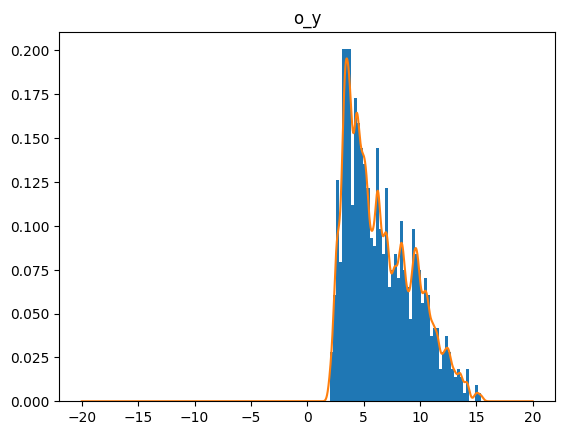

torch.Size([4000])
7201  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7202  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7203  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7204  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7205  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7206  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7207  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7208  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7209  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7210  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7211  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7212  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7213  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7214  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7215  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7216  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7217  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7218  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7219  loss=  tensor(0.0734,

7358  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7359  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7360  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7361  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7362  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7363  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7364  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7365  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7366  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7367  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7368  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7369  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7370  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7371  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7372  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7373  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7374  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7375  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7376  loss=  tensor(0.0733, grad_fn=<MeanBackw

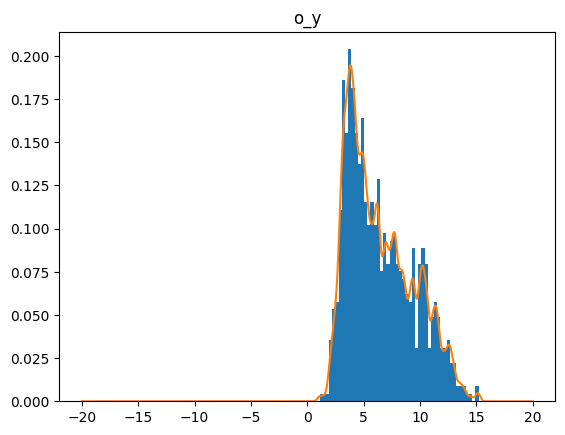

torch.Size([4000])
7401  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7402  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7403  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7404  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7405  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7406  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7407  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7408  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7409  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7410  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7411  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7412  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7413  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7414  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7415  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7416  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7417  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7418  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7419  loss=  tensor(0.0733,

7560  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7561  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7562  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7563  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7564  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7565  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7566  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7567  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7568  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7569  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7570  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7571  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7572  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7573  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7574  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7575  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7576  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7577  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7578  loss=  tensor(0.0733, grad_fn=<MeanBackw

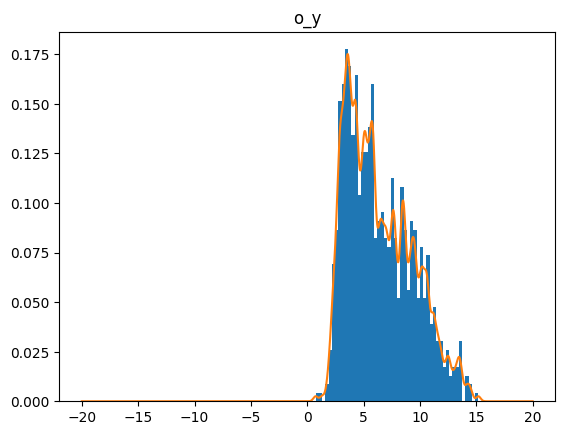

torch.Size([4000])
7601  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7602  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7603  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7604  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7605  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7606  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7607  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7608  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7609  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7610  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7611  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7612  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7613  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7614  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7615  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7616  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7617  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7618  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7619  loss=  tensor(0.0733,

7760  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7761  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7762  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7763  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7764  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7765  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7766  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7767  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7768  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7769  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7770  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7771  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7772  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7773  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7774  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7775  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7776  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7777  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7778  loss=  tensor(0.0733, grad_fn=<MeanBackw

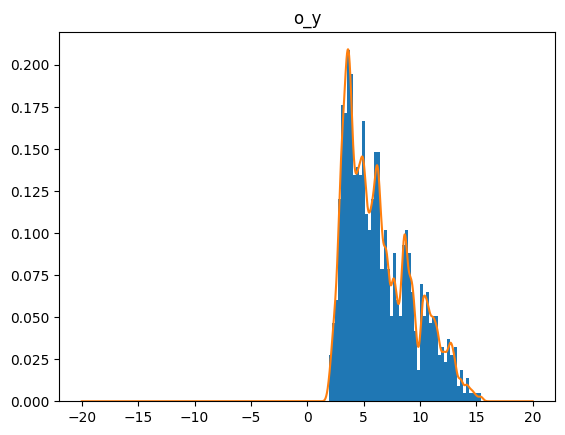

torch.Size([4000])
7801  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7802  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7803  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7804  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7805  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7806  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7807  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7808  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7809  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7810  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7811  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7812  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7813  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7814  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7815  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7816  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7817  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7818  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7819  loss=  tensor(0.0733,

7960  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7961  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7962  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7963  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7964  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7965  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7966  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7967  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7968  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7969  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
7970  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7971  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7972  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
7973  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7974  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7975  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7976  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7977  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
7978  loss=  tensor(0.0733, grad_fn=<MeanBackw

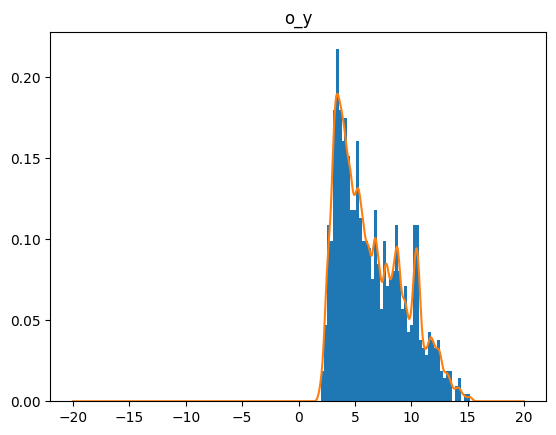

torch.Size([4000])
8001  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8002  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8003  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8004  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8005  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8006  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8007  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8008  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8009  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8010  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
8011  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8012  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8013  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8014  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8015  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8016  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8017  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8018  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8019  loss=  tensor(0.0733,

8160  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8161  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8162  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8163  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8164  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
8165  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8166  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8167  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8168  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8169  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8170  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8171  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8172  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8173  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8174  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
8175  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8176  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8177  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8178  loss=  tensor(0.0733, grad_fn=<MeanBackw

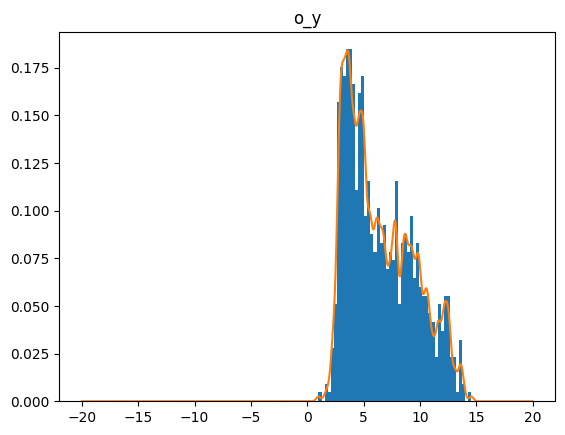

torch.Size([4000])
8201  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8202  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8203  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8204  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8205  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8206  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8207  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8208  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8209  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8210  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8211  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8212  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8213  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8214  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8215  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8216  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8217  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8218  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8219  loss=  tensor(0.0732,

8360  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8361  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8362  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8363  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8364  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8365  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8366  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8367  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8368  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8369  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8370  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8371  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8372  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8373  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8374  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8375  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8376  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8377  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8378  loss=  tensor(0.0733, grad_fn=<MeanBackw

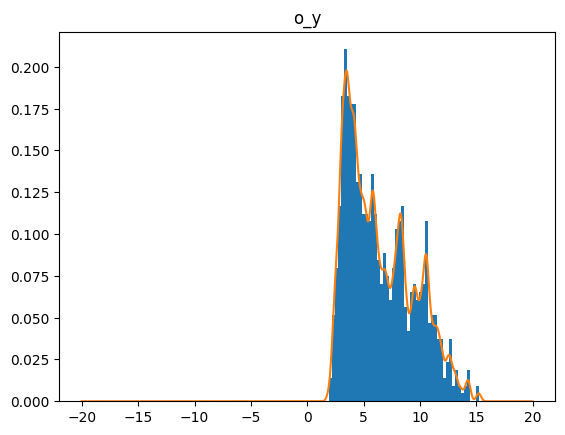

torch.Size([4000])
8401  loss=  tensor(0.0734, grad_fn=<MeanBackward0>)
8402  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8403  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8404  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8405  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
8406  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8407  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8408  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8409  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8410  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8411  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8412  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8413  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8414  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8415  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8416  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8417  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8418  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8419  loss=  tensor(0.0732,

8561  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8562  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8563  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8564  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8565  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8566  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8567  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8568  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8569  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8570  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8571  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8572  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8573  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8574  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8575  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8576  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8577  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8578  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8579  loss=  tensor(0.0733, grad_fn=<MeanBackw

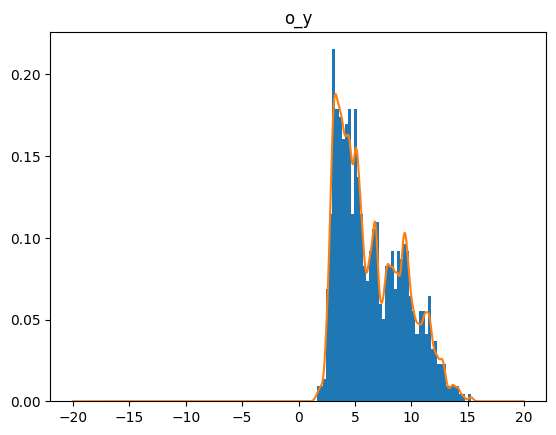

torch.Size([4000])
8601  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8602  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8603  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8604  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8605  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8606  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8607  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8608  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8609  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8610  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8611  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8612  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8613  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8614  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8615  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8616  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8617  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8618  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8619  loss=  tensor(0.0733,

8759  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8760  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8761  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8762  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8763  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8764  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8765  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8766  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8767  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8768  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8769  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8770  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8771  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8772  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8773  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8774  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8775  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8776  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
8777  loss=  tensor(0.0733, grad_fn=<MeanBackw

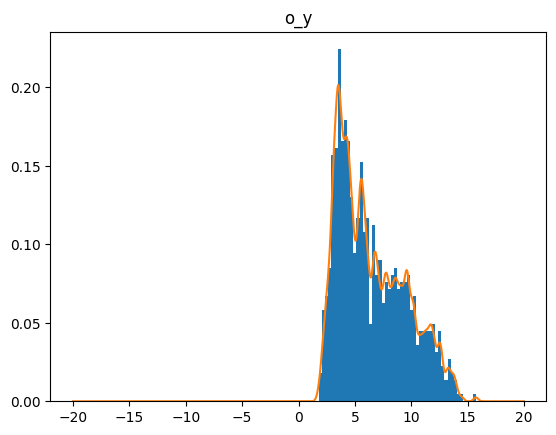

torch.Size([4000])
8801  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8802  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8803  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8804  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8805  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8806  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8807  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8808  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8809  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8810  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8811  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8812  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8813  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8814  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8815  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8816  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8817  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8818  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8819  loss=  tensor(0.0734,

8961  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8962  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8963  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8964  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8965  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
8966  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8967  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8968  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8969  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8970  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8971  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8972  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8973  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8974  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8975  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8976  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8977  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
8978  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
8979  loss=  tensor(0.0732, grad_fn=<MeanBackw

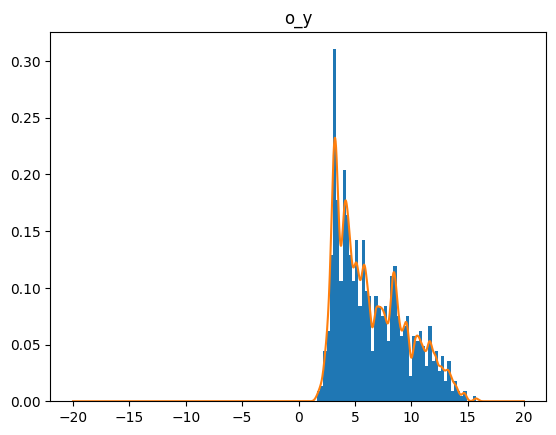

torch.Size([4000])
9001  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9002  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9003  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9004  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9005  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9006  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9007  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9008  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9009  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9010  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9011  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9012  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9013  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9014  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9015  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9016  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9017  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9018  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9019  loss=  tensor(0.0732,

9160  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9161  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9162  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9163  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9164  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9165  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9166  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9167  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9168  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9169  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9170  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9171  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9172  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9173  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9174  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9175  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9176  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9177  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9178  loss=  tensor(0.0732, grad_fn=<MeanBackw

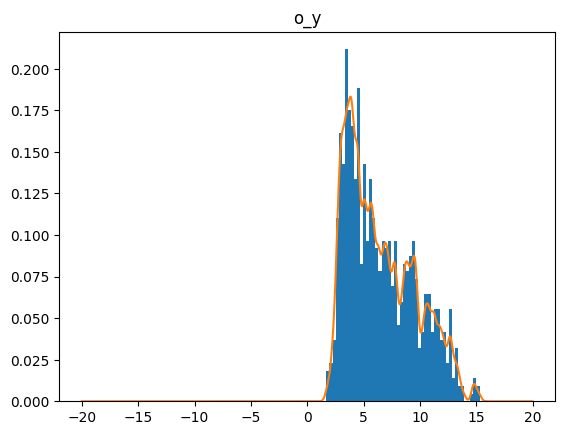

torch.Size([4000])
9201  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9202  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9203  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9204  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9205  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9206  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9207  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9208  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9209  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9210  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9211  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9212  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9213  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9214  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9215  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9216  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9217  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9218  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9219  loss=  tensor(0.0732,

9360  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9361  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9362  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9363  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9364  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9365  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9366  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9367  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9368  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9369  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9370  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9371  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9372  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9373  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9374  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9375  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9376  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9377  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9378  loss=  tensor(0.0732, grad_fn=<MeanBackw

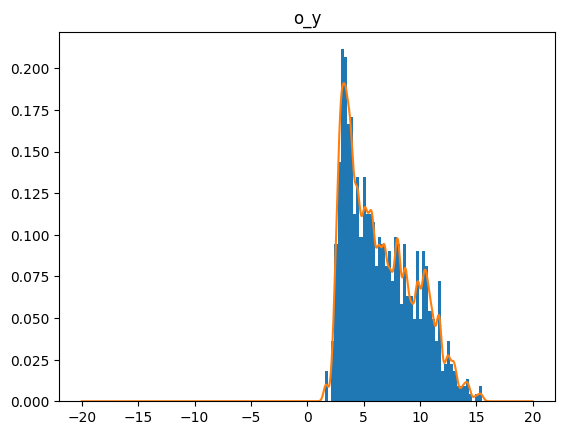

torch.Size([4000])
9401  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9402  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9403  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9404  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9405  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9406  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9407  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9408  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9409  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9410  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9411  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9412  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9413  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9414  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9415  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9416  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9417  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9418  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9419  loss=  tensor(0.0732,

9558  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9559  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9560  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9561  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9562  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9563  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9564  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9565  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9566  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9567  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9568  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9569  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9570  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9571  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9572  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9573  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9574  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9575  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9576  loss=  tensor(0.0732, grad_fn=<MeanBackw

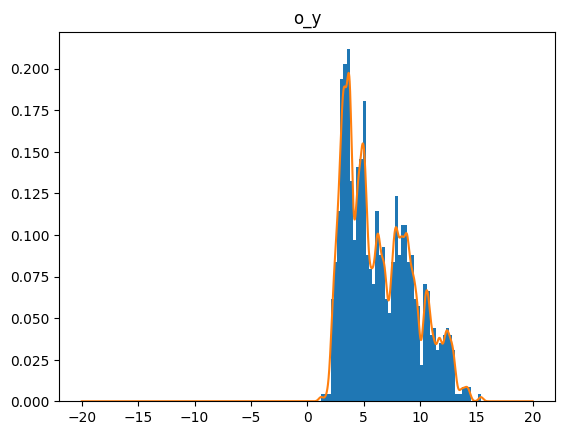

torch.Size([4000])
9601  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9602  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9603  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9604  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9605  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9606  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9607  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9608  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9609  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9610  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9611  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9612  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9613  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9614  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9615  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9616  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9617  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9618  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9619  loss=  tensor(0.0732,

9761  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9762  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9763  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9764  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9765  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9766  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9767  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9768  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9769  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9770  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9771  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9772  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9773  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9774  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9775  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9776  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9777  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9778  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9779  loss=  tensor(0.0732, grad_fn=<MeanBackw

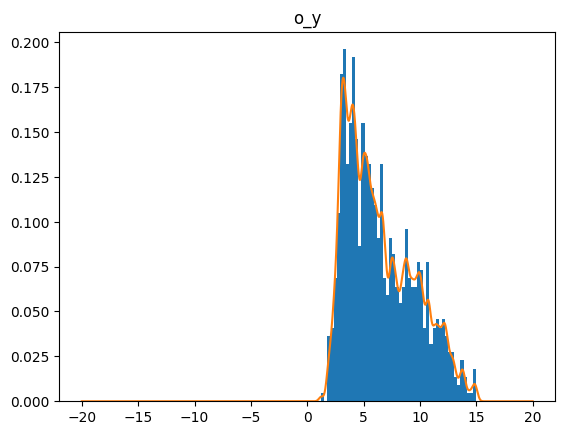

torch.Size([4000])
9801  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9802  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9803  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9804  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9805  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9806  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9807  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9808  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9809  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9810  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9811  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
9812  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9813  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9814  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9815  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9816  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9817  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9818  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9819  loss=  tensor(0.0732,

9965  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9966  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9967  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9968  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9969  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9970  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9971  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9972  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9973  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9974  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9975  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9976  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9977  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9978  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9979  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9980  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
9981  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9982  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
9983  loss=  tensor(0.0732, grad_fn=<MeanBackw

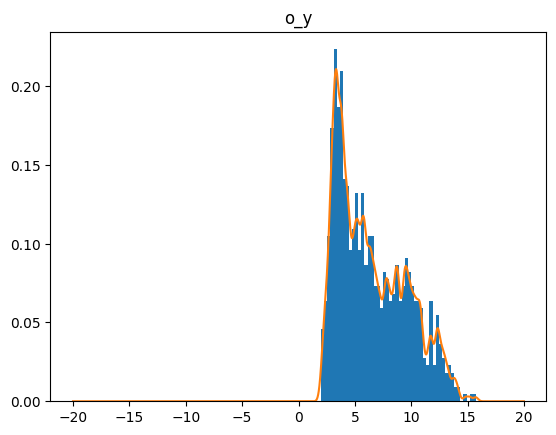

torch.Size([4000])
10001  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10002  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10003  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10004  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10005  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10006  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10007  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10008  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10009  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10010  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10011  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10012  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10013  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10014  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10015  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10016  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10017  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10018  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10019  lo

10153  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10154  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10155  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10156  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10157  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10158  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10159  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10160  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10161  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10162  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10163  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10164  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
10165  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10166  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10167  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10168  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10169  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
10170  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10171  loss=  tensor(0.0732,

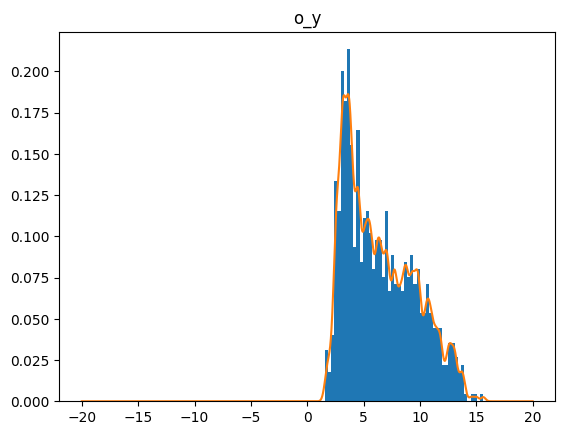

torch.Size([4000])
10201  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10202  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10203  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10204  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10205  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10206  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10207  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10208  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10209  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10210  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10211  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10212  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10213  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10214  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10215  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10216  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10217  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10218  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10219  lo

10354  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10355  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10356  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10357  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10358  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10359  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10360  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10361  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10362  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10363  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10364  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10365  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10366  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10367  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10368  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10369  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10370  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10371  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10372  loss=  tensor(0.0732,

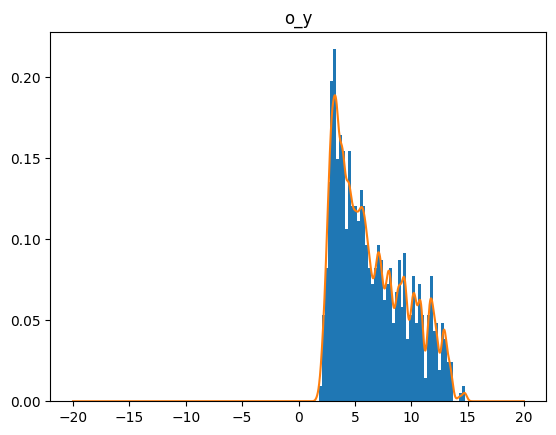

torch.Size([4000])
10401  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10402  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
10403  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10404  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10405  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10406  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10407  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10408  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10409  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10410  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10411  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10412  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10413  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10414  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10415  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10416  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10417  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10418  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10419  lo

10553  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10554  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10555  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10556  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10557  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10558  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10559  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10560  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10561  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10562  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10563  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10564  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10565  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10566  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
10567  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10568  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10569  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10570  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10571  loss=  tensor(0.0732,

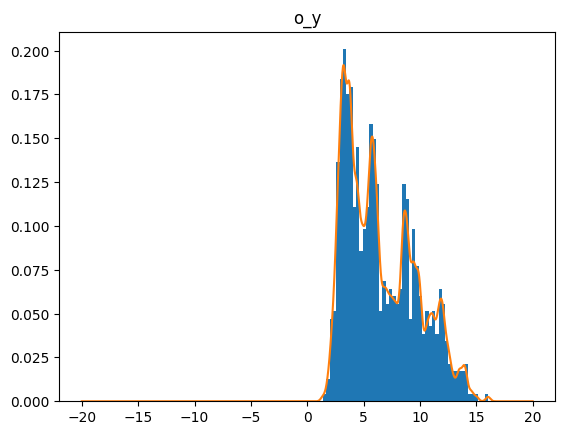

torch.Size([4000])
10601  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10602  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10603  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10604  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10605  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10606  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10607  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10608  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10609  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10610  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10611  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
10612  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10613  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10614  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10615  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10616  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10617  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10618  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10619  lo

10754  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10755  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10756  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10757  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10758  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10759  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10760  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10761  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10762  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10763  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10764  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10765  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10766  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10767  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10768  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
10769  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
10770  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10771  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10772  loss=  tensor(0.0732,

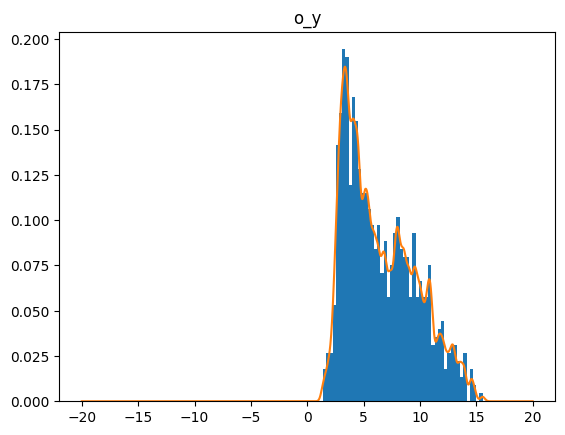

torch.Size([4000])
10801  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10802  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10803  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
10804  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
10805  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10806  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10807  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10808  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10809  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
10810  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10811  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10812  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10813  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10814  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10815  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
10816  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10817  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10818  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
10819  lo

10955  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10956  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
10957  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10958  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10959  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10960  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10961  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10962  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10963  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10964  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10965  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10966  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10967  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
10968  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10969  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10970  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
10971  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10972  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
10973  loss=  tensor(0.0731,

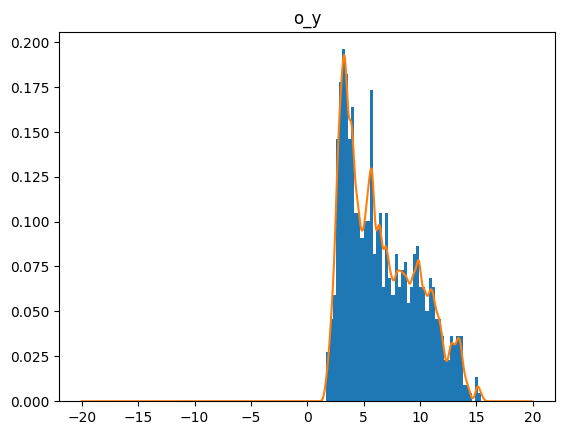

torch.Size([4000])
11001  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11002  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11003  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11004  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11005  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11006  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11007  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11008  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11009  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11010  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11011  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11012  loss=  tensor(0.0733, grad_fn=<MeanBackward0>)
11013  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11014  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11015  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11016  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11017  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11018  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
11019  lo

11160  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11161  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11162  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11163  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11164  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11165  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11166  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11167  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11168  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11169  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11170  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11171  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11172  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11173  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11174  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11175  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11176  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11177  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11178  loss=  tensor(0.0732,

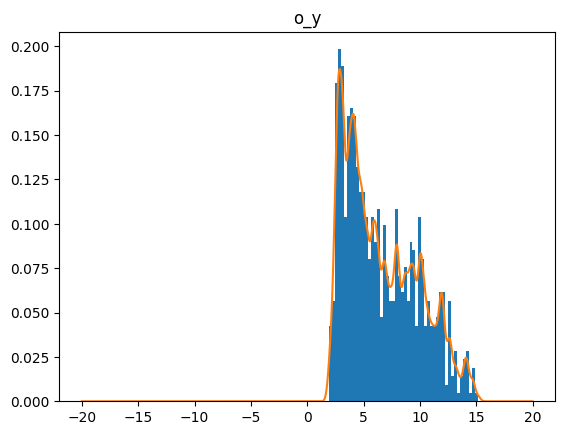

torch.Size([4000])
11201  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11202  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11203  loss=  tensor(0.0732, grad_fn=<MeanBackward0>)
11204  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11205  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11206  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11207  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11208  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11209  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11210  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11211  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11212  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11213  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11214  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11215  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11216  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11217  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11218  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11219  lo

11362  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11363  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11364  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11365  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11366  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11367  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11368  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11369  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11370  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11371  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11372  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11373  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11374  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11375  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11376  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11377  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11378  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11379  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11380  loss=  tensor(0.0730,

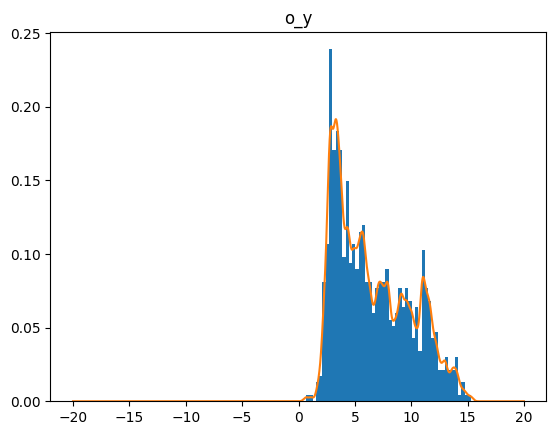

torch.Size([4000])
11401  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11402  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11403  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11404  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11405  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11406  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11407  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11408  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11409  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11410  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11411  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11412  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11413  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11414  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11415  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11416  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11417  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11418  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11419  lo

11560  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11561  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11562  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11563  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11564  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11565  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11566  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11567  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11568  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11569  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11570  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11571  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11572  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11573  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11574  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11575  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11576  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11577  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11578  loss=  tensor(0.0730,

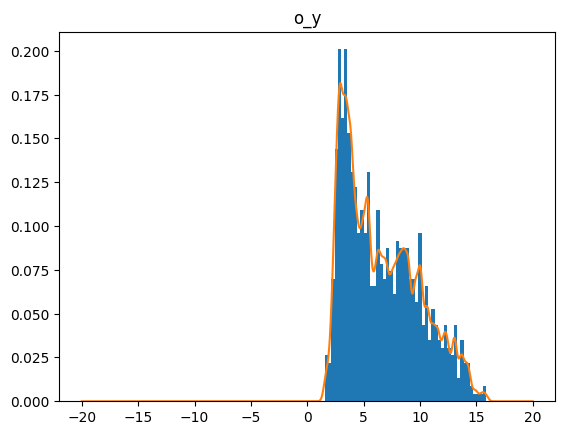

torch.Size([4000])
11601  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11602  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11603  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11604  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11605  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11606  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11607  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11608  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11609  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11610  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11611  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11612  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11613  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11614  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11615  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11616  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11617  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11618  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11619  lo

11757  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11758  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11759  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
11760  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11761  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11762  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11763  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11764  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11765  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11766  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11767  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11768  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
11769  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11770  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11771  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11772  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11773  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
11774  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11775  loss=  tensor(0.0730,

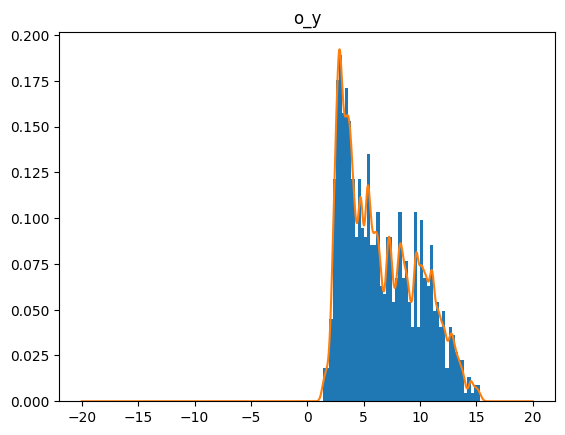

torch.Size([4000])
11801  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11802  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11803  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11804  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11805  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11806  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11807  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11808  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11809  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11810  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11811  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11812  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11813  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
11814  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
11815  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11816  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11817  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11818  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11819  lo

11957  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11958  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11959  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
11960  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11961  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
11962  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
11963  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11964  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11965  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11966  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11967  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11968  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11969  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11970  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
11971  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11972  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
11973  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
11974  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
11975  loss=  tensor(0.0729,

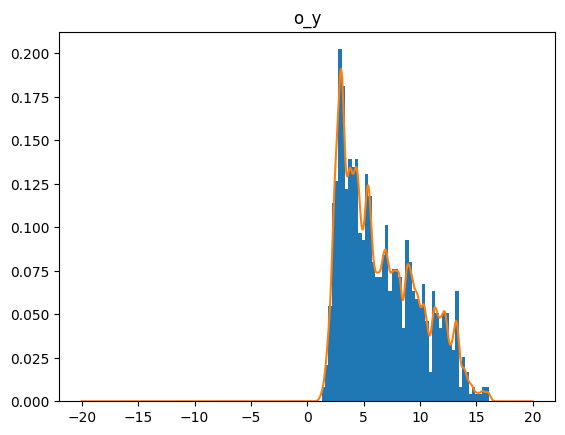

torch.Size([4000])
12001  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12002  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12003  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12004  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12005  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12006  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12007  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12008  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12009  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12010  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12011  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12012  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12013  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12014  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12015  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12016  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12017  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12018  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12019  lo

12162  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12163  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12164  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
12165  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12166  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12167  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12168  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12169  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12170  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12171  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12172  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12173  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12174  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12175  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12176  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12177  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12178  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12179  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12180  loss=  tensor(0.0729,

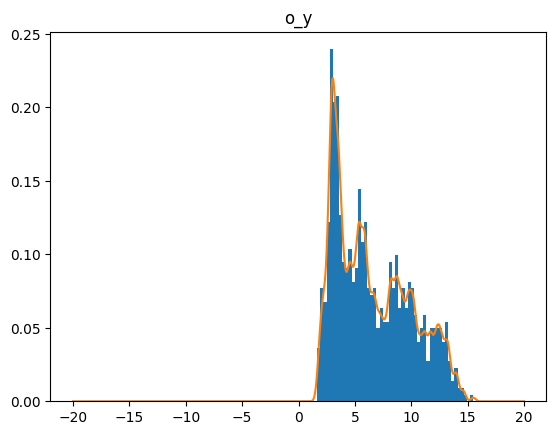

torch.Size([4000])
12201  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12202  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12203  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12204  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12205  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12206  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12207  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12208  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12209  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12210  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12211  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12212  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12213  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12214  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12215  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12216  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12217  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12218  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12219  lo

12353  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12354  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12355  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12356  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12357  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12358  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12359  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12360  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12361  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12362  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12363  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12364  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12365  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12366  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12367  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12368  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12369  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12370  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12371  loss=  tensor(0.0730,

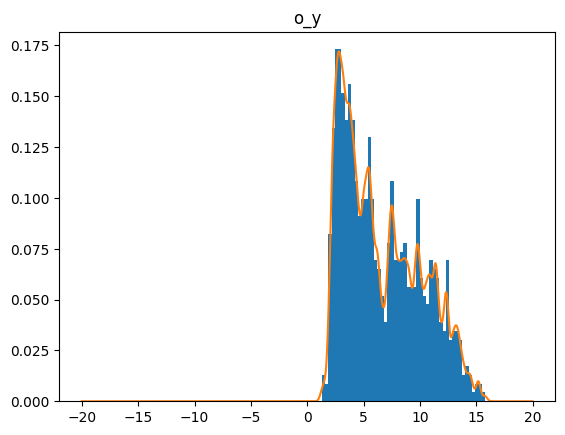

torch.Size([4000])
12401  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12402  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12403  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12404  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12405  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12406  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12407  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12408  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12409  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12410  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12411  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12412  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12413  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12414  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12415  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12416  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12417  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12418  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12419  lo

12559  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12560  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12561  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12562  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12563  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12564  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12565  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12566  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12567  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12568  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12569  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12570  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12571  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12572  loss=  tensor(0.0731, grad_fn=<MeanBackward0>)
12573  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12574  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12575  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12576  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12577  loss=  tensor(0.0728,

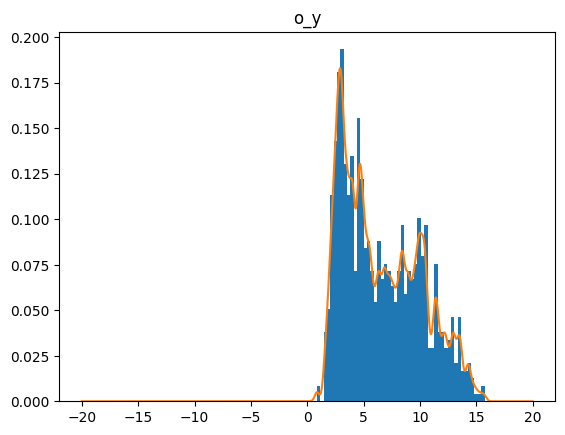

torch.Size([4000])
12601  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12602  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12603  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12604  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12605  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12606  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12607  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12608  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12609  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12610  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12611  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12612  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12613  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12614  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12615  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12616  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12617  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12618  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12619  lo

12757  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12758  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
12759  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12760  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12761  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12762  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12763  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12764  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12765  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12766  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12767  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12768  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12769  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12770  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12771  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12772  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12773  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12774  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12775  loss=  tensor(0.0729,

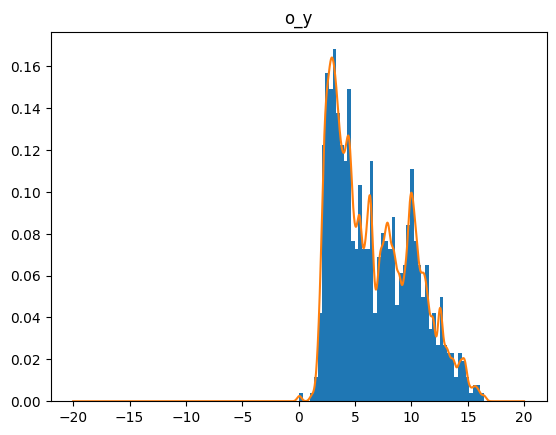

torch.Size([4000])
12801  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12802  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12803  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12804  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12805  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12806  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12807  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12808  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12809  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12810  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12811  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12812  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12813  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12814  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12815  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12816  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12817  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12818  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12819  lo

12961  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12962  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12963  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12964  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12965  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12966  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12967  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12968  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12969  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12970  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12971  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12972  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12973  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12974  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
12975  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12976  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12977  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12978  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
12979  loss=  tensor(0.0729,

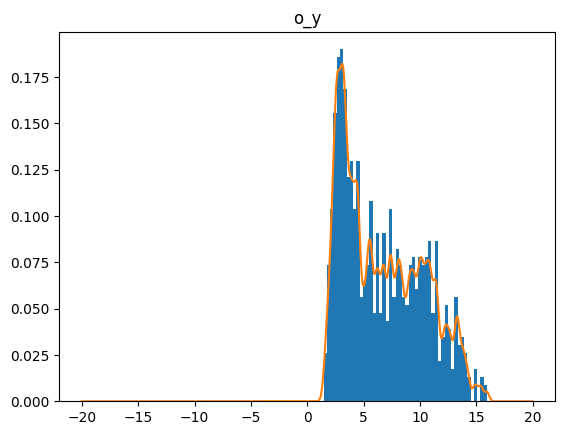

torch.Size([4000])
13001  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13002  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13003  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13004  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13005  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13006  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13007  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13008  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13009  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13010  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13011  loss=  tensor(0.0730, grad_fn=<MeanBackward0>)
13012  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13013  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13014  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13015  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13016  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13017  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13018  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13019  lo

13154  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13155  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13156  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13157  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13158  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13159  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13160  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13161  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13162  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13163  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13164  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13165  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13166  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13167  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13168  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13169  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13170  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13171  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13172  loss=  tensor(0.0728,

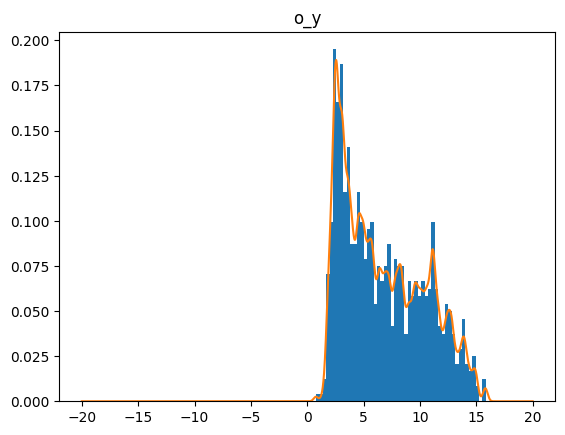

torch.Size([4000])
13201  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13202  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13203  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13204  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13205  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13206  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13207  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13208  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13209  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13210  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13211  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13212  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13213  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13214  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13215  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13216  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13217  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13218  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13219  lo

13360  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13361  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13362  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13363  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13364  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13365  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13366  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13367  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13368  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13369  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13370  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13371  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13372  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13373  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13374  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13375  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13376  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13377  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13378  loss=  tensor(0.0728,

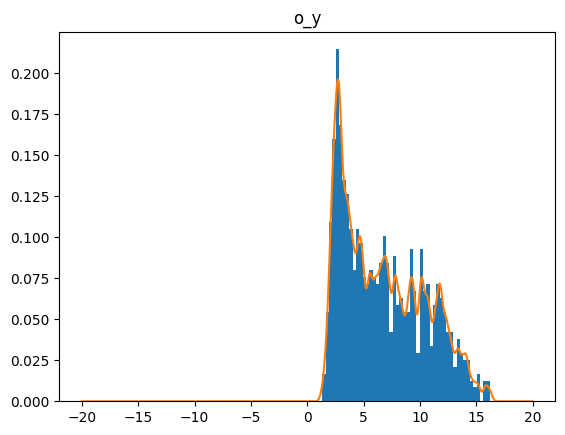

torch.Size([4000])
13401  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13402  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13403  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13404  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13405  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13406  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13407  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13408  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13409  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13410  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13411  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13412  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13413  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13414  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
13415  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13416  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13417  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13418  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13419  lo

13561  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13562  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13563  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13564  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13565  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13566  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13567  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13568  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13569  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13570  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13571  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13572  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13573  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13574  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13575  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13576  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13577  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13578  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13579  loss=  tensor(0.0728,

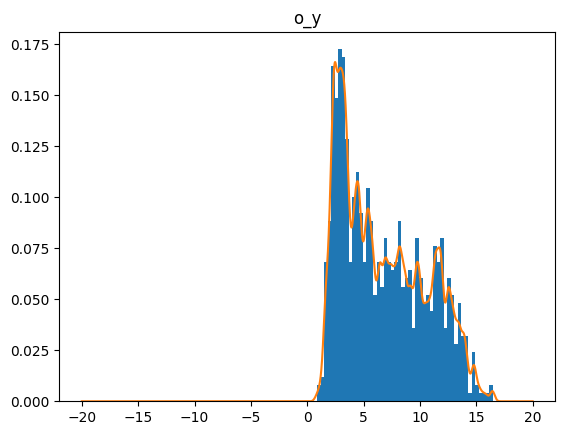

torch.Size([4000])
13601  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13602  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13603  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13604  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13605  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13606  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13607  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13608  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13609  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13610  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13611  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13612  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13613  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13614  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13615  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13616  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13617  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13618  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13619  lo

13755  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13756  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13757  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13758  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13759  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13760  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13761  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13762  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13763  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13764  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13765  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13766  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13767  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13768  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13769  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13770  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13771  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13772  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13773  loss=  tensor(0.0728,

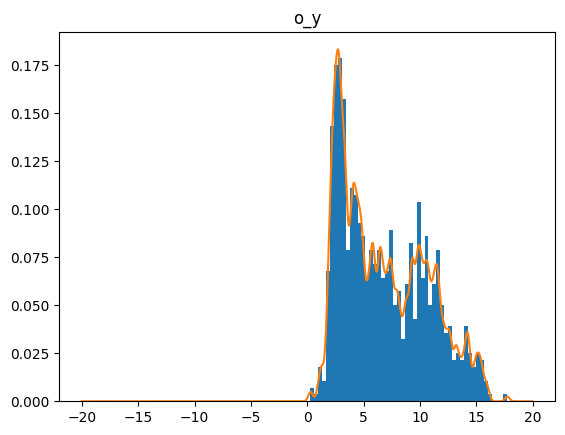

torch.Size([4000])
13801  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13802  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13803  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13804  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13805  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13806  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13807  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13808  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13809  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13810  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13811  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13812  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13813  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13814  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13815  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13816  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13817  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13818  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13819  lo

13962  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13963  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13964  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13965  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13966  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13967  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13968  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13969  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13970  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13971  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
13972  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13973  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13974  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13975  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13976  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13977  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13978  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
13979  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
13980  loss=  tensor(0.0726,

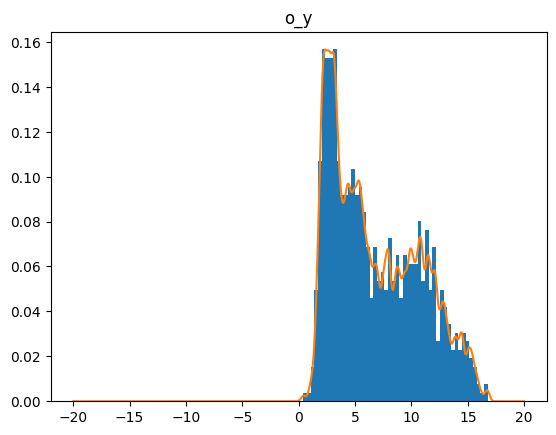

torch.Size([4000])
14001  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14002  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14003  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14004  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14005  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14006  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14007  loss=  tensor(0.0729, grad_fn=<MeanBackward0>)
14008  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14009  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14010  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14011  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14012  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14013  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14014  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14015  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14016  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14017  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14018  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14019  lo

14157  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14158  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14159  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14160  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14161  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
14162  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14163  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14164  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14165  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14166  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14167  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14168  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14169  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14170  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14171  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14172  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14173  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14174  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14175  loss=  tensor(0.0726,

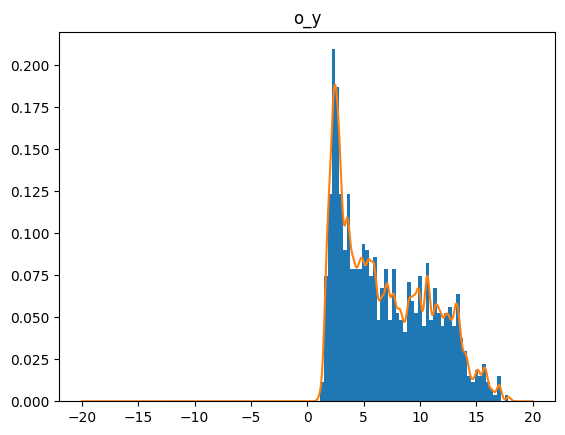

torch.Size([4000])
14201  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14202  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
14203  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14204  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14205  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14206  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14207  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14208  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14209  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14210  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14211  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14212  loss=  tensor(0.0728, grad_fn=<MeanBackward0>)
14213  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14214  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14215  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14216  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14217  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14218  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14219  lo

14357  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14358  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14359  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14360  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14361  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14362  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14363  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14364  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14365  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14366  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14367  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14368  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14369  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14370  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14371  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14372  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14373  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14374  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14375  loss=  tensor(0.0726,

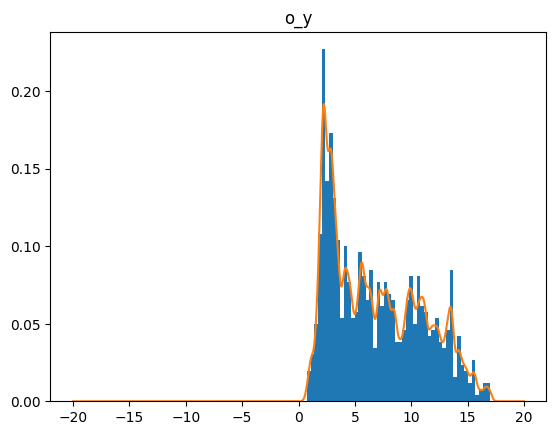

torch.Size([4000])
14401  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14402  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14403  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14404  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14405  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14406  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14407  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14408  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14409  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14410  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14411  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14412  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14413  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14414  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14415  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14416  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14417  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14418  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14419  lo

14556  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14557  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14558  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14559  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14560  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14561  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14562  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
14563  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14564  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14565  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14566  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14567  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14568  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14569  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14570  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14571  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14572  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14573  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14574  loss=  tensor(0.0726,

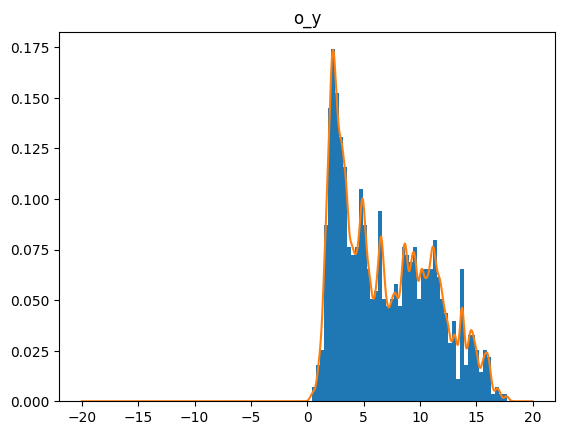

torch.Size([4000])
14601  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14602  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14603  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14604  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14605  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14606  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14607  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14608  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14609  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14610  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14611  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14612  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14613  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14614  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14615  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14616  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14617  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14618  loss=  tensor(0.0727, grad_fn=<MeanBackward0>)
14619  lo

14755  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14756  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14757  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14758  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14759  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14760  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
14761  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14762  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14763  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14764  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14765  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14766  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14767  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14768  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14769  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14770  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14771  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14772  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14773  loss=  tensor(0.0725,

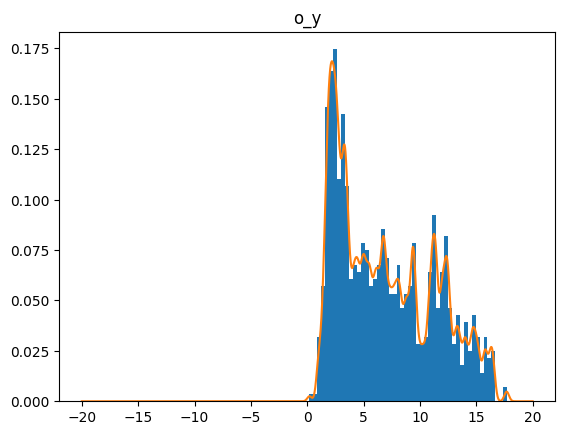

torch.Size([4000])
14801  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14802  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14803  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14804  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14805  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14806  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14807  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14808  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14809  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14810  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14811  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14812  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14813  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14814  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
14815  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14816  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14817  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14818  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14819  lo

14960  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
14961  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14962  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14963  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14964  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14965  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14966  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14967  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
14968  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14969  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14970  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14971  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
14972  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14973  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14974  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14975  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14976  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
14977  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
14978  loss=  tensor(0.0726,

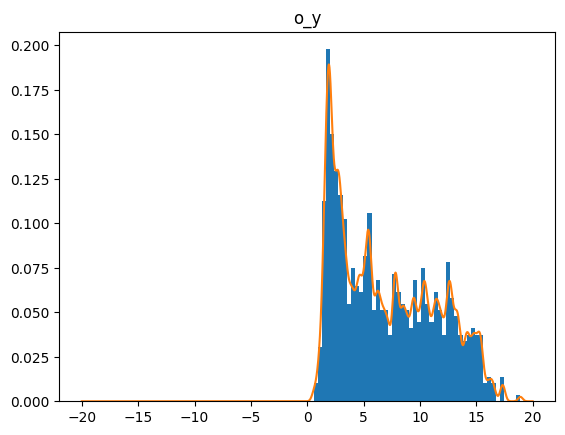

torch.Size([4000])
15001  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
15002  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15003  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15004  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15005  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15006  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15007  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15008  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
15009  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15010  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
15011  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15012  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15013  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15014  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15015  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15016  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15017  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15018  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15019  lo

15153  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15154  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15155  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15156  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15157  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15158  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15159  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15160  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15161  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15162  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15163  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15164  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15165  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15166  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15167  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15168  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15169  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15170  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15171  loss=  tensor(0.0725,

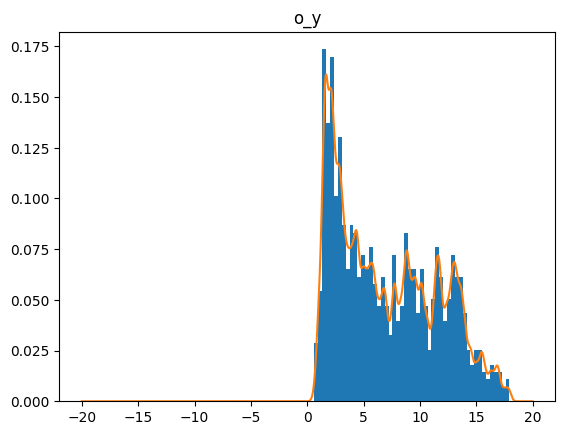

torch.Size([4000])
15201  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15202  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15203  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15204  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15205  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15206  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15207  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15208  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15209  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15210  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15211  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15212  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15213  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15214  loss=  tensor(0.0726, grad_fn=<MeanBackward0>)
15215  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15216  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15217  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15218  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15219  lo

15353  loss=  tensor(0.0725, grad_fn=<MeanBackward0>)
15354  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15355  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15356  loss=  tensor(0.0722, grad_fn=<MeanBackward0>)
15357  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15358  loss=  tensor(0.0722, grad_fn=<MeanBackward0>)
15359  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15360  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15361  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15362  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15363  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15364  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15365  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15366  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15367  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15368  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15369  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15370  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15371  loss=  tensor(0.0724,

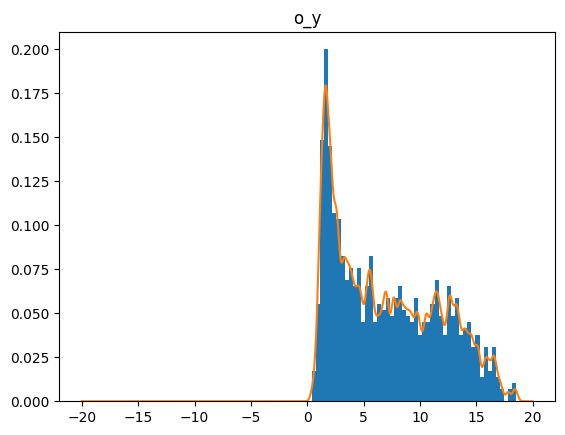

torch.Size([4000])
15401  loss=  tensor(0.0722, grad_fn=<MeanBackward0>)
15402  loss=  tensor(0.0722, grad_fn=<MeanBackward0>)
15403  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15404  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15405  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15406  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15407  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15408  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15409  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15410  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15411  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15412  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15413  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15414  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15415  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15416  loss=  tensor(0.0724, grad_fn=<MeanBackward0>)
15417  loss=  tensor(0.0723, grad_fn=<MeanBackward0>)
15418  loss=  tensor(0.0722, grad_fn=<MeanBackward0>)
15419  lo

15553  loss=  tensor(0.0705, grad_fn=<MeanBackward0>)
15554  loss=  tensor(0.0700, grad_fn=<MeanBackward0>)
15555  loss=  tensor(0.0700, grad_fn=<MeanBackward0>)
15556  loss=  tensor(0.0696, grad_fn=<MeanBackward0>)
15557  loss=  tensor(0.0697, grad_fn=<MeanBackward0>)
15558  loss=  tensor(0.0694, grad_fn=<MeanBackward0>)
15559  loss=  tensor(0.0696, grad_fn=<MeanBackward0>)
15560  loss=  tensor(0.0700, grad_fn=<MeanBackward0>)
15561  loss=  tensor(0.0692, grad_fn=<MeanBackward0>)
15562  loss=  tensor(0.0692, grad_fn=<MeanBackward0>)
15563  loss=  tensor(0.0683, grad_fn=<MeanBackward0>)
15564  loss=  tensor(0.0683, grad_fn=<MeanBackward0>)
15565  loss=  tensor(0.0690, grad_fn=<MeanBackward0>)
15566  loss=  tensor(0.0673, grad_fn=<MeanBackward0>)
15567  loss=  tensor(0.0678, grad_fn=<MeanBackward0>)
15568  loss=  tensor(0.0669, grad_fn=<MeanBackward0>)
15569  loss=  tensor(0.0673, grad_fn=<MeanBackward0>)
15570  loss=  tensor(0.0657, grad_fn=<MeanBackward0>)
15571  loss=  tensor(0.0666,

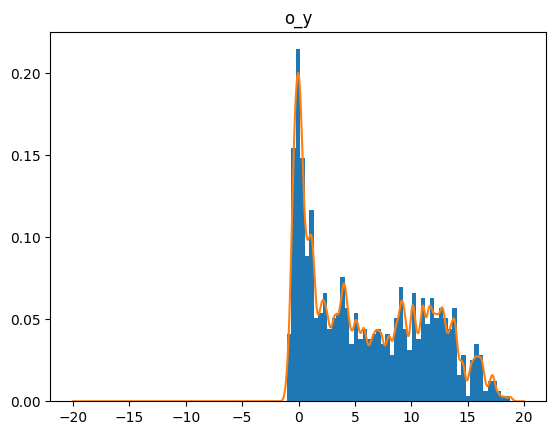

torch.Size([4000])
15601  loss=  tensor(0.0627, grad_fn=<MeanBackward0>)
15602  loss=  tensor(0.0635, grad_fn=<MeanBackward0>)
15603  loss=  tensor(0.0635, grad_fn=<MeanBackward0>)
15604  loss=  tensor(0.0622, grad_fn=<MeanBackward0>)
15605  loss=  tensor(0.0626, grad_fn=<MeanBackward0>)
15606  loss=  tensor(0.0625, grad_fn=<MeanBackward0>)
15607  loss=  tensor(0.0634, grad_fn=<MeanBackward0>)
15608  loss=  tensor(0.0627, grad_fn=<MeanBackward0>)
15609  loss=  tensor(0.0634, grad_fn=<MeanBackward0>)
15610  loss=  tensor(0.0629, grad_fn=<MeanBackward0>)
15611  loss=  tensor(0.0625, grad_fn=<MeanBackward0>)
15612  loss=  tensor(0.0630, grad_fn=<MeanBackward0>)
15613  loss=  tensor(0.0624, grad_fn=<MeanBackward0>)
15614  loss=  tensor(0.0624, grad_fn=<MeanBackward0>)
15615  loss=  tensor(0.0626, grad_fn=<MeanBackward0>)
15616  loss=  tensor(0.0623, grad_fn=<MeanBackward0>)
15617  loss=  tensor(0.0617, grad_fn=<MeanBackward0>)
15618  loss=  tensor(0.0627, grad_fn=<MeanBackward0>)
15619  lo

15760  loss=  tensor(0.0619, grad_fn=<MeanBackward0>)
15761  loss=  tensor(0.0621, grad_fn=<MeanBackward0>)
15762  loss=  tensor(0.0617, grad_fn=<MeanBackward0>)
15763  loss=  tensor(0.0614, grad_fn=<MeanBackward0>)
15764  loss=  tensor(0.0615, grad_fn=<MeanBackward0>)
15765  loss=  tensor(0.0623, grad_fn=<MeanBackward0>)
15766  loss=  tensor(0.0626, grad_fn=<MeanBackward0>)
15767  loss=  tensor(0.0621, grad_fn=<MeanBackward0>)
15768  loss=  tensor(0.0618, grad_fn=<MeanBackward0>)
15769  loss=  tensor(0.0620, grad_fn=<MeanBackward0>)
15770  loss=  tensor(0.0618, grad_fn=<MeanBackward0>)
15771  loss=  tensor(0.0622, grad_fn=<MeanBackward0>)
15772  loss=  tensor(0.0621, grad_fn=<MeanBackward0>)
15773  loss=  tensor(0.0620, grad_fn=<MeanBackward0>)
15774  loss=  tensor(0.0622, grad_fn=<MeanBackward0>)
15775  loss=  tensor(0.0622, grad_fn=<MeanBackward0>)
15776  loss=  tensor(0.0621, grad_fn=<MeanBackward0>)
15777  loss=  tensor(0.0618, grad_fn=<MeanBackward0>)
15778  loss=  tensor(0.0613,

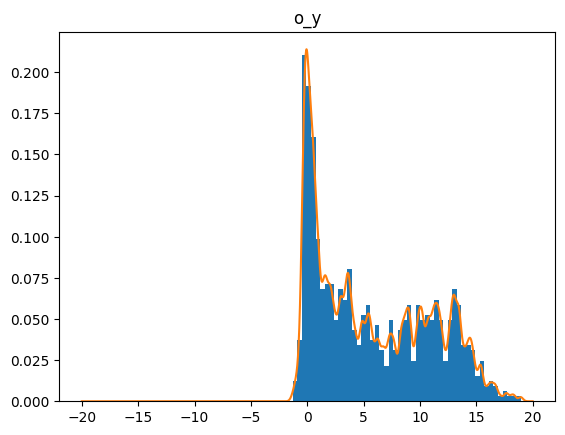

torch.Size([4000])
15801  loss=  tensor(0.0619, grad_fn=<MeanBackward0>)
15802  loss=  tensor(0.0621, grad_fn=<MeanBackward0>)
15803  loss=  tensor(0.0622, grad_fn=<MeanBackward0>)
15804  loss=  tensor(0.0619, grad_fn=<MeanBackward0>)
15805  loss=  tensor(0.0626, grad_fn=<MeanBackward0>)
15806  loss=  tensor(0.0619, grad_fn=<MeanBackward0>)
15807  loss=  tensor(0.0625, grad_fn=<MeanBackward0>)
15808  loss=  tensor(0.0633, grad_fn=<MeanBackward0>)
15809  loss=  tensor(0.0617, grad_fn=<MeanBackward0>)
15810  loss=  tensor(0.0625, grad_fn=<MeanBackward0>)
15811  loss=  tensor(0.0618, grad_fn=<MeanBackward0>)
15812  loss=  tensor(0.0615, grad_fn=<MeanBackward0>)
15813  loss=  tensor(0.0619, grad_fn=<MeanBackward0>)
15814  loss=  tensor(0.0615, grad_fn=<MeanBackward0>)
15815  loss=  tensor(0.0615, grad_fn=<MeanBackward0>)
15816  loss=  tensor(0.0618, grad_fn=<MeanBackward0>)
15817  loss=  tensor(0.0611, grad_fn=<MeanBackward0>)
15818  loss=  tensor(0.0614, grad_fn=<MeanBackward0>)
15819  lo

15955  loss=  tensor(0.0613, grad_fn=<MeanBackward0>)
15956  loss=  tensor(0.0604, grad_fn=<MeanBackward0>)
15957  loss=  tensor(0.0611, grad_fn=<MeanBackward0>)
15958  loss=  tensor(0.0616, grad_fn=<MeanBackward0>)
15959  loss=  tensor(0.0609, grad_fn=<MeanBackward0>)
15960  loss=  tensor(0.0610, grad_fn=<MeanBackward0>)
15961  loss=  tensor(0.0611, grad_fn=<MeanBackward0>)
15962  loss=  tensor(0.0608, grad_fn=<MeanBackward0>)
15963  loss=  tensor(0.0617, grad_fn=<MeanBackward0>)
15964  loss=  tensor(0.0611, grad_fn=<MeanBackward0>)
15965  loss=  tensor(0.0616, grad_fn=<MeanBackward0>)
15966  loss=  tensor(0.0604, grad_fn=<MeanBackward0>)
15967  loss=  tensor(0.0613, grad_fn=<MeanBackward0>)
15968  loss=  tensor(0.0606, grad_fn=<MeanBackward0>)
15969  loss=  tensor(0.0615, grad_fn=<MeanBackward0>)
15970  loss=  tensor(0.0611, grad_fn=<MeanBackward0>)
15971  loss=  tensor(0.0608, grad_fn=<MeanBackward0>)
15972  loss=  tensor(0.0617, grad_fn=<MeanBackward0>)
15973  loss=  tensor(0.0618,

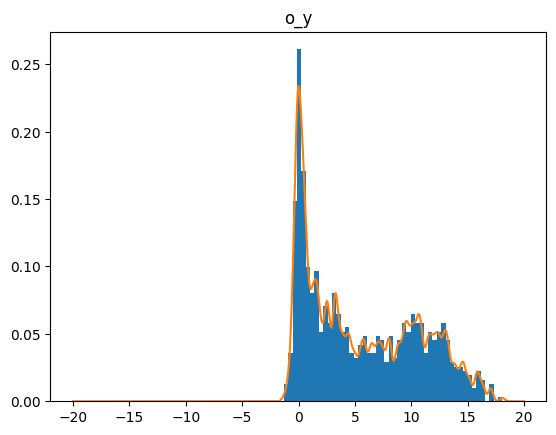

torch.Size([4000])
16001  loss=  tensor(0.0610, grad_fn=<MeanBackward0>)
16002  loss=  tensor(0.0611, grad_fn=<MeanBackward0>)
16003  loss=  tensor(0.0603, grad_fn=<MeanBackward0>)
16004  loss=  tensor(0.0614, grad_fn=<MeanBackward0>)
16005  loss=  tensor(0.0608, grad_fn=<MeanBackward0>)
16006  loss=  tensor(0.0613, grad_fn=<MeanBackward0>)
16007  loss=  tensor(0.0606, grad_fn=<MeanBackward0>)
16008  loss=  tensor(0.0609, grad_fn=<MeanBackward0>)
16009  loss=  tensor(0.0605, grad_fn=<MeanBackward0>)
16010  loss=  tensor(0.0602, grad_fn=<MeanBackward0>)
16011  loss=  tensor(0.0603, grad_fn=<MeanBackward0>)
16012  loss=  tensor(0.0610, grad_fn=<MeanBackward0>)
16013  loss=  tensor(0.0603, grad_fn=<MeanBackward0>)
16014  loss=  tensor(0.0607, grad_fn=<MeanBackward0>)
16015  loss=  tensor(0.0606, grad_fn=<MeanBackward0>)
16016  loss=  tensor(0.0607, grad_fn=<MeanBackward0>)
16017  loss=  tensor(0.0607, grad_fn=<MeanBackward0>)
16018  loss=  tensor(0.0610, grad_fn=<MeanBackward0>)
16019  lo

16154  loss=  tensor(0.0600, grad_fn=<MeanBackward0>)
16155  loss=  tensor(0.0600, grad_fn=<MeanBackward0>)
16156  loss=  tensor(0.0601, grad_fn=<MeanBackward0>)
16157  loss=  tensor(0.0609, grad_fn=<MeanBackward0>)
16158  loss=  tensor(0.0600, grad_fn=<MeanBackward0>)
16159  loss=  tensor(0.0603, grad_fn=<MeanBackward0>)
16160  loss=  tensor(0.0599, grad_fn=<MeanBackward0>)
16161  loss=  tensor(0.0605, grad_fn=<MeanBackward0>)
16162  loss=  tensor(0.0603, grad_fn=<MeanBackward0>)
16163  loss=  tensor(0.0595, grad_fn=<MeanBackward0>)
16164  loss=  tensor(0.0597, grad_fn=<MeanBackward0>)
16165  loss=  tensor(0.0597, grad_fn=<MeanBackward0>)
16166  loss=  tensor(0.0601, grad_fn=<MeanBackward0>)
16167  loss=  tensor(0.0599, grad_fn=<MeanBackward0>)
16168  loss=  tensor(0.0598, grad_fn=<MeanBackward0>)
16169  loss=  tensor(0.0600, grad_fn=<MeanBackward0>)
16170  loss=  tensor(0.0600, grad_fn=<MeanBackward0>)
16171  loss=  tensor(0.0599, grad_fn=<MeanBackward0>)
16172  loss=  tensor(0.0599,

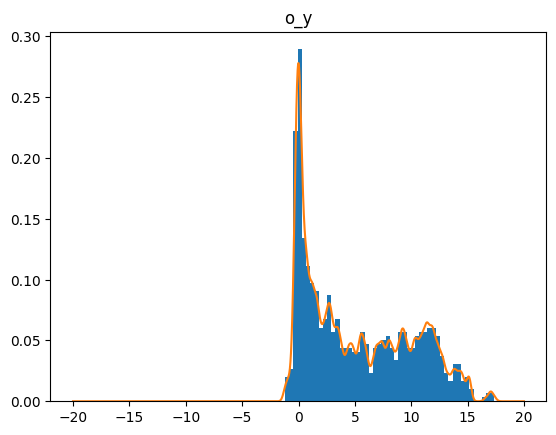

torch.Size([4000])
16201  loss=  tensor(0.0599, grad_fn=<MeanBackward0>)
16202  loss=  tensor(0.0597, grad_fn=<MeanBackward0>)
16203  loss=  tensor(0.0599, grad_fn=<MeanBackward0>)
16204  loss=  tensor(0.0601, grad_fn=<MeanBackward0>)
16205  loss=  tensor(0.0593, grad_fn=<MeanBackward0>)
16206  loss=  tensor(0.0598, grad_fn=<MeanBackward0>)
16207  loss=  tensor(0.0596, grad_fn=<MeanBackward0>)
16208  loss=  tensor(0.0597, grad_fn=<MeanBackward0>)
16209  loss=  tensor(0.0598, grad_fn=<MeanBackward0>)
16210  loss=  tensor(0.0597, grad_fn=<MeanBackward0>)
16211  loss=  tensor(0.0598, grad_fn=<MeanBackward0>)
16212  loss=  tensor(0.0591, grad_fn=<MeanBackward0>)
16213  loss=  tensor(0.0594, grad_fn=<MeanBackward0>)
16214  loss=  tensor(0.0597, grad_fn=<MeanBackward0>)
16215  loss=  tensor(0.0598, grad_fn=<MeanBackward0>)
16216  loss=  tensor(0.0596, grad_fn=<MeanBackward0>)
16217  loss=  tensor(0.0598, grad_fn=<MeanBackward0>)
16218  loss=  tensor(0.0597, grad_fn=<MeanBackward0>)
16219  lo

16354  loss=  tensor(0.0589, grad_fn=<MeanBackward0>)
16355  loss=  tensor(0.0593, grad_fn=<MeanBackward0>)
16356  loss=  tensor(0.0590, grad_fn=<MeanBackward0>)
16357  loss=  tensor(0.0590, grad_fn=<MeanBackward0>)
16358  loss=  tensor(0.0590, grad_fn=<MeanBackward0>)
16359  loss=  tensor(0.0591, grad_fn=<MeanBackward0>)
16360  loss=  tensor(0.0590, grad_fn=<MeanBackward0>)
16361  loss=  tensor(0.0593, grad_fn=<MeanBackward0>)
16362  loss=  tensor(0.0591, grad_fn=<MeanBackward0>)
16363  loss=  tensor(0.0589, grad_fn=<MeanBackward0>)
16364  loss=  tensor(0.0588, grad_fn=<MeanBackward0>)
16365  loss=  tensor(0.0587, grad_fn=<MeanBackward0>)
16366  loss=  tensor(0.0592, grad_fn=<MeanBackward0>)
16367  loss=  tensor(0.0589, grad_fn=<MeanBackward0>)
16368  loss=  tensor(0.0589, grad_fn=<MeanBackward0>)
16369  loss=  tensor(0.0586, grad_fn=<MeanBackward0>)
16370  loss=  tensor(0.0591, grad_fn=<MeanBackward0>)
16371  loss=  tensor(0.0588, grad_fn=<MeanBackward0>)
16372  loss=  tensor(0.0590,

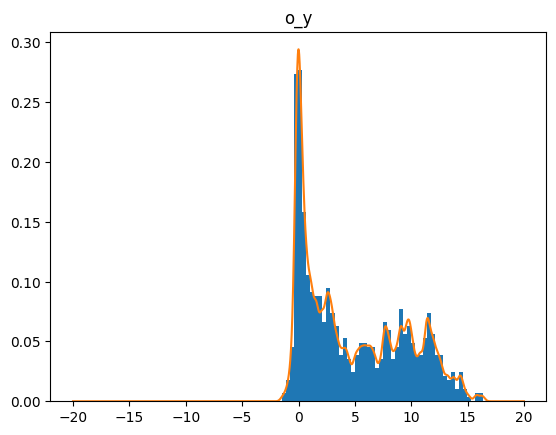

torch.Size([4000])
16401  loss=  tensor(0.0591, grad_fn=<MeanBackward0>)
16402  loss=  tensor(0.0588, grad_fn=<MeanBackward0>)
16403  loss=  tensor(0.0589, grad_fn=<MeanBackward0>)
16404  loss=  tensor(0.0587, grad_fn=<MeanBackward0>)
16405  loss=  tensor(0.0591, grad_fn=<MeanBackward0>)
16406  loss=  tensor(0.0586, grad_fn=<MeanBackward0>)
16407  loss=  tensor(0.0589, grad_fn=<MeanBackward0>)
16408  loss=  tensor(0.0591, grad_fn=<MeanBackward0>)
16409  loss=  tensor(0.0592, grad_fn=<MeanBackward0>)
16410  loss=  tensor(0.0587, grad_fn=<MeanBackward0>)
16411  loss=  tensor(0.0589, grad_fn=<MeanBackward0>)
16412  loss=  tensor(0.0590, grad_fn=<MeanBackward0>)
16413  loss=  tensor(0.0586, grad_fn=<MeanBackward0>)
16414  loss=  tensor(0.0591, grad_fn=<MeanBackward0>)
16415  loss=  tensor(0.0588, grad_fn=<MeanBackward0>)
16416  loss=  tensor(0.0586, grad_fn=<MeanBackward0>)
16417  loss=  tensor(0.0584, grad_fn=<MeanBackward0>)
16418  loss=  tensor(0.0586, grad_fn=<MeanBackward0>)
16419  lo

16553  loss=  tensor(0.0582, grad_fn=<MeanBackward0>)
16554  loss=  tensor(0.0582, grad_fn=<MeanBackward0>)
16555  loss=  tensor(0.0582, grad_fn=<MeanBackward0>)
16556  loss=  tensor(0.0580, grad_fn=<MeanBackward0>)
16557  loss=  tensor(0.0583, grad_fn=<MeanBackward0>)
16558  loss=  tensor(0.0583, grad_fn=<MeanBackward0>)
16559  loss=  tensor(0.0583, grad_fn=<MeanBackward0>)
16560  loss=  tensor(0.0583, grad_fn=<MeanBackward0>)
16561  loss=  tensor(0.0581, grad_fn=<MeanBackward0>)
16562  loss=  tensor(0.0584, grad_fn=<MeanBackward0>)
16563  loss=  tensor(0.0582, grad_fn=<MeanBackward0>)
16564  loss=  tensor(0.0580, grad_fn=<MeanBackward0>)
16565  loss=  tensor(0.0584, grad_fn=<MeanBackward0>)
16566  loss=  tensor(0.0584, grad_fn=<MeanBackward0>)
16567  loss=  tensor(0.0585, grad_fn=<MeanBackward0>)
16568  loss=  tensor(0.0587, grad_fn=<MeanBackward0>)
16569  loss=  tensor(0.0584, grad_fn=<MeanBackward0>)
16570  loss=  tensor(0.0585, grad_fn=<MeanBackward0>)
16571  loss=  tensor(0.0583,

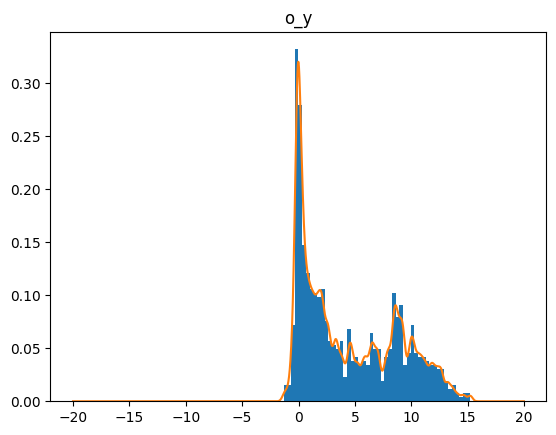

torch.Size([4000])
16601  loss=  tensor(0.0583, grad_fn=<MeanBackward0>)
16602  loss=  tensor(0.0583, grad_fn=<MeanBackward0>)
16603  loss=  tensor(0.0582, grad_fn=<MeanBackward0>)
16604  loss=  tensor(0.0581, grad_fn=<MeanBackward0>)
16605  loss=  tensor(0.0578, grad_fn=<MeanBackward0>)
16606  loss=  tensor(0.0583, grad_fn=<MeanBackward0>)
16607  loss=  tensor(0.0583, grad_fn=<MeanBackward0>)
16608  loss=  tensor(0.0583, grad_fn=<MeanBackward0>)
16609  loss=  tensor(0.0581, grad_fn=<MeanBackward0>)
16610  loss=  tensor(0.0579, grad_fn=<MeanBackward0>)
16611  loss=  tensor(0.0580, grad_fn=<MeanBackward0>)
16612  loss=  tensor(0.0583, grad_fn=<MeanBackward0>)
16613  loss=  tensor(0.0582, grad_fn=<MeanBackward0>)
16614  loss=  tensor(0.0580, grad_fn=<MeanBackward0>)
16615  loss=  tensor(0.0581, grad_fn=<MeanBackward0>)
16616  loss=  tensor(0.0582, grad_fn=<MeanBackward0>)
16617  loss=  tensor(0.0578, grad_fn=<MeanBackward0>)
16618  loss=  tensor(0.0586, grad_fn=<MeanBackward0>)
16619  lo

16754  loss=  tensor(0.0579, grad_fn=<MeanBackward0>)
16755  loss=  tensor(0.0574, grad_fn=<MeanBackward0>)
16756  loss=  tensor(0.0575, grad_fn=<MeanBackward0>)
16757  loss=  tensor(0.0575, grad_fn=<MeanBackward0>)
16758  loss=  tensor(0.0575, grad_fn=<MeanBackward0>)
16759  loss=  tensor(0.0582, grad_fn=<MeanBackward0>)
16760  loss=  tensor(0.0574, grad_fn=<MeanBackward0>)
16761  loss=  tensor(0.0576, grad_fn=<MeanBackward0>)
16762  loss=  tensor(0.0574, grad_fn=<MeanBackward0>)
16763  loss=  tensor(0.0576, grad_fn=<MeanBackward0>)
16764  loss=  tensor(0.0572, grad_fn=<MeanBackward0>)
16765  loss=  tensor(0.0574, grad_fn=<MeanBackward0>)
16766  loss=  tensor(0.0579, grad_fn=<MeanBackward0>)
16767  loss=  tensor(0.0577, grad_fn=<MeanBackward0>)
16768  loss=  tensor(0.0577, grad_fn=<MeanBackward0>)
16769  loss=  tensor(0.0575, grad_fn=<MeanBackward0>)
16770  loss=  tensor(0.0579, grad_fn=<MeanBackward0>)
16771  loss=  tensor(0.0577, grad_fn=<MeanBackward0>)
16772  loss=  tensor(0.0577,

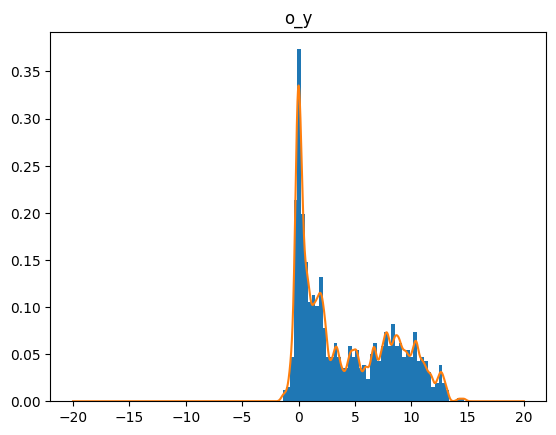

torch.Size([4000])
16801  loss=  tensor(0.0572, grad_fn=<MeanBackward0>)
16802  loss=  tensor(0.0576, grad_fn=<MeanBackward0>)
16803  loss=  tensor(0.0578, grad_fn=<MeanBackward0>)
16804  loss=  tensor(0.0575, grad_fn=<MeanBackward0>)
16805  loss=  tensor(0.0578, grad_fn=<MeanBackward0>)
16806  loss=  tensor(0.0576, grad_fn=<MeanBackward0>)
16807  loss=  tensor(0.0577, grad_fn=<MeanBackward0>)
16808  loss=  tensor(0.0575, grad_fn=<MeanBackward0>)
16809  loss=  tensor(0.0574, grad_fn=<MeanBackward0>)
16810  loss=  tensor(0.0575, grad_fn=<MeanBackward0>)
16811  loss=  tensor(0.0575, grad_fn=<MeanBackward0>)
16812  loss=  tensor(0.0578, grad_fn=<MeanBackward0>)
16813  loss=  tensor(0.0575, grad_fn=<MeanBackward0>)
16814  loss=  tensor(0.0575, grad_fn=<MeanBackward0>)
16815  loss=  tensor(0.0574, grad_fn=<MeanBackward0>)
16816  loss=  tensor(0.0573, grad_fn=<MeanBackward0>)
16817  loss=  tensor(0.0575, grad_fn=<MeanBackward0>)
16818  loss=  tensor(0.0576, grad_fn=<MeanBackward0>)
16819  lo

16953  loss=  tensor(0.0570, grad_fn=<MeanBackward0>)
16954  loss=  tensor(0.0572, grad_fn=<MeanBackward0>)
16955  loss=  tensor(0.0571, grad_fn=<MeanBackward0>)
16956  loss=  tensor(0.0569, grad_fn=<MeanBackward0>)
16957  loss=  tensor(0.0571, grad_fn=<MeanBackward0>)
16958  loss=  tensor(0.0570, grad_fn=<MeanBackward0>)
16959  loss=  tensor(0.0572, grad_fn=<MeanBackward0>)
16960  loss=  tensor(0.0570, grad_fn=<MeanBackward0>)
16961  loss=  tensor(0.0571, grad_fn=<MeanBackward0>)
16962  loss=  tensor(0.0568, grad_fn=<MeanBackward0>)
16963  loss=  tensor(0.0570, grad_fn=<MeanBackward0>)
16964  loss=  tensor(0.0569, grad_fn=<MeanBackward0>)
16965  loss=  tensor(0.0570, grad_fn=<MeanBackward0>)
16966  loss=  tensor(0.0568, grad_fn=<MeanBackward0>)
16967  loss=  tensor(0.0572, grad_fn=<MeanBackward0>)
16968  loss=  tensor(0.0568, grad_fn=<MeanBackward0>)
16969  loss=  tensor(0.0570, grad_fn=<MeanBackward0>)
16970  loss=  tensor(0.0568, grad_fn=<MeanBackward0>)
16971  loss=  tensor(0.0570,

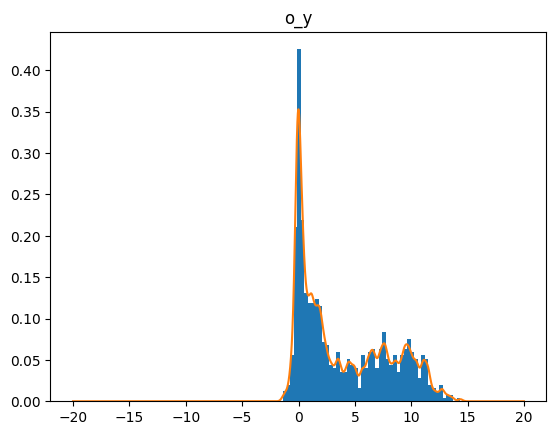

torch.Size([4000])
17001  loss=  tensor(0.0570, grad_fn=<MeanBackward0>)
17002  loss=  tensor(0.0568, grad_fn=<MeanBackward0>)
17003  loss=  tensor(0.0571, grad_fn=<MeanBackward0>)
17004  loss=  tensor(0.0568, grad_fn=<MeanBackward0>)
17005  loss=  tensor(0.0569, grad_fn=<MeanBackward0>)
17006  loss=  tensor(0.0569, grad_fn=<MeanBackward0>)
17007  loss=  tensor(0.0569, grad_fn=<MeanBackward0>)
17008  loss=  tensor(0.0569, grad_fn=<MeanBackward0>)
17009  loss=  tensor(0.0569, grad_fn=<MeanBackward0>)
17010  loss=  tensor(0.0569, grad_fn=<MeanBackward0>)
17011  loss=  tensor(0.0569, grad_fn=<MeanBackward0>)
17012  loss=  tensor(0.0570, grad_fn=<MeanBackward0>)
17013  loss=  tensor(0.0570, grad_fn=<MeanBackward0>)
17014  loss=  tensor(0.0569, grad_fn=<MeanBackward0>)
17015  loss=  tensor(0.0571, grad_fn=<MeanBackward0>)
17016  loss=  tensor(0.0567, grad_fn=<MeanBackward0>)
17017  loss=  tensor(0.0570, grad_fn=<MeanBackward0>)
17018  loss=  tensor(0.0569, grad_fn=<MeanBackward0>)
17019  lo

17160  loss=  tensor(0.0563, grad_fn=<MeanBackward0>)
17161  loss=  tensor(0.0567, grad_fn=<MeanBackward0>)
17162  loss=  tensor(0.0563, grad_fn=<MeanBackward0>)
17163  loss=  tensor(0.0565, grad_fn=<MeanBackward0>)
17164  loss=  tensor(0.0564, grad_fn=<MeanBackward0>)
17165  loss=  tensor(0.0566, grad_fn=<MeanBackward0>)
17166  loss=  tensor(0.0564, grad_fn=<MeanBackward0>)
17167  loss=  tensor(0.0563, grad_fn=<MeanBackward0>)
17168  loss=  tensor(0.0561, grad_fn=<MeanBackward0>)
17169  loss=  tensor(0.0565, grad_fn=<MeanBackward0>)
17170  loss=  tensor(0.0565, grad_fn=<MeanBackward0>)
17171  loss=  tensor(0.0565, grad_fn=<MeanBackward0>)
17172  loss=  tensor(0.0565, grad_fn=<MeanBackward0>)
17173  loss=  tensor(0.0564, grad_fn=<MeanBackward0>)
17174  loss=  tensor(0.0562, grad_fn=<MeanBackward0>)
17175  loss=  tensor(0.0563, grad_fn=<MeanBackward0>)
17176  loss=  tensor(0.0562, grad_fn=<MeanBackward0>)
17177  loss=  tensor(0.0562, grad_fn=<MeanBackward0>)
17178  loss=  tensor(0.0564,

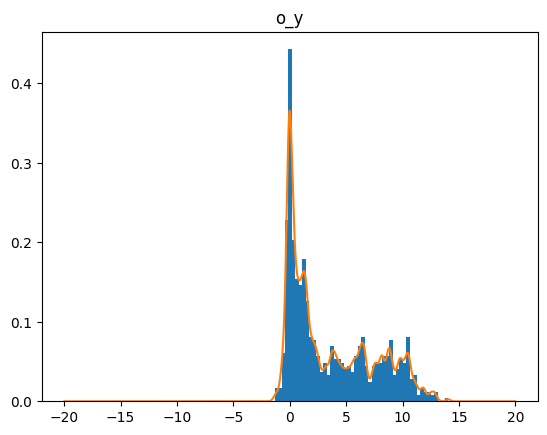

torch.Size([4000])
17201  loss=  tensor(0.0563, grad_fn=<MeanBackward0>)
17202  loss=  tensor(0.0562, grad_fn=<MeanBackward0>)
17203  loss=  tensor(0.0562, grad_fn=<MeanBackward0>)
17204  loss=  tensor(0.0564, grad_fn=<MeanBackward0>)
17205  loss=  tensor(0.0561, grad_fn=<MeanBackward0>)
17206  loss=  tensor(0.0561, grad_fn=<MeanBackward0>)
17207  loss=  tensor(0.0561, grad_fn=<MeanBackward0>)
17208  loss=  tensor(0.0563, grad_fn=<MeanBackward0>)
17209  loss=  tensor(0.0566, grad_fn=<MeanBackward0>)
17210  loss=  tensor(0.0563, grad_fn=<MeanBackward0>)
17211  loss=  tensor(0.0563, grad_fn=<MeanBackward0>)
17212  loss=  tensor(0.0562, grad_fn=<MeanBackward0>)
17213  loss=  tensor(0.0564, grad_fn=<MeanBackward0>)
17214  loss=  tensor(0.0564, grad_fn=<MeanBackward0>)
17215  loss=  tensor(0.0563, grad_fn=<MeanBackward0>)
17216  loss=  tensor(0.0562, grad_fn=<MeanBackward0>)
17217  loss=  tensor(0.0562, grad_fn=<MeanBackward0>)
17218  loss=  tensor(0.0563, grad_fn=<MeanBackward0>)
17219  lo

17354  loss=  tensor(0.0560, grad_fn=<MeanBackward0>)
17355  loss=  tensor(0.0557, grad_fn=<MeanBackward0>)
17356  loss=  tensor(0.0558, grad_fn=<MeanBackward0>)
17357  loss=  tensor(0.0559, grad_fn=<MeanBackward0>)
17358  loss=  tensor(0.0559, grad_fn=<MeanBackward0>)
17359  loss=  tensor(0.0559, grad_fn=<MeanBackward0>)
17360  loss=  tensor(0.0557, grad_fn=<MeanBackward0>)
17361  loss=  tensor(0.0556, grad_fn=<MeanBackward0>)
17362  loss=  tensor(0.0559, grad_fn=<MeanBackward0>)
17363  loss=  tensor(0.0558, grad_fn=<MeanBackward0>)
17364  loss=  tensor(0.0559, grad_fn=<MeanBackward0>)
17365  loss=  tensor(0.0558, grad_fn=<MeanBackward0>)
17366  loss=  tensor(0.0558, grad_fn=<MeanBackward0>)
17367  loss=  tensor(0.0560, grad_fn=<MeanBackward0>)
17368  loss=  tensor(0.0559, grad_fn=<MeanBackward0>)
17369  loss=  tensor(0.0555, grad_fn=<MeanBackward0>)
17370  loss=  tensor(0.0560, grad_fn=<MeanBackward0>)
17371  loss=  tensor(0.0560, grad_fn=<MeanBackward0>)
17372  loss=  tensor(0.0559,

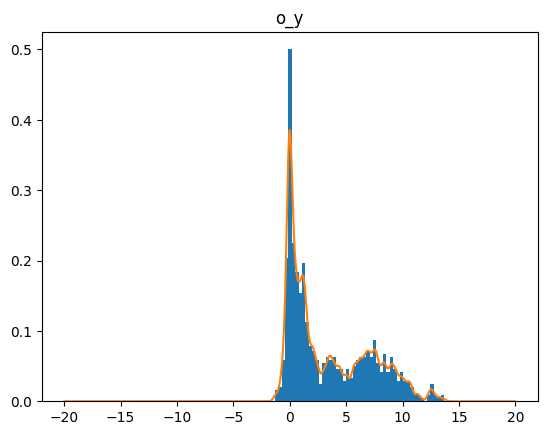

torch.Size([4000])
17401  loss=  tensor(0.0557, grad_fn=<MeanBackward0>)
17402  loss=  tensor(0.0556, grad_fn=<MeanBackward0>)
17403  loss=  tensor(0.0558, grad_fn=<MeanBackward0>)
17404  loss=  tensor(0.0559, grad_fn=<MeanBackward0>)
17405  loss=  tensor(0.0558, grad_fn=<MeanBackward0>)
17406  loss=  tensor(0.0558, grad_fn=<MeanBackward0>)
17407  loss=  tensor(0.0557, grad_fn=<MeanBackward0>)
17408  loss=  tensor(0.0555, grad_fn=<MeanBackward0>)
17409  loss=  tensor(0.0559, grad_fn=<MeanBackward0>)
17410  loss=  tensor(0.0558, grad_fn=<MeanBackward0>)
17411  loss=  tensor(0.0557, grad_fn=<MeanBackward0>)
17412  loss=  tensor(0.0556, grad_fn=<MeanBackward0>)
17413  loss=  tensor(0.0555, grad_fn=<MeanBackward0>)
17414  loss=  tensor(0.0556, grad_fn=<MeanBackward0>)
17415  loss=  tensor(0.0557, grad_fn=<MeanBackward0>)
17416  loss=  tensor(0.0556, grad_fn=<MeanBackward0>)
17417  loss=  tensor(0.0559, grad_fn=<MeanBackward0>)
17418  loss=  tensor(0.0557, grad_fn=<MeanBackward0>)
17419  lo

17554  loss=  tensor(0.0554, grad_fn=<MeanBackward0>)
17555  loss=  tensor(0.0555, grad_fn=<MeanBackward0>)
17556  loss=  tensor(0.0554, grad_fn=<MeanBackward0>)
17557  loss=  tensor(0.0552, grad_fn=<MeanBackward0>)
17558  loss=  tensor(0.0553, grad_fn=<MeanBackward0>)
17559  loss=  tensor(0.0554, grad_fn=<MeanBackward0>)
17560  loss=  tensor(0.0554, grad_fn=<MeanBackward0>)
17561  loss=  tensor(0.0553, grad_fn=<MeanBackward0>)
17562  loss=  tensor(0.0552, grad_fn=<MeanBackward0>)
17563  loss=  tensor(0.0554, grad_fn=<MeanBackward0>)
17564  loss=  tensor(0.0552, grad_fn=<MeanBackward0>)
17565  loss=  tensor(0.0552, grad_fn=<MeanBackward0>)
17566  loss=  tensor(0.0554, grad_fn=<MeanBackward0>)
17567  loss=  tensor(0.0553, grad_fn=<MeanBackward0>)
17568  loss=  tensor(0.0555, grad_fn=<MeanBackward0>)
17569  loss=  tensor(0.0551, grad_fn=<MeanBackward0>)
17570  loss=  tensor(0.0553, grad_fn=<MeanBackward0>)
17571  loss=  tensor(0.0550, grad_fn=<MeanBackward0>)
17572  loss=  tensor(0.0553,

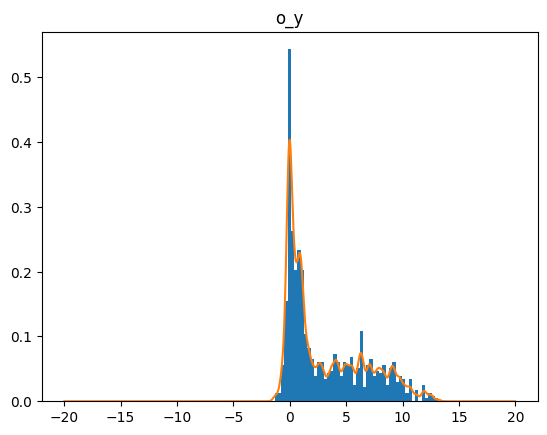

torch.Size([4000])
17601  loss=  tensor(0.0551, grad_fn=<MeanBackward0>)
17602  loss=  tensor(0.0550, grad_fn=<MeanBackward0>)
17603  loss=  tensor(0.0551, grad_fn=<MeanBackward0>)
17604  loss=  tensor(0.0552, grad_fn=<MeanBackward0>)
17605  loss=  tensor(0.0551, grad_fn=<MeanBackward0>)
17606  loss=  tensor(0.0552, grad_fn=<MeanBackward0>)
17607  loss=  tensor(0.0551, grad_fn=<MeanBackward0>)
17608  loss=  tensor(0.0551, grad_fn=<MeanBackward0>)
17609  loss=  tensor(0.0554, grad_fn=<MeanBackward0>)
17610  loss=  tensor(0.0552, grad_fn=<MeanBackward0>)
17611  loss=  tensor(0.0553, grad_fn=<MeanBackward0>)
17612  loss=  tensor(0.0552, grad_fn=<MeanBackward0>)
17613  loss=  tensor(0.0550, grad_fn=<MeanBackward0>)
17614  loss=  tensor(0.0552, grad_fn=<MeanBackward0>)
17615  loss=  tensor(0.0551, grad_fn=<MeanBackward0>)
17616  loss=  tensor(0.0551, grad_fn=<MeanBackward0>)
17617  loss=  tensor(0.0551, grad_fn=<MeanBackward0>)
17618  loss=  tensor(0.0550, grad_fn=<MeanBackward0>)
17619  lo

17753  loss=  tensor(0.0546, grad_fn=<MeanBackward0>)
17754  loss=  tensor(0.0546, grad_fn=<MeanBackward0>)
17755  loss=  tensor(0.0546, grad_fn=<MeanBackward0>)
17756  loss=  tensor(0.0548, grad_fn=<MeanBackward0>)
17757  loss=  tensor(0.0547, grad_fn=<MeanBackward0>)
17758  loss=  tensor(0.0546, grad_fn=<MeanBackward0>)
17759  loss=  tensor(0.0548, grad_fn=<MeanBackward0>)
17760  loss=  tensor(0.0546, grad_fn=<MeanBackward0>)
17761  loss=  tensor(0.0546, grad_fn=<MeanBackward0>)
17762  loss=  tensor(0.0545, grad_fn=<MeanBackward0>)
17763  loss=  tensor(0.0545, grad_fn=<MeanBackward0>)
17764  loss=  tensor(0.0547, grad_fn=<MeanBackward0>)
17765  loss=  tensor(0.0547, grad_fn=<MeanBackward0>)
17766  loss=  tensor(0.0544, grad_fn=<MeanBackward0>)
17767  loss=  tensor(0.0545, grad_fn=<MeanBackward0>)
17768  loss=  tensor(0.0547, grad_fn=<MeanBackward0>)
17769  loss=  tensor(0.0545, grad_fn=<MeanBackward0>)
17770  loss=  tensor(0.0545, grad_fn=<MeanBackward0>)
17771  loss=  tensor(0.0543,

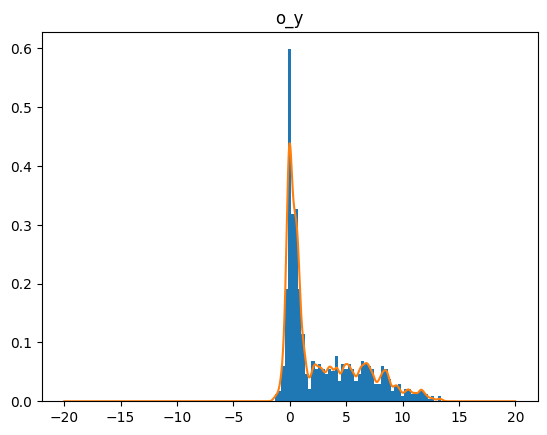

torch.Size([4000])
17801  loss=  tensor(0.0540, grad_fn=<MeanBackward0>)
17802  loss=  tensor(0.0539, grad_fn=<MeanBackward0>)
17803  loss=  tensor(0.0541, grad_fn=<MeanBackward0>)
17804  loss=  tensor(0.0540, grad_fn=<MeanBackward0>)
17805  loss=  tensor(0.0539, grad_fn=<MeanBackward0>)
17806  loss=  tensor(0.0539, grad_fn=<MeanBackward0>)
17807  loss=  tensor(0.0540, grad_fn=<MeanBackward0>)
17808  loss=  tensor(0.0537, grad_fn=<MeanBackward0>)
17809  loss=  tensor(0.0539, grad_fn=<MeanBackward0>)
17810  loss=  tensor(0.0539, grad_fn=<MeanBackward0>)
17811  loss=  tensor(0.0538, grad_fn=<MeanBackward0>)
17812  loss=  tensor(0.0537, grad_fn=<MeanBackward0>)
17813  loss=  tensor(0.0540, grad_fn=<MeanBackward0>)
17814  loss=  tensor(0.0537, grad_fn=<MeanBackward0>)
17815  loss=  tensor(0.0536, grad_fn=<MeanBackward0>)
17816  loss=  tensor(0.0535, grad_fn=<MeanBackward0>)
17817  loss=  tensor(0.0539, grad_fn=<MeanBackward0>)
17818  loss=  tensor(0.0537, grad_fn=<MeanBackward0>)
17819  lo

17953  loss=  tensor(0.0457, grad_fn=<MeanBackward0>)
17954  loss=  tensor(0.0460, grad_fn=<MeanBackward0>)
17955  loss=  tensor(0.0459, grad_fn=<MeanBackward0>)
17956  loss=  tensor(0.0459, grad_fn=<MeanBackward0>)
17957  loss=  tensor(0.0460, grad_fn=<MeanBackward0>)
17958  loss=  tensor(0.0454, grad_fn=<MeanBackward0>)
17959  loss=  tensor(0.0460, grad_fn=<MeanBackward0>)
17960  loss=  tensor(0.0457, grad_fn=<MeanBackward0>)
17961  loss=  tensor(0.0455, grad_fn=<MeanBackward0>)
17962  loss=  tensor(0.0458, grad_fn=<MeanBackward0>)
17963  loss=  tensor(0.0458, grad_fn=<MeanBackward0>)
17964  loss=  tensor(0.0460, grad_fn=<MeanBackward0>)
17965  loss=  tensor(0.0458, grad_fn=<MeanBackward0>)
17966  loss=  tensor(0.0457, grad_fn=<MeanBackward0>)
17967  loss=  tensor(0.0453, grad_fn=<MeanBackward0>)
17968  loss=  tensor(0.0456, grad_fn=<MeanBackward0>)
17969  loss=  tensor(0.0454, grad_fn=<MeanBackward0>)
17970  loss=  tensor(0.0455, grad_fn=<MeanBackward0>)
17971  loss=  tensor(0.0457,

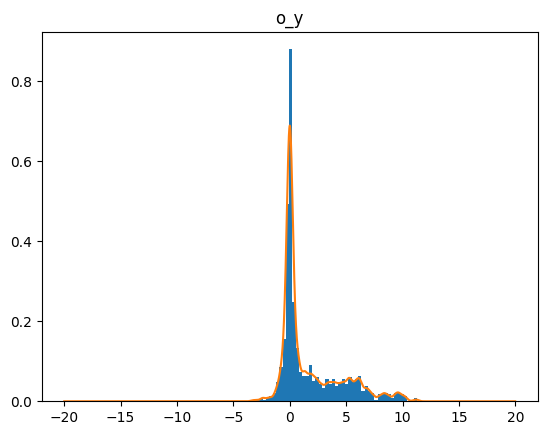

torch.Size([4000])
18001  loss=  tensor(0.0449, grad_fn=<MeanBackward0>)
18002  loss=  tensor(0.0447, grad_fn=<MeanBackward0>)
18003  loss=  tensor(0.0449, grad_fn=<MeanBackward0>)
18004  loss=  tensor(0.0448, grad_fn=<MeanBackward0>)
18005  loss=  tensor(0.0448, grad_fn=<MeanBackward0>)
18006  loss=  tensor(0.0446, grad_fn=<MeanBackward0>)
18007  loss=  tensor(0.0442, grad_fn=<MeanBackward0>)
18008  loss=  tensor(0.0446, grad_fn=<MeanBackward0>)
18009  loss=  tensor(0.0450, grad_fn=<MeanBackward0>)
18010  loss=  tensor(0.0445, grad_fn=<MeanBackward0>)
18011  loss=  tensor(0.0444, grad_fn=<MeanBackward0>)
18012  loss=  tensor(0.0445, grad_fn=<MeanBackward0>)
18013  loss=  tensor(0.0446, grad_fn=<MeanBackward0>)
18014  loss=  tensor(0.0442, grad_fn=<MeanBackward0>)
18015  loss=  tensor(0.0445, grad_fn=<MeanBackward0>)
18016  loss=  tensor(0.0445, grad_fn=<MeanBackward0>)
18017  loss=  tensor(0.0447, grad_fn=<MeanBackward0>)
18018  loss=  tensor(0.0447, grad_fn=<MeanBackward0>)
18019  lo

18155  loss=  tensor(0.0430, grad_fn=<MeanBackward0>)
18156  loss=  tensor(0.0431, grad_fn=<MeanBackward0>)
18157  loss=  tensor(0.0428, grad_fn=<MeanBackward0>)
18158  loss=  tensor(0.0432, grad_fn=<MeanBackward0>)
18159  loss=  tensor(0.0430, grad_fn=<MeanBackward0>)
18160  loss=  tensor(0.0430, grad_fn=<MeanBackward0>)
18161  loss=  tensor(0.0430, grad_fn=<MeanBackward0>)
18162  loss=  tensor(0.0432, grad_fn=<MeanBackward0>)
18163  loss=  tensor(0.0426, grad_fn=<MeanBackward0>)
18164  loss=  tensor(0.0430, grad_fn=<MeanBackward0>)
18165  loss=  tensor(0.0431, grad_fn=<MeanBackward0>)
18166  loss=  tensor(0.0431, grad_fn=<MeanBackward0>)
18167  loss=  tensor(0.0432, grad_fn=<MeanBackward0>)
18168  loss=  tensor(0.0429, grad_fn=<MeanBackward0>)
18169  loss=  tensor(0.0428, grad_fn=<MeanBackward0>)
18170  loss=  tensor(0.0431, grad_fn=<MeanBackward0>)
18171  loss=  tensor(0.0429, grad_fn=<MeanBackward0>)
18172  loss=  tensor(0.0428, grad_fn=<MeanBackward0>)
18173  loss=  tensor(0.0433,

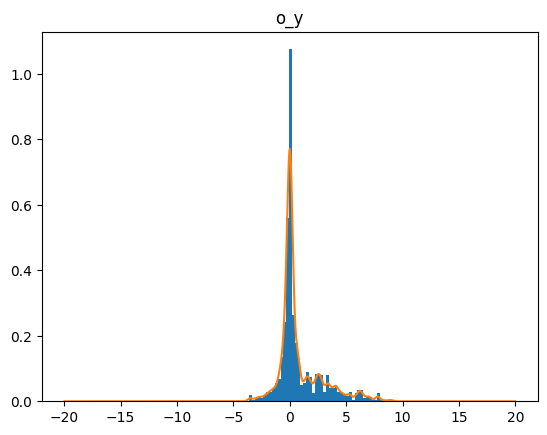

torch.Size([4000])
18201  loss=  tensor(0.0429, grad_fn=<MeanBackward0>)
18202  loss=  tensor(0.0428, grad_fn=<MeanBackward0>)
18203  loss=  tensor(0.0428, grad_fn=<MeanBackward0>)
18204  loss=  tensor(0.0427, grad_fn=<MeanBackward0>)
18205  loss=  tensor(0.0426, grad_fn=<MeanBackward0>)
18206  loss=  tensor(0.0428, grad_fn=<MeanBackward0>)
18207  loss=  tensor(0.0427, grad_fn=<MeanBackward0>)
18208  loss=  tensor(0.0429, grad_fn=<MeanBackward0>)
18209  loss=  tensor(0.0429, grad_fn=<MeanBackward0>)
18210  loss=  tensor(0.0429, grad_fn=<MeanBackward0>)
18211  loss=  tensor(0.0424, grad_fn=<MeanBackward0>)
18212  loss=  tensor(0.0426, grad_fn=<MeanBackward0>)
18213  loss=  tensor(0.0426, grad_fn=<MeanBackward0>)
18214  loss=  tensor(0.0423, grad_fn=<MeanBackward0>)
18215  loss=  tensor(0.0426, grad_fn=<MeanBackward0>)
18216  loss=  tensor(0.0425, grad_fn=<MeanBackward0>)
18217  loss=  tensor(0.0424, grad_fn=<MeanBackward0>)
18218  loss=  tensor(0.0426, grad_fn=<MeanBackward0>)
18219  lo

18353  loss=  tensor(0.0415, grad_fn=<MeanBackward0>)
18354  loss=  tensor(0.0415, grad_fn=<MeanBackward0>)
18355  loss=  tensor(0.0414, grad_fn=<MeanBackward0>)
18356  loss=  tensor(0.0414, grad_fn=<MeanBackward0>)
18357  loss=  tensor(0.0413, grad_fn=<MeanBackward0>)
18358  loss=  tensor(0.0413, grad_fn=<MeanBackward0>)
18359  loss=  tensor(0.0414, grad_fn=<MeanBackward0>)
18360  loss=  tensor(0.0413, grad_fn=<MeanBackward0>)
18361  loss=  tensor(0.0414, grad_fn=<MeanBackward0>)
18362  loss=  tensor(0.0413, grad_fn=<MeanBackward0>)
18363  loss=  tensor(0.0413, grad_fn=<MeanBackward0>)
18364  loss=  tensor(0.0413, grad_fn=<MeanBackward0>)
18365  loss=  tensor(0.0412, grad_fn=<MeanBackward0>)
18366  loss=  tensor(0.0413, grad_fn=<MeanBackward0>)
18367  loss=  tensor(0.0412, grad_fn=<MeanBackward0>)
18368  loss=  tensor(0.0413, grad_fn=<MeanBackward0>)
18369  loss=  tensor(0.0412, grad_fn=<MeanBackward0>)
18370  loss=  tensor(0.0412, grad_fn=<MeanBackward0>)
18371  loss=  tensor(0.0412,

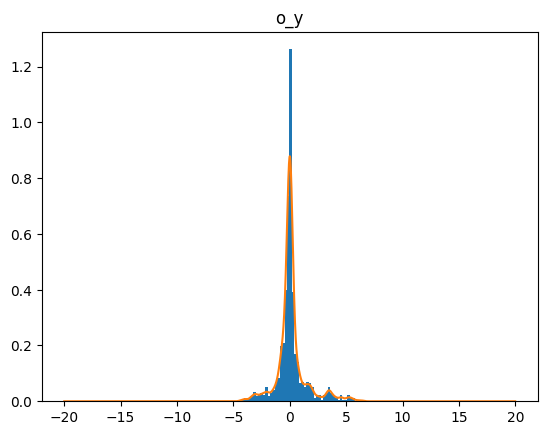

torch.Size([4000])
18401  loss=  tensor(0.0399, grad_fn=<MeanBackward0>)
18402  loss=  tensor(0.0400, grad_fn=<MeanBackward0>)
18403  loss=  tensor(0.0397, grad_fn=<MeanBackward0>)
18404  loss=  tensor(0.0398, grad_fn=<MeanBackward0>)
18405  loss=  tensor(0.0396, grad_fn=<MeanBackward0>)
18406  loss=  tensor(0.0397, grad_fn=<MeanBackward0>)
18407  loss=  tensor(0.0397, grad_fn=<MeanBackward0>)
18408  loss=  tensor(0.0395, grad_fn=<MeanBackward0>)
18409  loss=  tensor(0.0395, grad_fn=<MeanBackward0>)
18410  loss=  tensor(0.0389, grad_fn=<MeanBackward0>)
18411  loss=  tensor(0.0394, grad_fn=<MeanBackward0>)
18412  loss=  tensor(0.0397, grad_fn=<MeanBackward0>)
18413  loss=  tensor(0.0392, grad_fn=<MeanBackward0>)
18414  loss=  tensor(0.0392, grad_fn=<MeanBackward0>)
18415  loss=  tensor(0.0392, grad_fn=<MeanBackward0>)
18416  loss=  tensor(0.0395, grad_fn=<MeanBackward0>)
18417  loss=  tensor(0.0394, grad_fn=<MeanBackward0>)
18418  loss=  tensor(0.0390, grad_fn=<MeanBackward0>)
18419  lo

18554  loss=  tensor(0.0386, grad_fn=<MeanBackward0>)
18555  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
18556  loss=  tensor(0.0388, grad_fn=<MeanBackward0>)
18557  loss=  tensor(0.0385, grad_fn=<MeanBackward0>)
18558  loss=  tensor(0.0387, grad_fn=<MeanBackward0>)
18559  loss=  tensor(0.0381, grad_fn=<MeanBackward0>)
18560  loss=  tensor(0.0382, grad_fn=<MeanBackward0>)
18561  loss=  tensor(0.0385, grad_fn=<MeanBackward0>)
18562  loss=  tensor(0.0386, grad_fn=<MeanBackward0>)
18563  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
18564  loss=  tensor(0.0384, grad_fn=<MeanBackward0>)
18565  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
18566  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
18567  loss=  tensor(0.0382, grad_fn=<MeanBackward0>)
18568  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
18569  loss=  tensor(0.0383, grad_fn=<MeanBackward0>)
18570  loss=  tensor(0.0382, grad_fn=<MeanBackward0>)
18571  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
18572  loss=  tensor(0.0379,

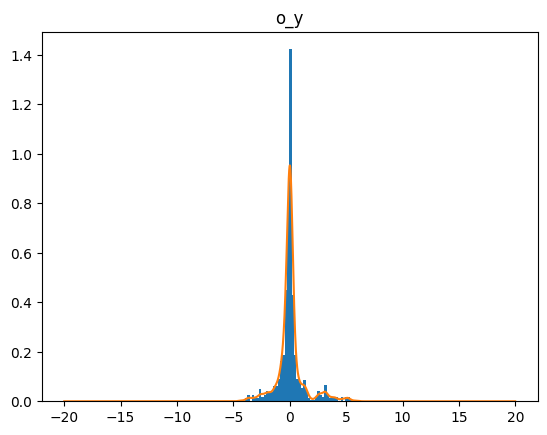

torch.Size([4000])
18601  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
18602  loss=  tensor(0.0386, grad_fn=<MeanBackward0>)
18603  loss=  tensor(0.0384, grad_fn=<MeanBackward0>)
18604  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
18605  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
18606  loss=  tensor(0.0383, grad_fn=<MeanBackward0>)
18607  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
18608  loss=  tensor(0.0383, grad_fn=<MeanBackward0>)
18609  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
18610  loss=  tensor(0.0381, grad_fn=<MeanBackward0>)
18611  loss=  tensor(0.0382, grad_fn=<MeanBackward0>)
18612  loss=  tensor(0.0385, grad_fn=<MeanBackward0>)
18613  loss=  tensor(0.0381, grad_fn=<MeanBackward0>)
18614  loss=  tensor(0.0385, grad_fn=<MeanBackward0>)
18615  loss=  tensor(0.0382, grad_fn=<MeanBackward0>)
18616  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
18617  loss=  tensor(0.0381, grad_fn=<MeanBackward0>)
18618  loss=  tensor(0.0382, grad_fn=<MeanBackward0>)
18619  lo

18760  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
18761  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
18762  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
18763  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
18764  loss=  tensor(0.0379, grad_fn=<MeanBackward0>)
18765  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
18766  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
18767  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
18768  loss=  tensor(0.0382, grad_fn=<MeanBackward0>)
18769  loss=  tensor(0.0379, grad_fn=<MeanBackward0>)
18770  loss=  tensor(0.0381, grad_fn=<MeanBackward0>)
18771  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
18772  loss=  tensor(0.0381, grad_fn=<MeanBackward0>)
18773  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
18774  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
18775  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
18776  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
18777  loss=  tensor(0.0379, grad_fn=<MeanBackward0>)
18778  loss=  tensor(0.0378,

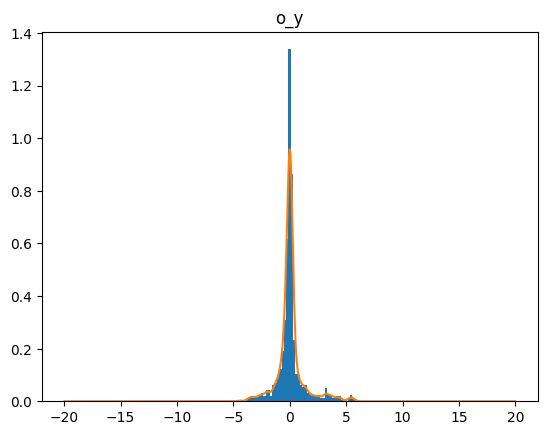

torch.Size([4000])
18801  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
18802  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
18803  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
18804  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
18805  loss=  tensor(0.0379, grad_fn=<MeanBackward0>)
18806  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
18807  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
18808  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
18809  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
18810  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
18811  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
18812  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
18813  loss=  tensor(0.0381, grad_fn=<MeanBackward0>)
18814  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
18815  loss=  tensor(0.0382, grad_fn=<MeanBackward0>)
18816  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
18817  loss=  tensor(0.0379, grad_fn=<MeanBackward0>)
18818  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
18819  lo

18958  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
18959  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
18960  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
18961  loss=  tensor(0.0379, grad_fn=<MeanBackward0>)
18962  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
18963  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
18964  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
18965  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
18966  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
18967  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
18968  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
18969  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
18970  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
18971  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
18972  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
18973  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
18974  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
18975  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
18976  loss=  tensor(0.0376,

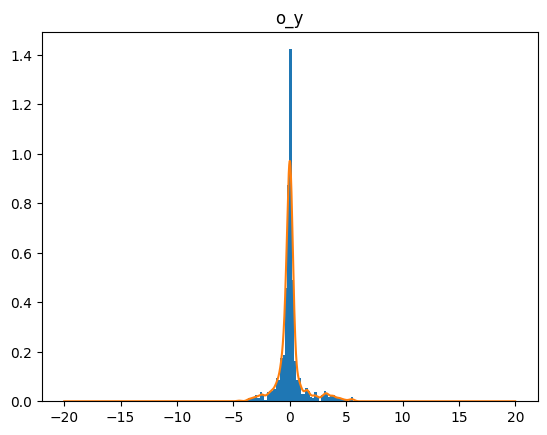

torch.Size([4000])
19001  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
19002  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
19003  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
19004  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
19005  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19006  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19007  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19008  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
19009  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
19010  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
19011  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
19012  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
19013  loss=  tensor(0.0379, grad_fn=<MeanBackward0>)
19014  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
19015  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19016  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19017  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19018  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19019  lo

19153  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19154  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19155  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19156  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19157  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19158  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19159  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19160  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19161  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19162  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
19163  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19164  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
19165  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
19166  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19167  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19168  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19169  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19170  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
19171  loss=  tensor(0.0376,

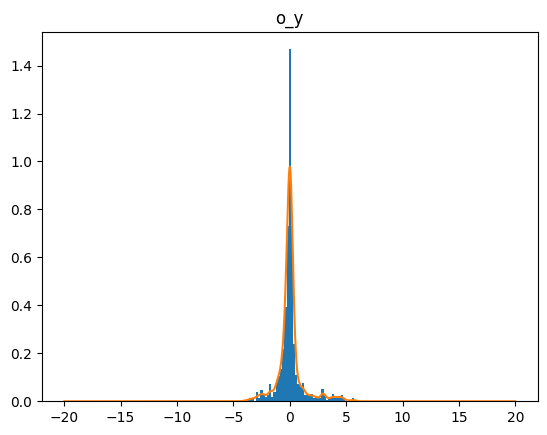

torch.Size([4000])
19201  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19202  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
19203  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
19204  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
19205  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19206  loss=  tensor(0.0379, grad_fn=<MeanBackward0>)
19207  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
19208  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
19209  loss=  tensor(0.0379, grad_fn=<MeanBackward0>)
19210  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
19211  loss=  tensor(0.0379, grad_fn=<MeanBackward0>)
19212  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19213  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19214  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
19215  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
19216  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19217  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
19218  loss=  tensor(0.0380, grad_fn=<MeanBackward0>)
19219  lo

19356  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19357  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19358  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19359  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19360  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19361  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19362  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
19363  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19364  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19365  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19366  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
19367  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
19368  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19369  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
19370  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19371  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19372  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19373  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19374  loss=  tensor(0.0374,

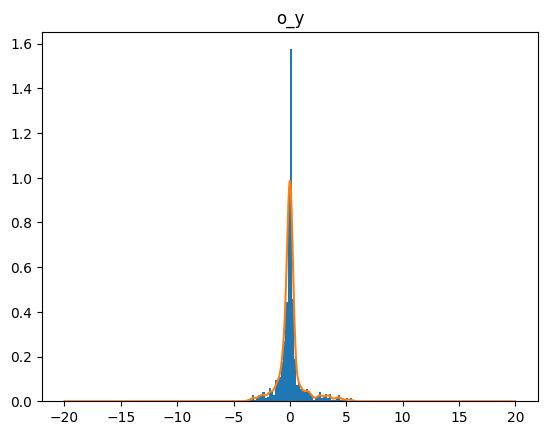

torch.Size([4000])
19401  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19402  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19403  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
19404  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19405  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19406  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19407  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
19408  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19409  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19410  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19411  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19412  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19413  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19414  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19415  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
19416  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19417  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
19418  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19419  lo

19562  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19563  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
19564  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19565  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19566  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19567  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19568  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19569  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
19570  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19571  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19572  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19573  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19574  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19575  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19576  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19577  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19578  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19579  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
19580  loss=  tensor(0.0375,

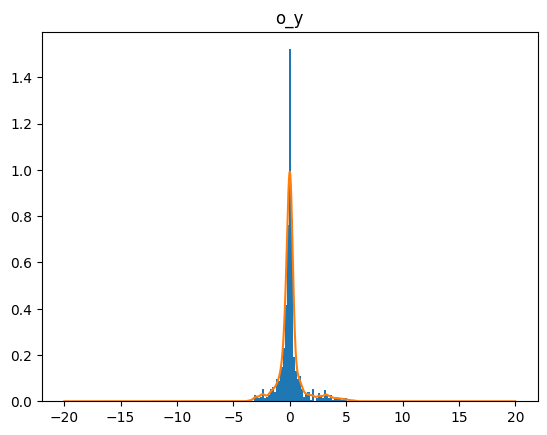

torch.Size([4000])
19601  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19602  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19603  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
19604  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19605  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19606  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19607  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19608  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
19609  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19610  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19611  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
19612  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19613  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19614  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19615  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19616  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19617  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
19618  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19619  lo

19753  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19754  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19755  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
19756  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19757  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19758  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19759  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
19760  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19761  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19762  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19763  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
19764  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
19765  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19766  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19767  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19768  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19769  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
19770  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19771  loss=  tensor(0.0371,

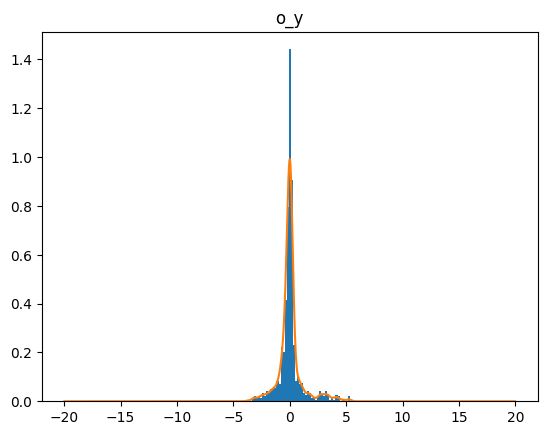

torch.Size([4000])
19801  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19802  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19803  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19804  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
19805  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19806  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
19807  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19808  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19809  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19810  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19811  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
19812  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19813  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19814  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
19815  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19816  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
19817  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
19818  loss=  tensor(0.0376, grad_fn=<MeanBackward0>)
19819  lo

19953  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19954  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19955  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19956  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
19957  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
19958  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19959  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
19960  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
19961  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
19962  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
19963  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19964  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
19965  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19966  loss=  tensor(0.0378, grad_fn=<MeanBackward0>)
19967  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
19968  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19969  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
19970  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
19971  loss=  tensor(0.0372,

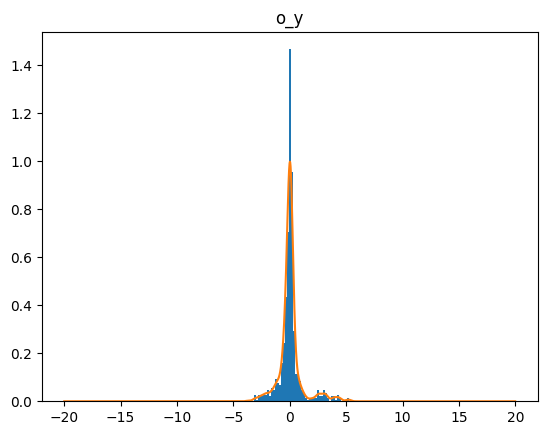

torch.Size([4000])
20001  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20002  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20003  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20004  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20005  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
20006  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20007  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20008  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20009  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
20010  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20011  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
20012  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
20013  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20014  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
20015  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20016  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20017  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20018  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20019  lo

20156  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20157  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
20158  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
20159  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
20160  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20161  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20162  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20163  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20164  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20165  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20166  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
20167  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20168  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20169  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
20170  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
20171  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
20172  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20173  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
20174  loss=  tensor(0.0375,

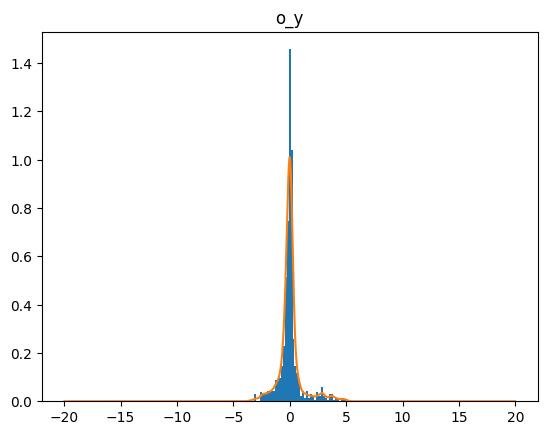

torch.Size([4000])
20201  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
20202  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
20203  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20204  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
20205  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20206  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
20207  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
20208  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
20209  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20210  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20211  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20212  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
20213  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20214  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20215  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20216  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20217  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20218  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
20219  lo

20358  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
20359  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20360  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20361  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20362  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20363  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
20364  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20365  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20366  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
20367  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20368  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20369  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
20370  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20371  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
20372  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20373  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20374  loss=  tensor(0.0377, grad_fn=<MeanBackward0>)
20375  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20376  loss=  tensor(0.0370,

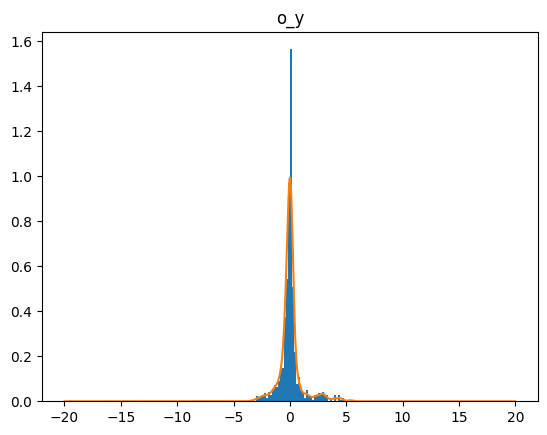

torch.Size([4000])
20401  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
20402  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20403  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20404  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20405  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20406  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
20407  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20408  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20409  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20410  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20411  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
20412  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20413  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20414  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
20415  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
20416  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20417  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20418  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20419  lo

20559  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20560  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20561  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20562  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20563  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
20564  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20565  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20566  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20567  loss=  tensor(0.0375, grad_fn=<MeanBackward0>)
20568  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20569  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20570  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20571  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20572  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20573  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20574  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20575  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20576  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20577  loss=  tensor(0.0367,

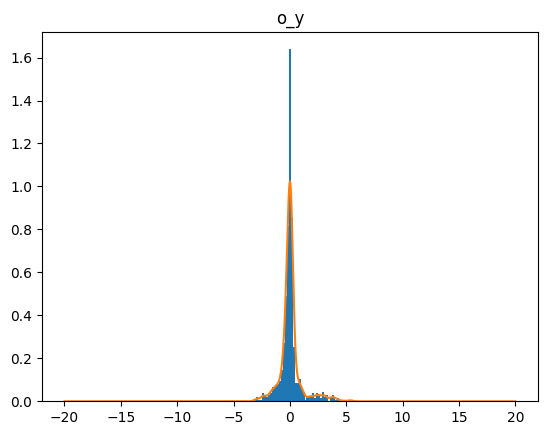

torch.Size([4000])
20601  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
20602  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
20603  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20604  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20605  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20606  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20607  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
20608  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20609  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20610  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20611  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
20612  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20613  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20614  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20615  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20616  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20617  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20618  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20619  lo

20759  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20760  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20761  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20762  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20763  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20764  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
20765  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20766  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20767  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20768  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
20769  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
20770  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20771  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20772  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20773  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20774  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20775  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
20776  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20777  loss=  tensor(0.0369,

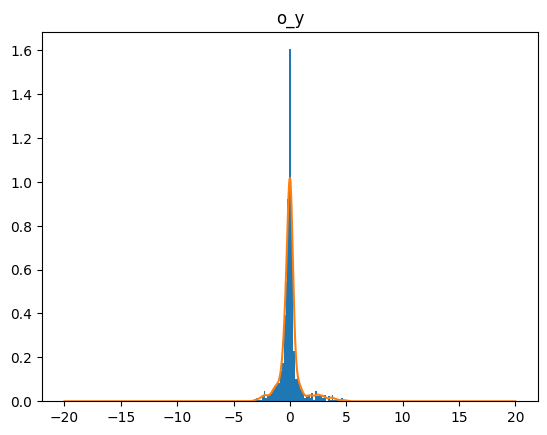

torch.Size([4000])
20801  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
20802  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20803  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20804  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20805  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
20806  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20807  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20808  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20809  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20810  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20811  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20812  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
20813  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20814  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20815  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
20816  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20817  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20818  loss=  tensor(0.0371, grad_fn=<MeanBackward0>)
20819  lo

20953  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20954  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20955  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20956  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20957  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
20958  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20959  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20960  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20961  loss=  tensor(0.0373, grad_fn=<MeanBackward0>)
20962  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
20963  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
20964  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20965  loss=  tensor(0.0363, grad_fn=<MeanBackward0>)
20966  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
20967  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
20968  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
20969  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
20970  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
20971  loss=  tensor(0.0368,

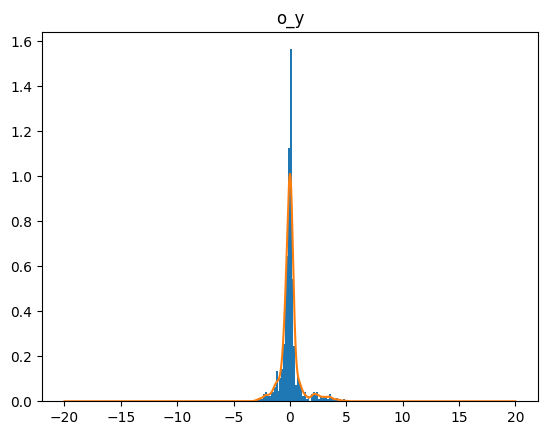

torch.Size([4000])
21001  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
21002  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
21003  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
21004  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
21005  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
21006  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
21007  loss=  tensor(0.0370, grad_fn=<MeanBackward0>)
21008  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
21009  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
21010  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
21011  loss=  tensor(0.0374, grad_fn=<MeanBackward0>)
21012  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
21013  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
21014  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
21015  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
21016  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
21017  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
21018  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
21019  lo

21156  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
21157  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
21158  loss=  tensor(0.0361, grad_fn=<MeanBackward0>)
21159  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
21160  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
21161  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
21162  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
21163  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
21164  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
21165  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
21166  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
21167  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
21168  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
21169  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
21170  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
21171  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
21172  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
21173  loss=  tensor(0.0362, grad_fn=<MeanBackward0>)
21174  loss=  tensor(0.0366,

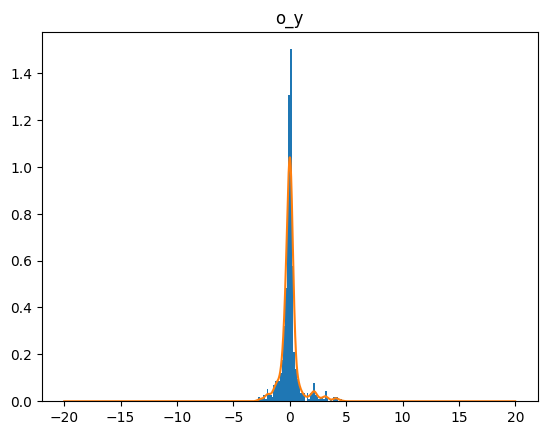

torch.Size([4000])
21201  loss=  tensor(0.0362, grad_fn=<MeanBackward0>)
21202  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21203  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
21204  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
21205  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
21206  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
21207  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
21208  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
21209  loss=  tensor(0.0362, grad_fn=<MeanBackward0>)
21210  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
21211  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
21212  loss=  tensor(0.0372, grad_fn=<MeanBackward0>)
21213  loss=  tensor(0.0363, grad_fn=<MeanBackward0>)
21214  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
21215  loss=  tensor(0.0369, grad_fn=<MeanBackward0>)
21216  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
21217  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
21218  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
21219  lo

21358  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
21359  loss=  tensor(0.0361, grad_fn=<MeanBackward0>)
21360  loss=  tensor(0.0362, grad_fn=<MeanBackward0>)
21361  loss=  tensor(0.0363, grad_fn=<MeanBackward0>)
21362  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
21363  loss=  tensor(0.0363, grad_fn=<MeanBackward0>)
21364  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
21365  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
21366  loss=  tensor(0.0362, grad_fn=<MeanBackward0>)
21367  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21368  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
21369  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
21370  loss=  tensor(0.0368, grad_fn=<MeanBackward0>)
21371  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
21372  loss=  tensor(0.0362, grad_fn=<MeanBackward0>)
21373  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
21374  loss=  tensor(0.0362, grad_fn=<MeanBackward0>)
21375  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
21376  loss=  tensor(0.0365,

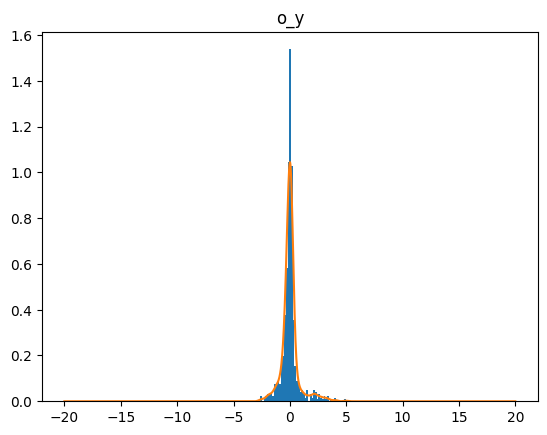

torch.Size([4000])
21401  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21402  loss=  tensor(0.0363, grad_fn=<MeanBackward0>)
21403  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21404  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
21405  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
21406  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
21407  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
21408  loss=  tensor(0.0361, grad_fn=<MeanBackward0>)
21409  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
21410  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
21411  loss=  tensor(0.0361, grad_fn=<MeanBackward0>)
21412  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
21413  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
21414  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
21415  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
21416  loss=  tensor(0.0361, grad_fn=<MeanBackward0>)
21417  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
21418  loss=  tensor(0.0362, grad_fn=<MeanBackward0>)
21419  lo

21554  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
21555  loss=  tensor(0.0361, grad_fn=<MeanBackward0>)
21556  loss=  tensor(0.0361, grad_fn=<MeanBackward0>)
21557  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21558  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
21559  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
21560  loss=  tensor(0.0363, grad_fn=<MeanBackward0>)
21561  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21562  loss=  tensor(0.0367, grad_fn=<MeanBackward0>)
21563  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
21564  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
21565  loss=  tensor(0.0364, grad_fn=<MeanBackward0>)
21566  loss=  tensor(0.0361, grad_fn=<MeanBackward0>)
21567  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
21568  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
21569  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
21570  loss=  tensor(0.0363, grad_fn=<MeanBackward0>)
21571  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21572  loss=  tensor(0.0365,

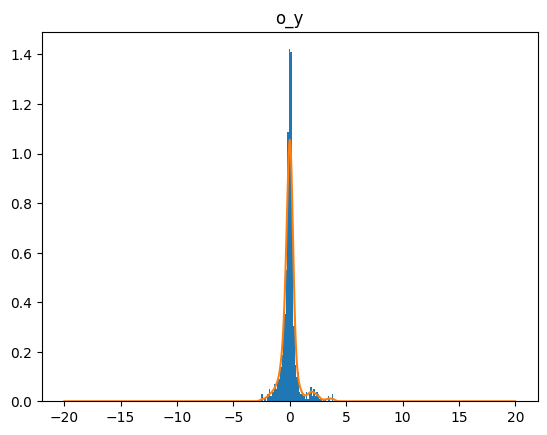

torch.Size([4000])
21601  loss=  tensor(0.0363, grad_fn=<MeanBackward0>)
21602  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21603  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
21604  loss=  tensor(0.0363, grad_fn=<MeanBackward0>)
21605  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
21606  loss=  tensor(0.0361, grad_fn=<MeanBackward0>)
21607  loss=  tensor(0.0363, grad_fn=<MeanBackward0>)
21608  loss=  tensor(0.0363, grad_fn=<MeanBackward0>)
21609  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
21610  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
21611  loss=  tensor(0.0365, grad_fn=<MeanBackward0>)
21612  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
21613  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
21614  loss=  tensor(0.0362, grad_fn=<MeanBackward0>)
21615  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
21616  loss=  tensor(0.0362, grad_fn=<MeanBackward0>)
21617  loss=  tensor(0.0366, grad_fn=<MeanBackward0>)
21618  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
21619  lo

21753  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21754  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
21755  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
21756  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
21757  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21758  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
21759  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21760  loss=  tensor(0.0363, grad_fn=<MeanBackward0>)
21761  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
21762  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
21763  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21764  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
21765  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
21766  loss=  tensor(0.0362, grad_fn=<MeanBackward0>)
21767  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
21768  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21769  loss=  tensor(0.0361, grad_fn=<MeanBackward0>)
21770  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
21771  loss=  tensor(0.0361,

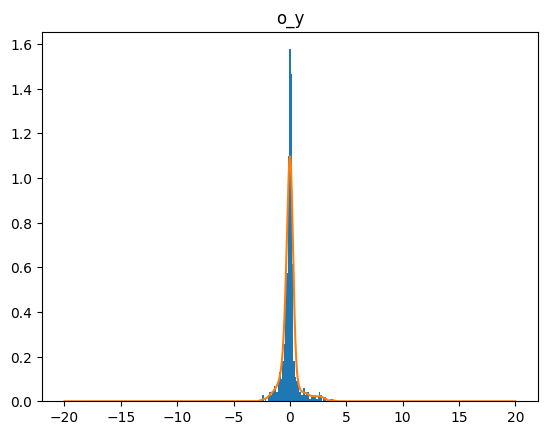

torch.Size([4000])
21801  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
21802  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
21803  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
21804  loss=  tensor(0.0361, grad_fn=<MeanBackward0>)
21805  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
21806  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
21807  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
21808  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
21809  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
21810  loss=  tensor(0.0361, grad_fn=<MeanBackward0>)
21811  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
21812  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
21813  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21814  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
21815  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21816  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
21817  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21818  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
21819  lo

21955  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
21956  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
21957  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
21958  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
21959  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
21960  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
21961  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
21962  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
21963  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
21964  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
21965  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
21966  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
21967  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
21968  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
21969  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
21970  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
21971  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
21972  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
21973  loss=  tensor(0.0353,

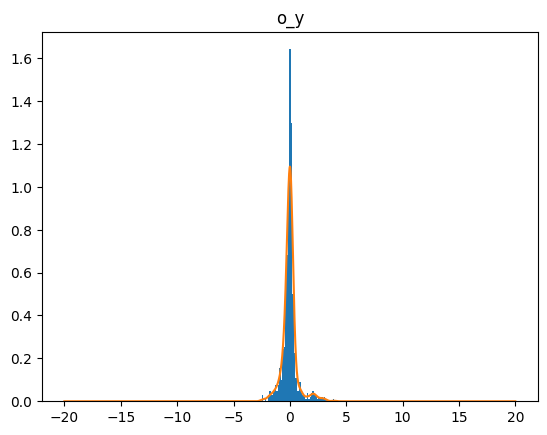

torch.Size([4000])
22001  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22002  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22003  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22004  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22005  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
22006  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22007  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
22008  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22009  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
22010  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
22011  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
22012  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
22013  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
22014  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22015  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22016  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22017  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22018  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22019  lo

22153  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22154  loss=  tensor(0.0361, grad_fn=<MeanBackward0>)
22155  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22156  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22157  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
22158  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22159  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
22160  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22161  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
22162  loss=  tensor(0.0351, grad_fn=<MeanBackward0>)
22163  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22164  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22165  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22166  loss=  tensor(0.0361, grad_fn=<MeanBackward0>)
22167  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22168  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22169  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22170  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22171  loss=  tensor(0.0359,

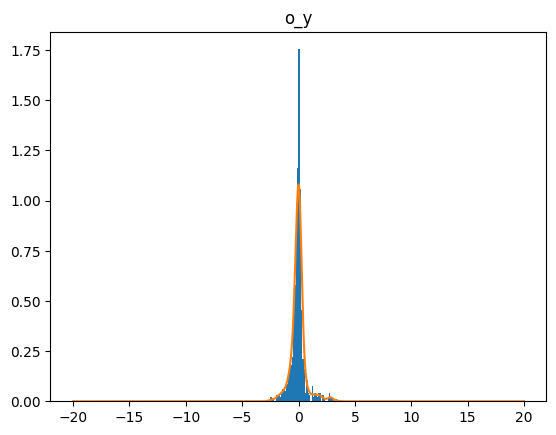

torch.Size([4000])
22201  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22202  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22203  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22204  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22205  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22206  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22207  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
22208  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
22209  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
22210  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22211  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22212  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22213  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22214  loss=  tensor(0.0349, grad_fn=<MeanBackward0>)
22215  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22216  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22217  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22218  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22219  lo

22354  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
22355  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22356  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22357  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22358  loss=  tensor(0.0362, grad_fn=<MeanBackward0>)
22359  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
22360  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
22361  loss=  tensor(0.0351, grad_fn=<MeanBackward0>)
22362  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
22363  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
22364  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
22365  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22366  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22367  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22368  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22369  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22370  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22371  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22372  loss=  tensor(0.0350,

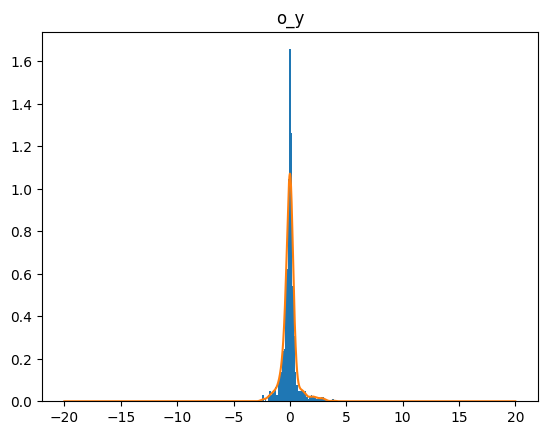

torch.Size([4000])
22401  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
22402  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22403  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22404  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
22405  loss=  tensor(0.0351, grad_fn=<MeanBackward0>)
22406  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22407  loss=  tensor(0.0351, grad_fn=<MeanBackward0>)
22408  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22409  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22410  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
22411  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22412  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22413  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
22414  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22415  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22416  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22417  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22418  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22419  lo

22553  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22554  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22555  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22556  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22557  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
22558  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
22559  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22560  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
22561  loss=  tensor(0.0361, grad_fn=<MeanBackward0>)
22562  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22563  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22564  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22565  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22566  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22567  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22568  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
22569  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22570  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22571  loss=  tensor(0.0353,

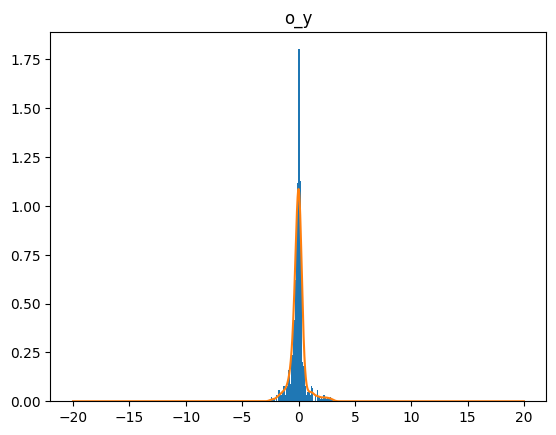

torch.Size([4000])
22601  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22602  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22603  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22604  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22605  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
22606  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22607  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22608  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22609  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
22610  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22611  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22612  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22613  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22614  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22615  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22616  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22617  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
22618  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22619  lo

22760  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22761  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
22762  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22763  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22764  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22765  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22766  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
22767  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22768  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22769  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
22770  loss=  tensor(0.0350, grad_fn=<MeanBackward0>)
22771  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22772  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22773  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22774  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22775  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
22776  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22777  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
22778  loss=  tensor(0.0357,

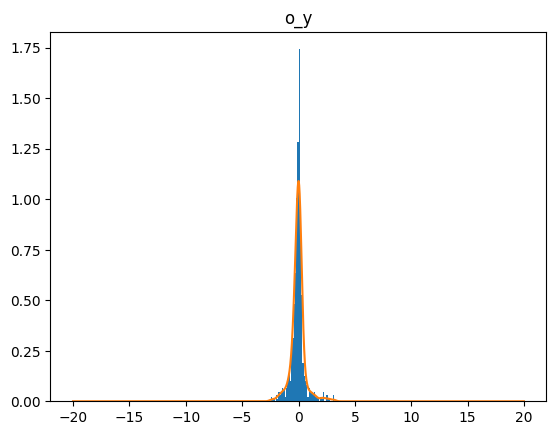

torch.Size([4000])
22801  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
22802  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22803  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
22804  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22805  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
22806  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
22807  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22808  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22809  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22810  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22811  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22812  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
22813  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22814  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22815  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
22816  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
22817  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22818  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
22819  lo

22954  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22955  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
22956  loss=  tensor(0.0351, grad_fn=<MeanBackward0>)
22957  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22958  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22959  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22960  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
22961  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22962  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22963  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
22964  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
22965  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22966  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22967  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
22968  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
22969  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
22970  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
22971  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
22972  loss=  tensor(0.0353,

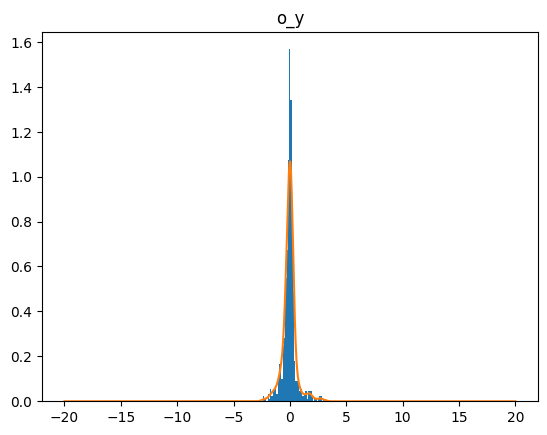

torch.Size([4000])
23001  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23002  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23003  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
23004  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23005  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23006  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23007  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23008  loss=  tensor(0.0351, grad_fn=<MeanBackward0>)
23009  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23010  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23011  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
23012  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23013  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23014  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23015  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
23016  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23017  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
23018  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23019  lo

23154  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23155  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23156  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23157  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23158  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23159  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
23160  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
23161  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
23162  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23163  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23164  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23165  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
23166  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23167  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23168  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23169  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
23170  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23171  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
23172  loss=  tensor(0.0356,

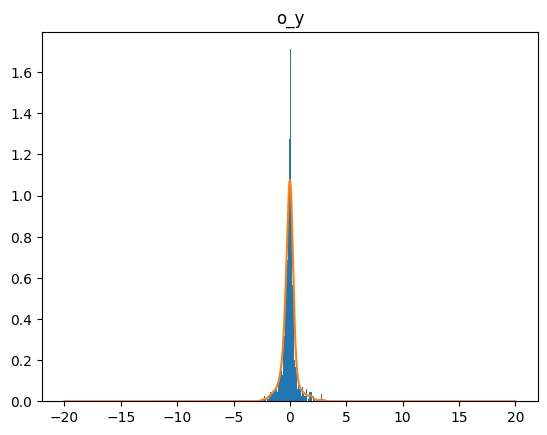

torch.Size([4000])
23201  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23202  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23203  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23204  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
23205  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
23206  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23207  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23208  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23209  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23210  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23211  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
23212  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23213  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23214  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23215  loss=  tensor(0.0362, grad_fn=<MeanBackward0>)
23216  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23217  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23218  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23219  lo

23357  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23358  loss=  tensor(0.0351, grad_fn=<MeanBackward0>)
23359  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23360  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
23361  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23362  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23363  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23364  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
23365  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23366  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23367  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23368  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23369  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23370  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23371  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23372  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23373  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23374  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23375  loss=  tensor(0.0353,

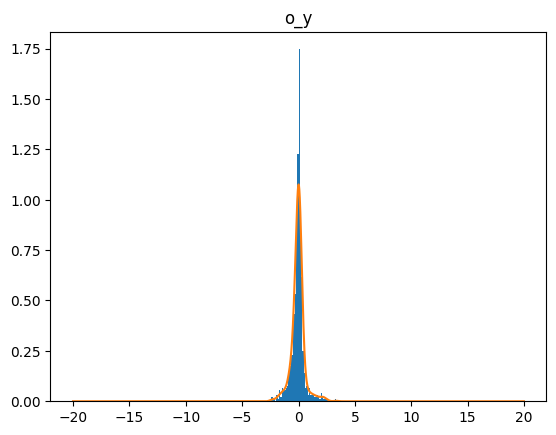

torch.Size([4000])
23401  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23402  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23403  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23404  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23405  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23406  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23407  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23408  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23409  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23410  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23411  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23412  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23413  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23414  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23415  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23416  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23417  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23418  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23419  lo

23557  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23558  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23559  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23560  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23561  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23562  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
23563  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23564  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23565  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23566  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23567  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
23568  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23569  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
23570  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23571  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23572  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23573  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23574  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23575  loss=  tensor(0.0353,

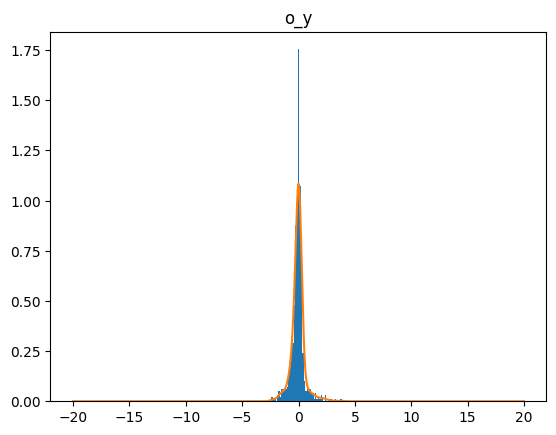

torch.Size([4000])
23601  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23602  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23603  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
23604  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
23605  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23606  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23607  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
23608  loss=  tensor(0.0351, grad_fn=<MeanBackward0>)
23609  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23610  loss=  tensor(0.0351, grad_fn=<MeanBackward0>)
23611  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23612  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
23613  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
23614  loss=  tensor(0.0362, grad_fn=<MeanBackward0>)
23615  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23616  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23617  loss=  tensor(0.0360, grad_fn=<MeanBackward0>)
23618  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
23619  lo

23758  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
23759  loss=  tensor(0.0362, grad_fn=<MeanBackward0>)
23760  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23761  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
23762  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23763  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23764  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23765  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23766  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
23767  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23768  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23769  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23770  loss=  tensor(0.0351, grad_fn=<MeanBackward0>)
23771  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
23772  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23773  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23774  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23775  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23776  loss=  tensor(0.0352,

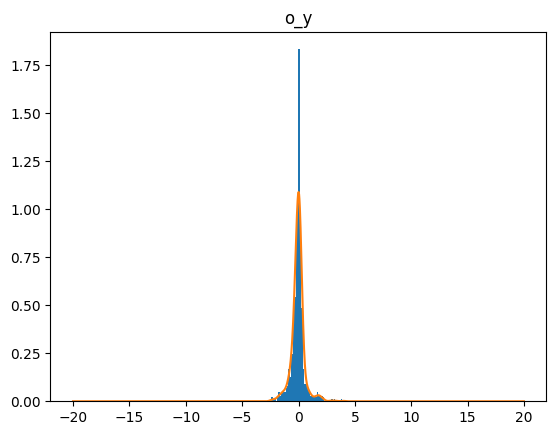

torch.Size([4000])
23801  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23802  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23803  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23804  loss=  tensor(0.0358, grad_fn=<MeanBackward0>)
23805  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23806  loss=  tensor(0.0351, grad_fn=<MeanBackward0>)
23807  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23808  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23809  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23810  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23811  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23812  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
23813  loss=  tensor(0.0354, grad_fn=<MeanBackward0>)
23814  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23815  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23816  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23817  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23818  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23819  lo

23957  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23958  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23959  loss=  tensor(0.0350, grad_fn=<MeanBackward0>)
23960  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23961  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23962  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23963  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23964  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23965  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23966  loss=  tensor(0.0359, grad_fn=<MeanBackward0>)
23967  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23968  loss=  tensor(0.0357, grad_fn=<MeanBackward0>)
23969  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23970  loss=  tensor(0.0352, grad_fn=<MeanBackward0>)
23971  loss=  tensor(0.0356, grad_fn=<MeanBackward0>)
23972  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23973  loss=  tensor(0.0355, grad_fn=<MeanBackward0>)
23974  loss=  tensor(0.0353, grad_fn=<MeanBackward0>)
23975  loss=  tensor(0.0357,

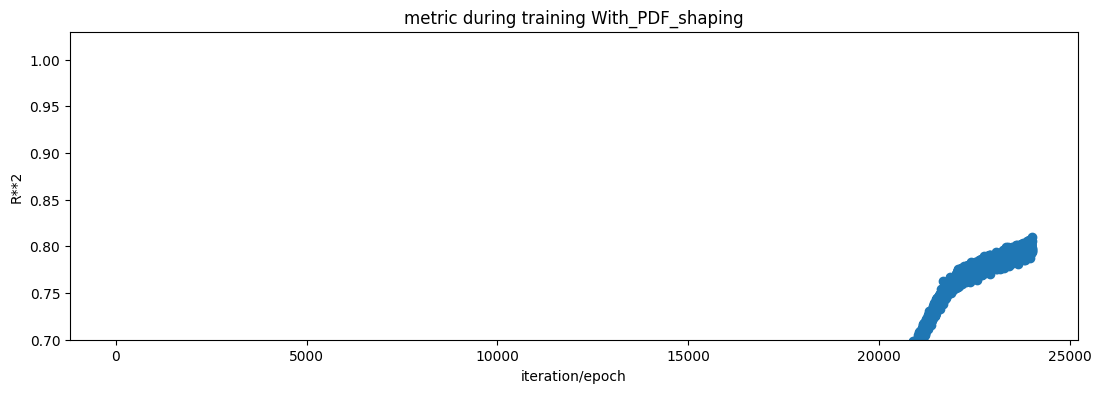

Training loss: tensor(0.3135, grad_fn=<MseLossBackward0>)
Training R**2: 0.8009595133258234
Test loss - scaled: tensor(0.4017, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(1.4976, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.7785963440503413
Testing R**2 - descaled: 0.7785963489090382
*****
*****
Testing R**2 - Output: 0 o_y 0.7785963489090382


In [32]:


PDFshapingOBJ.N_EPOCHS     = 4                 ## debug, remove                   
PDFshapingOBJ.N_EPOCHS_PDF = 24000              ## debug, remove

modelSigma = SigmaNN()
    

model = F1plusF2_SIO(
          PDFshapingOBJ.x_means, 
          PDFshapingOBJ.x_deviations, 
          PDFshapingOBJ.y_means, 
          PDFshapingOBJ.y_deviations
)


'''
model = LinRegNet_SIO(
          PDFshapingOBJ.x_means, 
          PDFshapingOBJ.x_deviations, 
          PDFshapingOBJ.y_means, 
          PDFshapingOBJ.y_deviations
)
'''

opt       = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate   )
opt_sigma = torch.optim.Adam(   modelSigma.parameters(), lr=PDFshapingOBJ.learning_rate   )

loss_fn     = F.mse_loss


fit_y_scaled_PDF(PDFshapingOBJ.N_EPOCHS, PDFshapingOBJ.N_EPOCHS_PDF, model, loss_fn, opt, modelSigma, opt_sigma)

pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,       PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,     PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()   ))


PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)


## Now predict on test data

In [33]:

list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])

**************************************************
preds, real
(9.960011, 9.4063)
**************************************************
preds, real
(13.264726, 13.524)
**************************************************
preds, real
(10.039664, 10.02)
**************************************************
preds, real
(8.397602, 8.1668)
**************************************************
preds, real
(9.219243, 9.0011)
**************************************************
preds, real
(10.287942, 10.596)
**************************************************
preds, real
(12.849792, 13.303)
**************************************************
preds, real
(11.774881, 11.435)
**************************************************
preds, real
(14.072123, 13.588)
**************************************************
preds, real
(10.319619, 10.625)
**************************************************
preds, real
(10.427832, 11.757)
**************************************************
preds, real
(10.579753, 12.006)
********

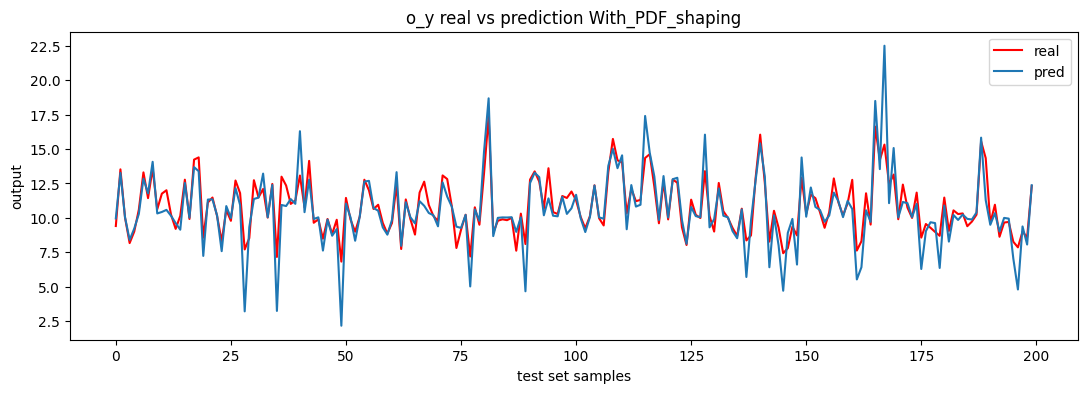

/Users/user/Desktop/DOE_CIVS/experiments/2023april/PDFshapingUtils.py:339: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


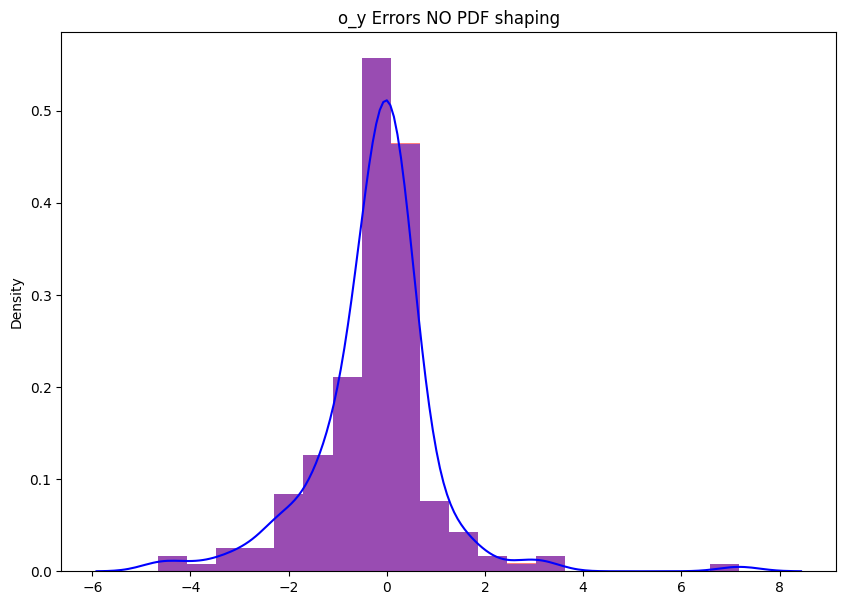

In [34]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )


## Export ONNX model

In [ ]:

'''

model.eval()

dummy_input = torch.randn(1, 6)


input_names = ["input1"]
output_names = ["output1", "output2"]

torch.onnx.export(
  model, 
  dummy_input, 
  "ONNXmodels/s536ShaftPDFshapingRC.onnx", 
  verbose=False, 
  input_names  = input_names,
  output_names = output_names
)

'''
